In [ ]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
import math

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period_2000_2021/"
np.random.seed(12001)


# Define the model that generates pair simulations.
yuima = importr("yuima")
n_jumpou_NIG_sim_string = """
n_jumpou_NIG = function(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  jumpcoef = matrix(c("j11", "j12", "j21", "j22"), 2, 2, byrow=TRUE) 
  
  alpha = alpha
  beta = c(beta1, beta2)
  delta0 = delta0
  mu = c(mu1, mu2)
  Lambda = matrix(c(lambda11, lambda12, lambda21, lambda22), 2, 2, byrow=TRUE)
  
  ou_model = setModel(drift=drift, diffusion=diffusion, jump.coeff=jumpcoef, 
                      measure.type="code",
                      measure=list(df="rNIG(z, alpha, beta, delta0, mu, Lambda)"), 
                      time.variable = "t",
                      state.var=c("X1","X2"), solve.variable=c("X1","X2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    jumpou_sim = simulate(ou_model, 
                          true.par=list(
                            mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                            sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                            j11=j11, j12=j12, j21=j21, j22=j22,
                            alpha=alpha, beta=beta, delta0=delta0, mu=mu, Lambda=Lambda), 
                          xinit=xinit_vec[[i]], sampling=newsamp)
    original_data = jumpou_sim@data@original.data
    one_sim_jumpou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_jumpou) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_jumpou
  }
  return(n_sim_data)
}
"""

n_jumpou_NIG_sim = SignatureTranslatedAnonymousPackage(n_jumpou_NIG_sim_string, "n_jumpou_NIG_sim")
def n_jumpou_simulation(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_jumpou_NIG_sim.n_jumpou_NIG(random_seed, num_sim,
                                      mu11, mu12, mu21, mu22, 
                                      sigma11, sigma12, sigma21, sigma22,
                                      j11, j12, j21, j22,
                                      alpha, beta1, beta2, delta0, mu1, mu2, 
                                      lambda11, lambda12, lambda21, lambda22,
                                      xinit_vec, T0, T, length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef

def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]
    sq_return_series1 = return_series1**2
    sq_return_series2 = return_series2**2

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series2.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values #8(8)
    
    
    
    # Autocorrelation of the 2 return series with 3 lags respectively
    autocorr1_lag_1 = return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr1_lag_2 = return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr1_lag_3 = return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr2_lag_1 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr2_lag_2 = return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr2_lag_3 = return_series2.apply(lambda x: x.autocorr(lag=3)) #6(14)
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(21)
    
    
    
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#6(27)
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, #8(8)
                               
                               autocorr1_lag_1, autocorr1_lag_2, autocorr1_lag_3,
                               autocorr2_lag_1, autocorr2_lag_2, autocorr2_lag_3,#6(14)
                               
                               corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
                               
                               autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
                               autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)
                               
                               corr_sqts1_lag_0,
                               corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
                               corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3])#7(34)
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_ts1_lag1', 'return_autocorrelation_ts1_lag2', 'return_autocorrelation_ts1_lag3',
        'return_autocorrelation_ts2_lag1', 'return_autocorrelation_ts2_lag2', 'return_autocorrelation_ts2_lag3',
        
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3']
    
    return stats_data



def loss_function(params):

    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    n_sim_log_price = n_jumpou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[4], mu12=params[5], 
        mu21=params[6], mu22=params[7], 
        sigma11=params[8], sigma12=params[9], 
        sigma21=params[10], sigma22=params[11],
        j11=params[12], j12=params[13], 
        j21=params[14], j22=params[15],
        
        alpha=2*params[0]*params[1]+0.5, 
        beta1=params[0], beta2=params[1], 
        delta0=params[2], 
        mu1=0, mu2=0, 
        lambda11=params[3], lambda12=0, 
        lambda21=0, lambda22=1/params[3],

        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)

    moment_loss = np.abs(n_real_stats - n_sim_stats)
    sum_loss = np.sum(moment_loss)

    sum_loss[6] = sum_loss[6]/10 
    sum_loss[7] = sum_loss[7]/10 
    
    loss = np.sum(sum_loss)

    print(sum_loss)
    print(loss)
    print('----------')

    return loss


real_price = pd.read_csv(real_data_folder + "pair_prices_cal.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_returns_cal.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 2, real_price.shape[0]
n_real_stats = real_stats




initial0 = [1, 1, 
            1, 
            1,
            
            1, 1, 1, 1,
            -1, -1, -1, -1,
            0.1, 0.1, 0.1, 0.1]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='powell',
               tol=1e-6, 
               options={'disp': True},
               bounds=[                       
                   (0, None), (0, None), 
                   (0, None), 
                   (0, None),
                   
                   (0, None), (0, None), (0, None), (0, None),
                   (None, None), (None, None), (None, None), (None, None),
                   (None, None), (None, None), (None, None), (None, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)


 [1]  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0 -1.0 -1.0 -1.0 -1.0  0.1  0.1  0.1
[16]  0.1

return_mean1                          98.129723
return_mean2                          93.534993
return_sd1                           400.756840
return_sd2                           391.775100
return_skew1                         167.675358
return_skew2                         177.687202
return_kurtosis1                     162.408885
return_kurtosis2                     178.095320
return_autocorrelation_ts1_lag1       16.545422
return_autocorrelation_ts1_lag2       14.336564
return_autocorrelation_ts1_lag3       14.499319
return_autocorrelation_ts2_lag1       16.350081
return_autocorrelation_ts2_lag2       14.788469
return_autocorrelation_ts2_lag3       14.783358
return_correlation_ts1_lag_0         166.466628
return_correlation_ts1_lag_1          14.334188
return_correlation_ts1_lag_2          14.418730
return_correlation_ts1_lag_3          15.002752
return_correlation_ts2_lag_1          15.6381

return_mean1                         100.563037
return_mean2                          95.486214
return_sd1                           387.658958
return_sd2                           378.065377
return_skew1                         143.823628
return_skew2                         156.058581
return_kurtosis1                     154.997181
return_kurtosis2                     172.690973
return_autocorrelation_ts1_lag1       15.707405
return_autocorrelation_ts1_lag2       14.860865
return_autocorrelation_ts1_lag3       13.512635
return_autocorrelation_ts2_lag1       16.465585
return_autocorrelation_ts2_lag2       15.042126
return_autocorrelation_ts2_lag3       14.566706
return_correlation_ts1_lag_0         166.460114
return_correlation_ts1_lag_1          14.190849
return_correlation_ts1_lag_2          14.658880
return_correlation_ts1_lag_3          14.325520
return_correlation_ts2_lag_1          14.742544
return_correlation_ts2_lag_2          13.274003
return_correlation_ts2_lag_3          13

return_mean1                          97.871510
return_mean2                          92.172661
return_sd1                           385.390934
return_sd2                           377.699297
return_skew1                         146.525150
return_skew2                         155.166189
return_kurtosis1                     154.459198
return_kurtosis2                     172.141537
return_autocorrelation_ts1_lag1       17.308014
return_autocorrelation_ts1_lag2       14.617274
return_autocorrelation_ts1_lag3       14.476827
return_autocorrelation_ts2_lag1       17.036376
return_autocorrelation_ts2_lag2       14.964830
return_autocorrelation_ts2_lag3       15.379357
return_correlation_ts1_lag_0         166.458467
return_correlation_ts1_lag_1          15.607013
return_correlation_ts1_lag_2          14.173397
return_correlation_ts1_lag_3          14.257835
return_correlation_ts2_lag_1          16.342250
return_correlation_ts2_lag_2          13.652673
return_correlation_ts2_lag_3          14

return_mean1                         100.760247
return_mean2                          96.051034
return_sd1                           389.531762
return_sd2                           380.213639
return_skew1                         145.331056
return_skew2                         155.001148
return_kurtosis1                     155.371199
return_kurtosis2                     173.099021
return_autocorrelation_ts1_lag1       16.664469
return_autocorrelation_ts1_lag2       15.271313
return_autocorrelation_ts1_lag3       14.665092
return_autocorrelation_ts2_lag1       15.489453
return_autocorrelation_ts2_lag2       14.506553
return_autocorrelation_ts2_lag3       15.246299
return_correlation_ts1_lag_0         166.461733
return_correlation_ts1_lag_1          14.058924
return_correlation_ts1_lag_2          13.657440
return_correlation_ts1_lag_3          14.527956
return_correlation_ts2_lag_1          15.229857
return_correlation_ts2_lag_2          12.123190
return_correlation_ts2_lag_3          14

return_mean1                          98.806507
return_mean2                          93.618681
return_sd1                           389.131147
return_sd2                           379.891383
return_skew1                         143.650288
return_skew2                         151.277491
return_kurtosis1                     155.947924
return_kurtosis2                     173.592240
return_autocorrelation_ts1_lag1       16.430591
return_autocorrelation_ts1_lag2       14.582496
return_autocorrelation_ts1_lag3       14.784199
return_autocorrelation_ts2_lag1       16.066402
return_autocorrelation_ts2_lag2       15.911094
return_autocorrelation_ts2_lag3       14.695759
return_correlation_ts1_lag_0         166.460111
return_correlation_ts1_lag_1          14.869789
return_correlation_ts1_lag_2          14.211640
return_correlation_ts1_lag_3          14.805903
return_correlation_ts2_lag_1          14.834696
return_correlation_ts2_lag_2          14.114590
return_correlation_ts2_lag_3          14

return_mean1                          97.851963
return_mean2                          92.758275
return_sd1                           388.022577
return_sd2                           381.669287
return_skew1                         145.622362
return_skew2                         156.624277
return_kurtosis1                     156.222291
return_kurtosis2                     173.973035
return_autocorrelation_ts1_lag1       18.273427
return_autocorrelation_ts1_lag2       14.621490
return_autocorrelation_ts1_lag3       14.674337
return_autocorrelation_ts2_lag1       17.911339
return_autocorrelation_ts2_lag2       15.387014
return_autocorrelation_ts2_lag3       15.038332
return_correlation_ts1_lag_0         166.461875
return_correlation_ts1_lag_1          15.751455
return_correlation_ts1_lag_2          14.227487
return_correlation_ts1_lag_3          14.427370
return_correlation_ts2_lag_1          17.096556
return_correlation_ts2_lag_2          13.326329
return_correlation_ts2_lag_3          14

return_mean1                         101.003670
return_mean2                          96.173553
return_sd1                           386.814048
return_sd2                           378.110038
return_skew1                         142.775436
return_skew2                         156.436668
return_kurtosis1                     156.266522
return_kurtosis2                     173.924215
return_autocorrelation_ts1_lag1       16.518818
return_autocorrelation_ts1_lag2       14.466146
return_autocorrelation_ts1_lag3       14.112844
return_autocorrelation_ts2_lag1       16.126886
return_autocorrelation_ts2_lag2       15.198904
return_autocorrelation_ts2_lag3       15.020284
return_correlation_ts1_lag_0         166.459909
return_correlation_ts1_lag_1          14.196209
return_correlation_ts1_lag_2          14.779036
return_correlation_ts1_lag_3          14.613249
return_correlation_ts2_lag_1          15.595427
return_correlation_ts2_lag_2          13.249663
return_correlation_ts2_lag_3          14

return_mean1                          99.696672
return_mean2                          94.556789
return_sd1                           385.103776
return_sd2                           377.023546
return_skew1                         139.955060
return_skew2                         156.971461
return_kurtosis1                     156.803713
return_kurtosis2                     174.466364
return_autocorrelation_ts1_lag1       17.992258
return_autocorrelation_ts1_lag2       15.524019
return_autocorrelation_ts1_lag3       14.966460
return_autocorrelation_ts2_lag1       16.690459
return_autocorrelation_ts2_lag2       15.669456
return_autocorrelation_ts2_lag3       14.038469
return_correlation_ts1_lag_0         166.458863
return_correlation_ts1_lag_1          14.920563
return_correlation_ts1_lag_2          15.123171
return_correlation_ts1_lag_3          14.435582
return_correlation_ts2_lag_1          15.522516
return_correlation_ts2_lag_2          13.913438
return_correlation_ts2_lag_3          14

return_mean1                         101.493748
return_mean2                          96.100469
return_sd1                           384.628260
return_sd2                           375.283430
return_skew1                         145.777030
return_skew2                         154.104690
return_kurtosis1                     156.686143
return_kurtosis2                     174.348012
return_autocorrelation_ts1_lag1       17.169858
return_autocorrelation_ts1_lag2       15.725033
return_autocorrelation_ts1_lag3       15.890735
return_autocorrelation_ts2_lag1       16.611078
return_autocorrelation_ts2_lag2       16.032486
return_autocorrelation_ts2_lag3       14.773509
return_correlation_ts1_lag_0         166.458431
return_correlation_ts1_lag_1          15.239364
return_correlation_ts1_lag_2          14.633142
return_correlation_ts1_lag_3          15.091053
return_correlation_ts2_lag_1          15.243964
return_correlation_ts2_lag_2          13.985148
return_correlation_ts2_lag_3          14

return_mean1                          99.959530
return_mean2                          94.787209
return_sd1                           383.951452
return_sd2                           375.241203
return_skew1                         145.085333
return_skew2                         153.568620
return_kurtosis1                     156.232127
return_kurtosis2                     173.842007
return_autocorrelation_ts1_lag1       17.306185
return_autocorrelation_ts1_lag2       16.308122
return_autocorrelation_ts1_lag3       14.111375
return_autocorrelation_ts2_lag1       16.669207
return_autocorrelation_ts2_lag2       16.127171
return_autocorrelation_ts2_lag3       14.439668
return_correlation_ts1_lag_0         166.458213
return_correlation_ts1_lag_1          15.740127
return_correlation_ts1_lag_2          15.125356
return_correlation_ts1_lag_3          13.961574
return_correlation_ts2_lag_1          15.166965
return_correlation_ts2_lag_2          14.246724
return_correlation_ts2_lag_3          14

return_mean1                         100.928722
return_mean2                          94.573322
return_sd1                           383.743260
return_sd2                           374.109692
return_skew1                         144.459273
return_skew2                         153.604171
return_kurtosis1                     156.616923
return_kurtosis2                     174.121858
return_autocorrelation_ts1_lag1       17.017024
return_autocorrelation_ts1_lag2       14.413293
return_autocorrelation_ts1_lag3       14.597311
return_autocorrelation_ts2_lag1       16.176150
return_autocorrelation_ts2_lag2       14.342468
return_autocorrelation_ts2_lag3       14.581761
return_correlation_ts1_lag_0         166.459043
return_correlation_ts1_lag_1          15.485045
return_correlation_ts1_lag_2          14.414459
return_correlation_ts1_lag_3          14.504629
return_correlation_ts2_lag_1          15.956998
return_correlation_ts2_lag_2          12.649020
return_correlation_ts2_lag_3          14

return_mean1                         102.373378
return_mean2                          96.710670
return_sd1                           384.981159
return_sd2                           376.536063
return_skew1                         141.080565
return_skew2                         152.716173
return_kurtosis1                     156.039710
return_kurtosis2                     173.724124
return_autocorrelation_ts1_lag1       16.442426
return_autocorrelation_ts1_lag2       14.452166
return_autocorrelation_ts1_lag3       14.360004
return_autocorrelation_ts2_lag1       16.378798
return_autocorrelation_ts2_lag2       15.748562
return_autocorrelation_ts2_lag3       15.301376
return_correlation_ts1_lag_0         166.460110
return_correlation_ts1_lag_1          14.482762
return_correlation_ts1_lag_2          14.838849
return_correlation_ts1_lag_3          14.798098
return_correlation_ts2_lag_1          15.602699
return_correlation_ts2_lag_2          13.537435
return_correlation_ts2_lag_3          13

return_mean1                         102.394017
return_mean2                          97.100567
return_sd1                           382.420403
return_sd2                           374.438522
return_skew1                         146.793473
return_skew2                         157.538200
return_kurtosis1                     156.552893
return_kurtosis2                     174.070710
return_autocorrelation_ts1_lag1       16.386997
return_autocorrelation_ts1_lag2       15.331795
return_autocorrelation_ts1_lag3       15.019708
return_autocorrelation_ts2_lag1       15.595431
return_autocorrelation_ts2_lag2       15.143828
return_autocorrelation_ts2_lag3       14.602095
return_correlation_ts1_lag_0         166.458687
return_correlation_ts1_lag_1          14.936211
return_correlation_ts1_lag_2          15.211851
return_correlation_ts1_lag_3          14.366111
return_correlation_ts2_lag_1          15.156862
return_correlation_ts2_lag_2          13.752873
return_correlation_ts2_lag_3          14

return_mean1                         100.860930
return_mean2                          95.325909
return_sd1                           381.861232
return_sd2                           373.472553
return_skew1                         145.647831
return_skew2                         154.674945
return_kurtosis1                     156.603479
return_kurtosis2                     174.271598
return_autocorrelation_ts1_lag1       15.884158
return_autocorrelation_ts1_lag2       15.273343
return_autocorrelation_ts1_lag3       14.482495
return_autocorrelation_ts2_lag1       16.793627
return_autocorrelation_ts2_lag2       14.761951
return_autocorrelation_ts2_lag3       14.960975
return_correlation_ts1_lag_0         166.459684
return_correlation_ts1_lag_1          14.107841
return_correlation_ts1_lag_2          14.851972
return_correlation_ts1_lag_3          13.975806
return_correlation_ts2_lag_1          15.391716
return_correlation_ts2_lag_2          13.211877
return_correlation_ts2_lag_3          14

return_mean1                         100.614741
return_mean2                          95.094928
return_sd1                           382.378695
return_sd2                           375.040342
return_skew1                         142.586902
return_skew2                         151.516564
return_kurtosis1                     156.470756
return_kurtosis2                     174.173525
return_autocorrelation_ts1_lag1       16.522302
return_autocorrelation_ts1_lag2       14.532436
return_autocorrelation_ts1_lag3       14.136967
return_autocorrelation_ts2_lag1       16.380238
return_autocorrelation_ts2_lag2       15.611391
return_autocorrelation_ts2_lag3       13.488778
return_correlation_ts1_lag_0         166.458875
return_correlation_ts1_lag_1          15.597499
return_correlation_ts1_lag_2          14.725780
return_correlation_ts1_lag_3          13.731311
return_correlation_ts2_lag_1          15.128313
return_correlation_ts2_lag_2          13.480194
return_correlation_ts2_lag_3          13

return_mean1                         100.540266
return_mean2                          95.131585
return_sd1                           382.400082
return_sd2                           373.534131
return_skew1                         142.537582
return_skew2                         156.720408
return_kurtosis1                     155.458726
return_kurtosis2                     173.105065
return_autocorrelation_ts1_lag1       16.270300
return_autocorrelation_ts1_lag2       15.050669
return_autocorrelation_ts1_lag3       15.608080
return_autocorrelation_ts2_lag1       16.754280
return_autocorrelation_ts2_lag2       15.305730
return_autocorrelation_ts2_lag3       15.788492
return_correlation_ts1_lag_0         166.456208
return_correlation_ts1_lag_1          14.065970
return_correlation_ts1_lag_2          14.575750
return_correlation_ts1_lag_3          15.698081
return_correlation_ts2_lag_1          15.347921
return_correlation_ts2_lag_2          13.051165
return_correlation_ts2_lag_3          15

return_mean1                         102.309091
return_mean2                          97.399231
return_sd1                           388.154112
return_sd2                           379.223217
return_skew1                         145.702628
return_skew2                         154.047545
return_kurtosis1                     156.208802
return_kurtosis2                     173.888106
return_autocorrelation_ts1_lag1       18.066926
return_autocorrelation_ts1_lag2       15.297307
return_autocorrelation_ts1_lag3       15.232426
return_autocorrelation_ts2_lag1       17.240697
return_autocorrelation_ts2_lag2       16.031971
return_autocorrelation_ts2_lag3       15.429054
return_correlation_ts1_lag_0         166.459463
return_correlation_ts1_lag_1          14.936086
return_correlation_ts1_lag_2          14.819266
return_correlation_ts1_lag_3          14.934855
return_correlation_ts2_lag_1          16.623540
return_correlation_ts2_lag_2          13.830103
return_correlation_ts2_lag_3          15

return_mean1                          98.675472
return_mean2                          92.876466
return_sd1                           385.152570
return_sd2                           377.937011
return_skew1                         143.100994
return_skew2                         157.375654
return_kurtosis1                     156.475124
return_kurtosis2                     174.116147
return_autocorrelation_ts1_lag1       17.053809
return_autocorrelation_ts1_lag2       15.474783
return_autocorrelation_ts1_lag3       15.120480
return_autocorrelation_ts2_lag1       16.777980
return_autocorrelation_ts2_lag2       15.587173
return_autocorrelation_ts2_lag3       15.189822
return_correlation_ts1_lag_0         166.457095
return_correlation_ts1_lag_1          15.647100
return_correlation_ts1_lag_2          14.731535
return_correlation_ts1_lag_3          15.594594
return_correlation_ts2_lag_1          15.544700
return_correlation_ts2_lag_2          12.890737
return_correlation_ts2_lag_3          15

return_mean1                         100.055033
return_mean2                          94.591422
return_sd1                           383.662712
return_sd2                           376.598214
return_skew1                         141.580917
return_skew2                         155.092258
return_kurtosis1                     156.333146
return_kurtosis2                     173.990860
return_autocorrelation_ts1_lag1       16.274533
return_autocorrelation_ts1_lag2       14.499846
return_autocorrelation_ts1_lag3       14.435959
return_autocorrelation_ts2_lag1       16.138223
return_autocorrelation_ts2_lag2       15.710253
return_autocorrelation_ts2_lag3       14.683683
return_correlation_ts1_lag_0         166.459960
return_correlation_ts1_lag_1          15.124144
return_correlation_ts1_lag_2          14.741198
return_correlation_ts1_lag_3          13.816794
return_correlation_ts2_lag_1          14.989669
return_correlation_ts2_lag_2          13.355154
return_correlation_ts2_lag_3          13

return_mean1                         100.387822
return_mean2                          95.255076
return_sd1                           383.236552
return_sd2                           375.649804
return_skew1                         143.792673
return_skew2                         155.838798
return_kurtosis1                     157.047512
return_kurtosis2                     174.725441
return_autocorrelation_ts1_lag1       17.406334
return_autocorrelation_ts1_lag2       16.262703
return_autocorrelation_ts1_lag3       14.610062
return_autocorrelation_ts2_lag1       16.526775
return_autocorrelation_ts2_lag2       15.571015
return_autocorrelation_ts2_lag3       13.808134
return_correlation_ts1_lag_0         166.458910
return_correlation_ts1_lag_1          15.575063
return_correlation_ts1_lag_2          15.625027
return_correlation_ts1_lag_3          14.028264
return_correlation_ts2_lag_1          15.680660
return_correlation_ts2_lag_2          14.336953
return_correlation_ts2_lag_3          13

return_mean1                         102.441577
return_mean2                          96.409967
return_sd1                           383.403624
return_sd2                           373.727893
return_skew1                         145.671824
return_skew2                         154.704199
return_kurtosis1                     156.936906
return_kurtosis2                     174.605668
return_autocorrelation_ts1_lag1       15.717641
return_autocorrelation_ts1_lag2       16.245414
return_autocorrelation_ts1_lag3       13.931643
return_autocorrelation_ts2_lag1       15.677866
return_autocorrelation_ts2_lag2       16.721403
return_autocorrelation_ts2_lag3       13.724023
return_correlation_ts1_lag_0         166.457483
return_correlation_ts1_lag_1          14.308361
return_correlation_ts1_lag_2          15.653220
return_correlation_ts1_lag_3          14.793862
return_correlation_ts2_lag_1          15.220741
return_correlation_ts2_lag_2          14.571825
return_correlation_ts2_lag_3          13

return_mean1                          98.256528
return_mean2                          92.901235
return_sd1                           384.673746
return_sd2                           376.083903
return_skew1                         144.894786
return_skew2                         153.992063
return_kurtosis1                     156.523630
return_kurtosis2                     174.197050
return_autocorrelation_ts1_lag1       15.983871
return_autocorrelation_ts1_lag2       14.683789
return_autocorrelation_ts1_lag3       14.786784
return_autocorrelation_ts2_lag1       16.730075
return_autocorrelation_ts2_lag2       14.147853
return_autocorrelation_ts2_lag3       14.956752
return_correlation_ts1_lag_0         166.458414
return_correlation_ts1_lag_1          13.353493
return_correlation_ts1_lag_2          13.895571
return_correlation_ts1_lag_3          14.674208
return_correlation_ts2_lag_1          15.248964
return_correlation_ts2_lag_2          12.725612
return_correlation_ts2_lag_3          14

return_mean1                          99.816973
return_mean2                          94.397706
return_sd1                           381.987988
return_sd2                           374.070194
return_skew1                         147.269833
return_skew2                         155.889253
return_kurtosis1                     156.536474
return_kurtosis2                     174.207888
return_autocorrelation_ts1_lag1       16.404411
return_autocorrelation_ts1_lag2       15.027671
return_autocorrelation_ts1_lag3       14.504673
return_autocorrelation_ts2_lag1       16.907320
return_autocorrelation_ts2_lag2       15.298678
return_autocorrelation_ts2_lag3       14.117156
return_correlation_ts1_lag_0         166.459152
return_correlation_ts1_lag_1          15.302424
return_correlation_ts1_lag_2          14.174198
return_correlation_ts1_lag_3          14.182338
return_correlation_ts2_lag_1          15.710722
return_correlation_ts2_lag_2          13.530859
return_correlation_ts2_lag_3          14

return_mean1                          98.935233
return_mean2                          94.225525
return_sd1                           381.962099
return_sd2                           375.286638
return_skew1                         147.572167
return_skew2                         153.766249
return_kurtosis1                     156.699779
return_kurtosis2                     174.362637
return_autocorrelation_ts1_lag1       16.630709
return_autocorrelation_ts1_lag2       14.170151
return_autocorrelation_ts1_lag3       14.068046
return_autocorrelation_ts2_lag1       16.725878
return_autocorrelation_ts2_lag2       14.650126
return_autocorrelation_ts2_lag3       15.455706
return_correlation_ts1_lag_0         166.457832
return_correlation_ts1_lag_1          14.858446
return_correlation_ts1_lag_2          13.805597
return_correlation_ts1_lag_3          13.734365
return_correlation_ts2_lag_1          15.397694
return_correlation_ts2_lag_2          13.459953
return_correlation_ts2_lag_3          14

return_mean1                         100.377187
return_mean2                          96.049713
return_sd1                           383.605831
return_sd2                           376.254723
return_skew1                         144.959945
return_skew2                         150.210530
return_kurtosis1                     156.186785
return_kurtosis2                     173.790235
return_autocorrelation_ts1_lag1       17.261035
return_autocorrelation_ts1_lag2       15.860097
return_autocorrelation_ts1_lag3       13.949640
return_autocorrelation_ts2_lag1       17.275115
return_autocorrelation_ts2_lag2       15.403537
return_autocorrelation_ts2_lag3       13.670435
return_correlation_ts1_lag_0         166.459503
return_correlation_ts1_lag_1          16.257040
return_correlation_ts1_lag_2          15.086176
return_correlation_ts1_lag_3          13.984937
return_correlation_ts2_lag_1          16.365236
return_correlation_ts2_lag_2          13.929912
return_correlation_ts2_lag_3          13

return_mean1                         101.766779
return_mean2                          96.581147
return_sd1                           385.558878
return_sd2                           376.287573
return_skew1                         141.539590
return_skew2                         154.490759
return_kurtosis1                     156.959680
return_kurtosis2                     174.610005
return_autocorrelation_ts1_lag1       16.157524
return_autocorrelation_ts1_lag2       14.587308
return_autocorrelation_ts1_lag3       15.380085
return_autocorrelation_ts2_lag1       16.021297
return_autocorrelation_ts2_lag2       14.837304
return_autocorrelation_ts2_lag3       15.262214
return_correlation_ts1_lag_0         166.458248
return_correlation_ts1_lag_1          15.192491
return_correlation_ts1_lag_2          14.378043
return_correlation_ts1_lag_3          15.606759
return_correlation_ts2_lag_1          16.080509
return_correlation_ts2_lag_2          13.371852
return_correlation_ts2_lag_3          15

return_mean1                         101.777206
return_mean2                          96.223398
return_sd1                           386.603263
return_sd2                           375.953912
return_skew1                         145.730975
return_skew2                         153.729619
return_kurtosis1                     156.590695
return_kurtosis2                     174.271518
return_autocorrelation_ts1_lag1       16.350994
return_autocorrelation_ts1_lag2       16.114278
return_autocorrelation_ts1_lag3       14.045077
return_autocorrelation_ts2_lag1       16.224653
return_autocorrelation_ts2_lag2       16.363631
return_autocorrelation_ts2_lag3       14.581076
return_correlation_ts1_lag_0         166.458264
return_correlation_ts1_lag_1          14.751897
return_correlation_ts1_lag_2          15.595956
return_correlation_ts1_lag_3          14.020313
return_correlation_ts2_lag_1          14.350623
return_correlation_ts2_lag_2          14.508447
return_correlation_ts2_lag_3          14

return_mean1                         100.787780
return_mean2                          95.224271
return_sd1                           382.678800
return_sd2                           373.625674
return_skew1                         143.790216
return_skew2                         151.227465
return_kurtosis1                     156.703463
return_kurtosis2                     174.264134
return_autocorrelation_ts1_lag1       16.822682
return_autocorrelation_ts1_lag2       14.830599
return_autocorrelation_ts1_lag3       15.102255
return_autocorrelation_ts2_lag1       16.866859
return_autocorrelation_ts2_lag2       15.045666
return_autocorrelation_ts2_lag3       15.202563
return_correlation_ts1_lag_0         166.458504
return_correlation_ts1_lag_1          14.615774
return_correlation_ts1_lag_2          14.669181
return_correlation_ts1_lag_3          14.852358
return_correlation_ts2_lag_1          15.928944
return_correlation_ts2_lag_2          13.365400
return_correlation_ts2_lag_3          14

return_mean1                         100.829665
return_mean2                          95.580252
return_sd1                           384.151235
return_sd2                           374.229143
return_skew1                         143.500896
return_skew2                         155.333217
return_kurtosis1                     156.705160
return_kurtosis2                     174.339021
return_autocorrelation_ts1_lag1       16.960107
return_autocorrelation_ts1_lag2       14.450062
return_autocorrelation_ts1_lag3       15.159576
return_autocorrelation_ts2_lag1       16.365490
return_autocorrelation_ts2_lag2       15.496832
return_autocorrelation_ts2_lag3       15.647525
return_correlation_ts1_lag_0         166.458154
return_correlation_ts1_lag_1          14.624630
return_correlation_ts1_lag_2          14.356036
return_correlation_ts1_lag_3          15.241921
return_correlation_ts2_lag_1          15.922197
return_correlation_ts2_lag_2          13.590136
return_correlation_ts2_lag_3          14

return_mean1                          97.078689
return_mean2                          97.609144
return_sd1                           379.040525
return_sd2                           372.461881
return_skew1                         145.431717
return_skew2                         154.536818
return_kurtosis1                     156.258150
return_kurtosis2                     173.902672
return_autocorrelation_ts1_lag1       15.964035
return_autocorrelation_ts1_lag2       13.160445
return_autocorrelation_ts1_lag3       15.104327
return_autocorrelation_ts2_lag1       16.525515
return_autocorrelation_ts2_lag2       13.923935
return_autocorrelation_ts2_lag3       15.459404
return_correlation_ts1_lag_0         166.375397
return_correlation_ts1_lag_1          15.037911
return_correlation_ts1_lag_2          13.590479
return_correlation_ts1_lag_3          15.872549
return_correlation_ts2_lag_1          15.263449
return_correlation_ts2_lag_2          12.521050
return_correlation_ts2_lag_3          14

return_mean1                          40.162642
return_mean2                          95.647274
return_sd1                           379.708935
return_sd2                           378.224641
return_skew1                         142.571428
return_skew2                         154.607252
return_kurtosis1                     156.253711
return_kurtosis2                     173.787443
return_autocorrelation_ts1_lag1       15.261198
return_autocorrelation_ts1_lag2       13.566550
return_autocorrelation_ts1_lag3       14.177692
return_autocorrelation_ts2_lag1       16.760317
return_autocorrelation_ts2_lag2       14.472682
return_autocorrelation_ts2_lag3       15.045200
return_correlation_ts1_lag_0         164.751282
return_correlation_ts1_lag_1          15.148593
return_correlation_ts1_lag_2          13.620712
return_correlation_ts1_lag_3          14.795157
return_correlation_ts2_lag_1          15.411759
return_correlation_ts2_lag_2          12.791423
return_correlation_ts2_lag_3          14

return_mean1                          44.471792
return_mean2                          97.277959
return_sd1                           376.519467
return_sd2                           375.357348
return_skew1                         143.307074
return_skew2                         154.342006
return_kurtosis1                     156.010101
return_kurtosis2                     173.588083
return_autocorrelation_ts1_lag1       15.428893
return_autocorrelation_ts1_lag2       14.368354
return_autocorrelation_ts1_lag3       14.487574
return_autocorrelation_ts2_lag1       16.092088
return_autocorrelation_ts2_lag2       15.593402
return_autocorrelation_ts2_lag3       14.920860
return_correlation_ts1_lag_0         164.822031
return_correlation_ts1_lag_1          13.931539
return_correlation_ts1_lag_2          13.648885
return_correlation_ts1_lag_3          14.137359
return_correlation_ts2_lag_1          14.774769
return_correlation_ts2_lag_2          12.934273
return_correlation_ts2_lag_3          14

return_mean1                          43.885608
return_mean2                          95.461834
return_sd1                           379.796020
return_sd2                           377.459139
return_skew1                         143.557617
return_skew2                         154.616945
return_kurtosis1                     156.243870
return_kurtosis2                     173.826926
return_autocorrelation_ts1_lag1       15.300297
return_autocorrelation_ts1_lag2       14.158385
return_autocorrelation_ts1_lag3       14.017081
return_autocorrelation_ts2_lag1       16.898249
return_autocorrelation_ts2_lag2       15.662838
return_autocorrelation_ts2_lag3       14.880369
return_correlation_ts1_lag_0         164.851667
return_correlation_ts1_lag_1          14.114060
return_correlation_ts1_lag_2          14.189663
return_correlation_ts1_lag_3          14.384191
return_correlation_ts2_lag_1          14.998333
return_correlation_ts2_lag_2          13.036490
return_correlation_ts2_lag_3          13

return_mean1                          46.864358
return_mean2                          98.143074
return_sd1                           376.474787
return_sd2                           376.231403
return_skew1                         142.652303
return_skew2                         157.628581
return_kurtosis1                     156.106938
return_kurtosis2                     173.675540
return_autocorrelation_ts1_lag1       15.310930
return_autocorrelation_ts1_lag2       14.196292
return_autocorrelation_ts1_lag3       13.959037
return_autocorrelation_ts2_lag1       15.919179
return_autocorrelation_ts2_lag2       15.093542
return_autocorrelation_ts2_lag3       14.348666
return_correlation_ts1_lag_0         164.816923
return_correlation_ts1_lag_1          13.949033
return_correlation_ts1_lag_2          14.291519
return_correlation_ts1_lag_3          14.389329
return_correlation_ts2_lag_1          14.830206
return_correlation_ts2_lag_2          12.056894
return_correlation_ts2_lag_3          14

return_mean1                          47.364616
return_mean2                          37.351906
return_sd1                           378.648325
return_sd2                           381.153096
return_skew1                         143.051662
return_skew2                         152.818754
return_kurtosis1                     156.056374
return_kurtosis2                     173.660210
return_autocorrelation_ts1_lag1       14.647828
return_autocorrelation_ts1_lag2       13.023275
return_autocorrelation_ts1_lag3       13.825158
return_autocorrelation_ts2_lag1       18.464437
return_autocorrelation_ts2_lag2       16.340195
return_autocorrelation_ts2_lag3       15.251192
return_correlation_ts1_lag_0         163.175305
return_correlation_ts1_lag_1          13.113416
return_correlation_ts1_lag_2          12.818424
return_correlation_ts1_lag_3          14.274224
return_correlation_ts2_lag_1          15.152160
return_correlation_ts2_lag_2          11.778485
return_correlation_ts2_lag_3          14

return_mean1                          43.989409
return_mean2                          35.463640
return_sd1                           374.408422
return_sd2                           376.355750
return_skew1                         144.794428
return_skew2                         153.794194
return_kurtosis1                     157.023778
return_kurtosis2                     174.427443
return_autocorrelation_ts1_lag1       16.353958
return_autocorrelation_ts1_lag2       13.682138
return_autocorrelation_ts1_lag3       13.903076
return_autocorrelation_ts2_lag1       17.886299
return_autocorrelation_ts2_lag2       16.649978
return_autocorrelation_ts2_lag3       16.147161
return_correlation_ts1_lag_0         163.130971
return_correlation_ts1_lag_1          14.252578
return_correlation_ts1_lag_2          14.222369
return_correlation_ts1_lag_3          13.685253
return_correlation_ts2_lag_1          15.352022
return_correlation_ts2_lag_2          12.020266
return_correlation_ts2_lag_3          14

return_mean1                          45.846252
return_mean2                          41.369416
return_sd1                           377.527452
return_sd2                           378.884797
return_skew1                         142.532532
return_skew2                         155.486894
return_kurtosis1                     156.561960
return_kurtosis2                     174.225355
return_autocorrelation_ts1_lag1       15.630659
return_autocorrelation_ts1_lag2       14.645802
return_autocorrelation_ts1_lag3       13.801835
return_autocorrelation_ts2_lag1       16.479010
return_autocorrelation_ts2_lag2       16.899748
return_autocorrelation_ts2_lag3       15.644838
return_correlation_ts1_lag_0         163.744328
return_correlation_ts1_lag_1          13.808724
return_correlation_ts1_lag_2          14.093388
return_correlation_ts1_lag_3          14.480053
return_correlation_ts2_lag_1          13.593856
return_correlation_ts2_lag_2          13.451301
return_correlation_ts2_lag_3          14

return_mean1                          45.163226
return_mean2                          37.568464
return_sd1                           378.203845
return_sd2                           381.507140
return_skew1                         145.050014
return_skew2                         153.706303
return_kurtosis1                     156.610668
return_kurtosis2                     174.463534
return_autocorrelation_ts1_lag1       15.345166
return_autocorrelation_ts1_lag2       13.432560
return_autocorrelation_ts1_lag3       13.542417
return_autocorrelation_ts2_lag1       17.778842
return_autocorrelation_ts2_lag2       15.500029
return_autocorrelation_ts2_lag3       15.988728
return_correlation_ts1_lag_0         162.957516
return_correlation_ts1_lag_1          14.830576
return_correlation_ts1_lag_2          13.772142
return_correlation_ts1_lag_3          14.394679
return_correlation_ts2_lag_1          13.672110
return_correlation_ts2_lag_2          13.516126
return_correlation_ts2_lag_3          14

return_mean1                          45.115260
return_mean2                          38.671569
return_sd1                           378.134741
return_sd2                           380.310792
return_skew1                         144.948023
return_skew2                         151.219472
return_kurtosis1                     156.475419
return_kurtosis2                     174.204157
return_autocorrelation_ts1_lag1       16.452600
return_autocorrelation_ts1_lag2       14.760345
return_autocorrelation_ts1_lag3       14.259788
return_autocorrelation_ts2_lag1       18.540071
return_autocorrelation_ts2_lag2       17.606801
return_autocorrelation_ts2_lag3       16.528064
return_correlation_ts1_lag_0         163.042691
return_correlation_ts1_lag_1          14.920516
return_correlation_ts1_lag_2          13.805127
return_correlation_ts1_lag_3          14.187738
return_correlation_ts2_lag_1          14.497349
return_correlation_ts2_lag_2          14.280645
return_correlation_ts2_lag_3          14

return_mean1                          40.858829
return_mean2                          38.557721
return_sd1                           377.066698
return_sd2                           381.696932
return_skew1                         144.366923
return_skew2                         152.259996
return_kurtosis1                     156.218269
return_kurtosis2                     173.691570
return_autocorrelation_ts1_lag1       14.703801
return_autocorrelation_ts1_lag2       13.972867
return_autocorrelation_ts1_lag3       14.238709
return_autocorrelation_ts2_lag1       18.548897
return_autocorrelation_ts2_lag2       16.031827
return_autocorrelation_ts2_lag3       15.581009
return_correlation_ts1_lag_0         162.963110
return_correlation_ts1_lag_1          13.184992
return_correlation_ts1_lag_2          13.245831
return_correlation_ts1_lag_3          13.732492
return_correlation_ts2_lag_1          15.410910
return_correlation_ts2_lag_2          12.845604
return_correlation_ts2_lag_3          14

return_mean1                          45.198641
return_mean2                          37.615405
return_sd1                           378.547723
return_sd2                           383.134738
return_skew1                         144.662119
return_skew2                         155.124741
return_kurtosis1                     155.868997
return_kurtosis2                     173.608621
return_autocorrelation_ts1_lag1       15.332721
return_autocorrelation_ts1_lag2       14.799967
return_autocorrelation_ts1_lag3       14.454851
return_autocorrelation_ts2_lag1       17.826613
return_autocorrelation_ts2_lag2       16.540382
return_autocorrelation_ts2_lag3       15.757525
return_correlation_ts1_lag_0         163.021471
return_correlation_ts1_lag_1          13.885909
return_correlation_ts1_lag_2          14.073142
return_correlation_ts1_lag_3          13.140095
return_correlation_ts2_lag_1          14.749173
return_correlation_ts2_lag_2          12.805724
return_correlation_ts2_lag_3          14

return_mean1                          40.719690
return_mean2                          37.544871
return_sd1                           219.227861
return_sd2                           379.455964
return_skew1                         139.761026
return_skew2                         158.191347
return_kurtosis1                     156.440136
return_kurtosis2                     174.206201
return_autocorrelation_ts1_lag1       15.201902
return_autocorrelation_ts1_lag2       14.814392
return_autocorrelation_ts1_lag3       14.485494
return_autocorrelation_ts2_lag1       18.566689
return_autocorrelation_ts2_lag2       17.129984
return_autocorrelation_ts2_lag3       15.796506
return_correlation_ts1_lag_0         135.691545
return_correlation_ts1_lag_1          13.215483
return_correlation_ts1_lag_2          14.133929
return_correlation_ts1_lag_3          14.495244
return_correlation_ts2_lag_1          15.350215
return_correlation_ts2_lag_2          12.481942
return_correlation_ts2_lag_3          14

In [ ]:
print(1)

In [9]:
real_price = pd.read_csv(real_data_folder + "pair_prices_classify.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_returns_classify.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)

params = FloatVector(res.x)
print(params)

 [1]  1.106313229  0.137674347  1.409624594  0.229410620 -2.480359850
 [6] -1.314594072 -1.320184879 -5.084637560 -0.006039563 -0.091907975
[11] -0.039125514 -0.070469278  2.547227215  4.794909585  9.866465848
[16]  3.126667339  2.013943232



In [10]:
print('mu1')
print(params[0]/params[1])
print('kappa1')
print(params[1])
print('mu2')
print(params[2]/params[3])
print('kappa2')
print(params[3])
print('sigma11')
print(np.exp(params[4]))
print('sigma12')
print(np.exp(params[5]))
print('sigma21')
print(np.exp(params[6]))
print('sigma22')
print(np.exp(params[7]))
print('j11')
print(params[8])
print('j12')
print(params[9])
print('j21')
print(params[10])
print('j22')
print(params[11])
print('alpha')
print(params[12])
print('delta')
print(params[13])
print('mu1')
print(params[14])
print('mu2')
print(params[15])
print('lambda11')
print(params[16])
print('lambda22')
print(1/params[16])

mu1
8.035725290280496
kappa1
0.13767434660562597
mu2
6.144548129014278
kappa2
0.22941061968373666
sigma11
0.0837130960363789
sigma12
0.2685833266827716
sigma21
0.267085918836067
sigma22
0.00619113059470852
j11
-0.006039563486268811
j12
-0.09190797549174728
j21
-0.039125514401871266
j22
-0.07046927806605814
alpha
2.5472272153624065
delta
4.794909584605907
mu1
9.866465848238402
mu2
3.1266673389944977
lambda11
2.013943232398991
lambda22
0.49653832536719966


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    
    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    
    autocorrelation_return1_lag1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return1_lag2 = return_df_series1.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return1_lag3 = return_df_series1.apply(lambda x: x.autocorr(lag=3))    
    #rolling_window = rolling_window
    #rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    
    autocorrelation_return2_lag1 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return2_lag2 = return_df_series2.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return2_lag3 = return_df_series2.apply(lambda x: x.autocorr(lag=3))
    #rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#21

    
    

    sq_return_series1 = return_df_series1**2
    sq_return_series2 = return_df_series2**2
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#27
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)#36


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2, #8
        
        autocorrelation_return1_lag1, autocorrelation_return1_lag2, autocorrelation_return1_lag3,
        autocorrelation_return2_lag1, autocorrelation_return2_lag2, autocorrelation_return2_lag3, #6(14)

        #autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
        
        autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
        autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)    

        corr_sqts1_lag_0,
        corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
        corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3,#34

        price2_granger_cause_price1, price1_granger_cause_price2 #2 (36)
        ])
    
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_1_lag1', 'return_autocorrelation_1_lag2', 'return_autocorrelation_1_lag3',
        'return_autocorrelation_2_lag1', 'return_autocorrelation_2_lag2', 'return_autocorrelation_2_lag3',
        
        #'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
    
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3',
        
        'price2_granger_cause_price1', 'price1_granger_cause_price2']#36
    
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics

In [12]:
np.random.seed(9868)
num_iter = 20
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_returns_classify.csv", 
    price_csv_location=real_data_folder + "pair_prices_classify.csv")
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_jumpou_log_prices = n_jumpou_simulation(
        random_seed=random_seed, num_sim=248,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=params[12], 
        beta1=beta1, beta2=beta2, 
        delta0=params[13], 
        mu1=params[14], mu2=params[15], 
        lambda11=params[16], lambda12=lambda12, 
        lambda21=lambda21, lambda22=1/params[16],
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)

    n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
    n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

    n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_prices.csv")
    n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_returns.csv")
    
    
    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:36]
    y = dataset.iloc[:, 36]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5909  , p=0.2048  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=3.2140  , p=0.2005  , df=2
likelihood ratio test: chi2=3.2037  , p=0.2015  , df=2
parameter F test:         F=1.5909  , p=0.2048  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.5049  , p=0.0016  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=13.1418 , p=0.0014  , df=2
likelihood ratio test: chi2=12.9713 , p=0.0015  , df=2
parameter F test:         F=6.5049  , p=0.0016  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6032  , p=0.4377  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.6068  , p=0.4360  , df=1
likelihood ratio test: chi2=0.6065  , p=0.4361  , df=1
parameter F test:         F=0.6032  , p=0.4377  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.8732 , p=0.0006  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0003  , p=0.9854  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0003  , p=0.9853  , df=1
likelihood ratio test: chi2=0.0003  , p=0.9853  , df=1
parameter F test:         F=0.0003  , p=0.9854  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0843  , p=0.2982  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.0908  , p=0.2963  , df=1
likelihood ratio test: chi2=1.0896  , p=0.2965  , df=1
parameter F test:         F=1.0843  , p=0.2982  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2695  , p=0.6039  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.2712  , p=0.6026  , df=1
likelihood ratio test: chi2=0.2711  , p=0.6026  , df=1
parameter F test:         F=0.2695  , p=0.6039  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5235  , p=0.2177  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0913  , p=0.0808  , df_denom=487, df_num=4
ssr based chi2 test:   chi2=8.5196  , p=0.0743  , df=4
likelihood ratio test: chi2=8.4473  , p=0.0765  , df=4
parameter F test:         F=2.0913  , p=0.0808  , df_denom=487, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0263  , p=0.3931  , df_denom=487, df_num=4
ssr based chi2 test:   chi2=4.1809  , p=0.3821  , df=4
likelihood ratio test: chi2=4.1634  , p=0.3843  , df=4
parameter F test:         F=1.0263  , p=0.3931  , df_denom=487, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4245  , p=0.2332  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.4331  , p=0.2313  , df=1
likelihood ratio test: chi2=1.4310  , p=0.2316  , df=1
parameter F test:         F=1.4245  , p=0.2332  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0344  , p=0.8529  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9680  , p=0.3257  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.9738  , p=0.3237  , df=1
likelihood ratio test: chi2=0.9729  , p=0.3240  , df=1
parameter F test:         F=0.9680  , p=0.3257  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9209  , p=0.3377  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.9265  , p=0.3358  , df=1
likelihood ratio test: chi2=0.9257  , p=0.3360  , df=1
parameter F test:         F=0.9209  , p=0.3377  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9024  , p=0.1684  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.9139  , p=0.1665  , df=1
likelihood ratio test: chi2=1.9103  , p=0.1669  , df=1
parameter F test:         F=1.9024  , p=0.1684  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0016  , p=0.9677  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3228  , p=0.7243  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=0.6521  , p=0.7218  , df=2
likelihood ratio test: chi2=0.6517  , p=0.7219  , df=2
parameter F test:         F=0.3228  , p=0.7243  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7111  , p=0.0251  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=7.4974  , p=0.0235  , df=2
likelihood ratio test: chi2=7.4415  , p=0.0242  , df=2
parameter F test:         F=3.7111  , p=0.0251  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1959  , p=0.0744  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=3.2152  , p=0.0730  , df=1
likelihood ratio test: chi2=3.2049  , p=0.0734  , df=1
parameter F test:         F=3.1959  , p=0.0744  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6800  , p=0.1955  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8344  , p=0.0098  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=11.6676 , p=0.0086  , df=3
likelihood ratio test: chi2=11.5328 , p=0.0092  , df=3
parameter F test:         F=3.8344  , p=0.0098  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1800  , p=0.3168  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=3.5905  , p=0.3092  , df=3
likelihood ratio test: chi2=3.5776  , p=0.3108  , df=3
parameter F test:         F=1.1800  , p=0.3168  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0796  , p=0.7780  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0801  , p=0.7772  , df=1
likelihood ratio test: chi2=0.0801  , p=0.7772  , df=1
parameter F test:         F=0.0796  , p=0.7780  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4900  , p=0.4843  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7966  , p=0.4514  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.6094  , p=0.4472  , df=2
likelihood ratio test: chi2=1.6068  , p=0.4478  , df=2
parameter F test:         F=0.7966  , p=0.4514  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0710  , p=0.0176  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=8.2247  , p=0.0164  , df=2
likelihood ratio test: chi2=8.1575  , p=0.0169  , df=2
parameter F test:         F=4.0710  , p=0.0176  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4084  , p=0.5231  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.4108  , p=0.5215  , df=1
likelihood ratio test: chi2=0.4107  , p=0.5216  , df=1
parameter F test:         F=0.4084  , p=0.5231  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0695  , p=0.3016  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.1464  , p=0.0470  , df_denom=481, df_num=6
ssr based chi2 test:   chi2=13.2266 , p=0.0396  , df=6
likelihood ratio test: chi2=13.0526 , p=0.0422  , df=6
parameter F test:         F=2.1464  , p=0.0470  , df_denom=481, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.5075  , p=0.1737  , df_denom=481, df_num=6
ssr based chi2 test:   chi2=9.2897  , p=0.1579  , df=6
likelihood ratio test: chi2=9.2035  , p=0.1625  , df=6
parameter F test:         F=1.5075  , p=0.1737  , df_denom=481, df_num=6

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5485  , p=0.5782  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.1081  , p=0.5746  , df=2
likelihood ratio test: chi2=1.1068  , p=0.5750  , df=2
parameter F test:         F=0.5485  , p=0.5782  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7103  , p=0.0094  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.5360  , p=0.8073  , df_denom=478, df_num=7
ssr based chi2 test:   chi2=3.8699  , p=0.7946  , df=7
likelihood ratio test: chi2=3.8547  , p=0.7963  , df=7
parameter F test:         F=0.5360  , p=0.8073  , df_denom=478, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.2240  , p=0.0312  , df_denom=478, df_num=7
ssr based chi2 test:   chi2=16.0565 , p=0.0246  , df=7
likelihood ratio test: chi2=15.8005 , p=0.0270  , df=7
parameter F test:         F=2.2240  , p=0.0312  , df_denom=478, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7815  , p=0.3771  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.7863  , p=0.3752  , df=1
likelihood ratio test: chi2=0.7856  , p=0.3754  , df=1
parameter F test:         F=0.7815  , p=0.3771  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1180  , p=0.1462  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5883  , p=0.1083  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.6039  , p=0.1066  , df=1
likelihood ratio test: chi2=2.5971  , p=0.1071  , df=1
parameter F test:         F=2.5883  , p=0.1083  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0792  , p=0.0440  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=4.1039  , p=0.0428  , df=1
likelihood ratio test: chi2=4.0871  , p=0.0432  , df=1
parameter F test:         F=4.0792  , p=0.0440  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.7070  , p=0.0943  , df_denom=475, df_num=8
ssr based chi2 test:   chi2=14.1450 , p=0.0781  , df=8
likelihood ratio test: chi2=13.9455 , p=0.0832  , df=8
parameter F test:         F=1.7070  , p=0.0943  , df_denom=475, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.6345  , p=0.1125  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5039  , p=0.4781  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.5070  , p=0.4765  , df=1
likelihood ratio test: chi2=0.5067  , p=0.4766  , df=1
parameter F test:         F=0.5039  , p=0.4781  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3313  , p=0.2491  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.3393  , p=0.2472  , df=1
likelihood ratio test: chi2=1.3375  , p=0.2475  , df=1
parameter F test:         F=1.3313  , p=0.2491  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8242  , p=0.1774  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.8352  , p=0.1755  , df=1
likelihood ratio test: chi2=1.8318  , p=0.1759  , df=1
parameter F test:         F=1.8242  , p=0.1774  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3090  , p=0.5785  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3332  , p=0.5640  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.3352  , p=0.5626  , df=1
likelihood ratio test: chi2=0.3351  , p=0.5627  , df=1
parameter F test:         F=0.3332  , p=0.5640  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0985  , p=0.7538  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0991  , p=0.7529  , df=1
likelihood ratio test: chi2=0.0991  , p=0.7529  , df=1
parameter F test:         F=0.0985  , p=0.7538  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2741  , p=0.1322  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.2879  , p=0.1304  , df=1
likelihood ratio test: chi2=2.2826  , p=0.1308  , df=1
parameter F test:         F=2.2741  , p=0.1322  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0432  , p=0.3076  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5113  , p=0.4749  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.5144  , p=0.4732  , df=1
likelihood ratio test: chi2=0.5141  , p=0.4733  , df=1
parameter F test:         F=0.5113  , p=0.4749  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1745  , p=0.6763  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.1756  , p=0.6752  , df=1
likelihood ratio test: chi2=0.1756  , p=0.6752  , df=1
parameter F test:         F=0.1745  , p=0.6763  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8527  , p=0.3562  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.8579  , p=0.3543  , df=1
likelihood ratio test: chi2=0.8571  , p=0.3545  , df=1
parameter F test:         F=0.8527  , p=0.3562  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1165  , p=0.7330  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3110  , p=0.5773  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.3129  , p=0.5759  , df=1
likelihood ratio test: chi2=0.3128  , p=0.5759  , df=1
parameter F test:         F=0.3110  , p=0.5773  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1090  , p=0.7414  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.1097  , p=0.7405  , df=1
likelihood ratio test: chi2=0.1097  , p=0.7405  , df=1
parameter F test:         F=0.1090  , p=0.7414  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0776  , p=0.0140  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=6.1144  , p=0.0134  , df=1
likelihood ratio test: chi2=6.0772  , p=0.0137  , df=1
parameter F test:         F=6.0776  , p=0.0140  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1436  , p=0.7049  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6473  , p=0.0719  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=5.3482  , p=0.0690  , df=2
likelihood ratio test: chi2=5.3197  , p=0.0700  , df=2
parameter F test:         F=2.6473  , p=0.0719  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9638  , p=0.0073  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=10.0284 , p=0.0066  , df=2
likelihood ratio test: chi2=9.9287  , p=0.0070  , df=2
parameter F test:         F=4.9638  , p=0.0073  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.5141  , p=0.0014  , df_denom=487, df_num=4
ssr based chi2 test:   chi2=18.3901 , p=0.0010  , df=4
likelihood ratio test: chi2=18.0574 , p=0.0012  , df=4
parameter F test:         F=4.5141  , p=0.0014  , df_denom=487, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.6461  , p=0.0061  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2960  , p=0.2751  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=3.9437  , p=0.2676  , df=3
likelihood ratio test: chi2=3.9281  , p=0.2693  , df=3
parameter F test:         F=1.2960  , p=0.2751  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8269  , p=0.4795  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=2.5160  , p=0.4724  , df=3
likelihood ratio test: chi2=2.5096  , p=0.4736  , df=3
parameter F test:         F=0.8269  , p=0.4795  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.9946  , p=0.4343  , df_denom=478, df_num=7
ssr based chi2 test:   chi2=7.1806  , p=0.4103  , df=7
likelihood ratio test: chi2=7.1288  , p=0.4156  , df=7
parameter F test:         F=0.9946  , p=0.4343  , df_denom=478, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.0907  , p=0.3679  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0912  , p=0.2967  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.0978  , p=0.2947  , df=1
likelihood ratio test: chi2=1.0966  , p=0.2950  , df=1
parameter F test:         F=1.0912  , p=0.2967  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6270  , p=0.1057  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.6429  , p=0.1040  , df=1
likelihood ratio test: chi2=2.6359  , p=0.1045  , df=1
parameter F test:         F=2.6270  , p=0.1057  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2792  , p=0.2586  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.2869  , p=0.2566  , df=1
likelihood ratio test: chi2=1.2853  , p=0.2569  , df=1
parameter F test:         F=1.2792  , p=0.2586  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8728  , p=0.0907  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7262  , p=0.3945  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7306  , p=0.3927  , df=1
likelihood ratio test: chi2=0.7301  , p=0.3929  , df=1
parameter F test:         F=0.7262  , p=0.3945  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1996  , p=0.0075  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.2431  , p=0.0071  , df=1
likelihood ratio test: chi2=7.1911  , p=0.0073  , df=1
parameter F test:         F=7.1996  , p=0.0075  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8922  , p=0.0896  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.9097  , p=0.0881  , df=1
likelihood ratio test: chi2=2.9012  , p=0.0885  , df=1
parameter F test:         F=2.8922  , p=0.0896  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.7658 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.1448 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=20.2664 , p=0.0000  , df=1
likelihood ratio test: chi2=19.8664 , p=0.0000  , df=1
parameter F test:         F=20.1448 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9585  , p=0.0050  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.0065  , p=0.0047  , df=1
likelihood ratio test: chi2=7.9431  , p=0.0048  , df=1
parameter F test:         F=7.9585  , p=0.0050  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1156  , p=0.0241  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.1465  , p=0.0233  , df=1
likelihood ratio test: chi2=5.1202  , p=0.0236  , df=1
parameter F test:         F=5.1156  , p=0.0241  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=32.4394 , p=0.0000  

likelihood ratio test: chi2=8.8937  , p=0.1134  , df=5
parameter F test:         F=1.7550  , p=0.1206  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=8.8992  , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=36.2531 , p=0.0000  , df=4
likelihood ratio test: chi2=34.9919 , p=0.0000  , df=4
parameter F test:         F=8.8992  , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9103  , p=0.1075  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=7.7822  , p=0.0999  , df=4
likelihood ratio test: chi2=7.7219  , p=0.1023  , df=4
parameter F test:         F=1.9103  , p=0.1075  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9736  , p=0.0853  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.9915  , p=0.0837  , df=1
likelihood ratio test: chi2=2.9826  , p=0.0842  , df=1
parameter F test:         F=2.9736  , p

ssr based F test:         F=0.5976  , p=0.5505  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.2073  , p=0.5468  , df=2
likelihood ratio test: chi2=1.2058  , p=0.5472  , df=2
parameter F test:         F=0.5976  , p=0.5505  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.8445  , p=0.0012  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=13.8276 , p=0.0010  , df=2
likelihood ratio test: chi2=13.6395 , p=0.0011  , df=2
parameter F test:         F=6.8445  , p=0.0012  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.6375  , p=0.1485  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=8.3733  , p=0.1368  , df=5
likelihood ratio test: chi2=8.3034  , p=0.1403  , df=5
parameter F test:         F=1.6375  , p=0.1485  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.5457  , p=0.7416  , df_denom=485, df_num=5
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.1161 , p=0.0005  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.1893 , p=0.0005  , df=1
likelihood ratio test: chi2=12.0430 , p=0.0005  , df=1
parameter F test:         F=12.1161 , p=0.0005  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5787  , p=0.0329  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.6064  , p=0.0319  , df=1
likelihood ratio test: chi2=4.5853  , p=0.0322  , df=1
parameter F test:         F=4.5787  , p=0.0329  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2629  , p=0.6084  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2644  , p=0.6071  , df=1
likelihood ratio test: chi2=0.2644  , p=0.6071  , df=1
parameter F test:         F=0.2629  , p=0.6084  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.5311 , p=0.0000  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.1684  , p=0.0016  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=15.7263 , p=0.0013  , df=3
likelihood ratio test: chi2=15.4831 , p=0.0014  , df=3
parameter F test:         F=5.1684  , p=0.0016  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3648  , p=0.7784  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.1101  , p=0.7746  , df=3
likelihood ratio test: chi2=1.1089  , p=0.7749  , df=3
parameter F test:         F=0.3648  , p=0.7784  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2441  , p=0.1071  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.5336  , p=0.1036  , df=2
likelihood ratio test: chi2=4.5132  , p=0.1047  , df=2
parameter F test:         F=2.2441  , p=0.1071  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0973  , p=0.0172  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.7075  , p=0.0297  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=11.0299 , p=0.0262  , df=4
likelihood ratio test: chi2=10.9093 , p=0.0276  , df=4
parameter F test:         F=2.7075  , p=0.0297  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6259  , p=0.0340  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=10.6971 , p=0.0302  , df=4
likelihood ratio test: chi2=10.5836 , p=0.0317  , df=4
parameter F test:         F=2.6259  , p=0.0340  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0011  , p=0.9733  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0011  , p=0.9732  , df=1
likelihood ratio test: chi2=0.0011  , p=0.9732  , df=1
parameter F test:         F=0.0011  , p=0.9733  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7315  , p=0.0056  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.3676  , p=0.0009  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=27.9033 , p=0.0005  , df=8
likelihood ratio test: chi2=27.1422 , p=0.0007  , df=8
parameter F test:         F=3.3676  , p=0.0009  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.2452  , p=0.0013  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=26.8889 , p=0.0007  , df=8
likelihood ratio test: chi2=26.1813 , p=0.0010  , df=8
parameter F test:         F=3.2452  , p=0.0013  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1429  , p=0.7056  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1437  , p=0.7046  , df=1
likelihood ratio test: chi2=0.1437  , p=0.7046  , df=1
parameter F test:         F=0.1429  , p=0.7056  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.9796 , p=0.0002  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.2332 , p=0.0015  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.2950 , p=0.0013  , df=1
likelihood ratio test: chi2=10.1904 , p=0.0014  , df=1
parameter F test:         F=10.2332 , p=0.0015  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2335  , p=0.6291  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2349  , p=0.6279  , df=1
likelihood ratio test: chi2=0.2349  , p=0.6279  , df=1
parameter F test:         F=0.2335  , p=0.6291  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0897  , p=0.7647  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0903  , p=0.7639  , df=1
likelihood ratio test: chi2=0.0902  , p=0.7639  , df=1
parameter F test:         F=0.0897  , p=0.7647  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.4461 , p=0.0002  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9715  , p=0.1609  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9834  , p=0.1590  , df=1
likelihood ratio test: chi2=1.9795  , p=0.1594  , df=1
parameter F test:         F=1.9715  , p=0.1609  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=33.6406 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=33.8437 , p=0.0000  , df=1
likelihood ratio test: chi2=32.7475 , p=0.0000  , df=1
parameter F test:         F=33.6406 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6843  , p=0.1950  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.6944  , p=0.1930  , df=1
likelihood ratio test: chi2=1.6916  , p=0.1934  , df=1
parameter F test:         F=1.6843  , p=0.1950  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=37.0045 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0346  , p=0.8526  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0348  , p=0.8521  , df=1
likelihood ratio test: chi2=0.0348  , p=0.8521  , df=1
parameter F test:         F=0.0346  , p=0.8526  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.8031 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=14.8925 , p=0.0001  , df=1
likelihood ratio test: chi2=14.6750 , p=0.0001  , df=1
parameter F test:         F=14.8031 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.2551  , p=0.9372  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=1.3046  , p=0.9345  , df=5
likelihood ratio test: chi2=1.3029  , p=0.9346  , df=5
parameter F test:         F=0.2551  , p=0.9372  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=5.4113  , p=0.0001  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3355  , p=0.5627  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3376  , p=0.5612  , df=1
likelihood ratio test: chi2=0.3375  , p=0.5613  , df=1
parameter F test:         F=0.3355  , p=0.5627  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.9681  , p=0.0017  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.0283 , p=0.0015  , df=1
likelihood ratio test: chi2=9.9291  , p=0.0016  , df=1
parameter F test:         F=9.9681  , p=0.0017  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2008  , p=0.0060  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=12.7822 , p=0.0051  , df=3
likelihood ratio test: chi2=12.6209 , p=0.0055  , df=3
parameter F test:         F=4.2008  , p=0.0060  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.3566  , p=0.0001  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1120  , p=0.0223  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=22.0639 , p=0.0148  , df=10
likelihood ratio test: chi2=21.5826 , p=0.0174  , df=10
parameter F test:         F=2.1120  , p=0.0223  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5028  , p=0.0062  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=26.1464 , p=0.0035  , df=10
likelihood ratio test: chi2=25.4740 , p=0.0045  , df=10
parameter F test:         F=2.5028  , p=0.0062  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3048  , p=0.5812  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3066  , p=0.5798  , df=1
likelihood ratio test: chi2=0.3065  , p=0.5798  , df=1
parameter F test:         F=0.3048  , p=0.5812  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.9788 , 


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.9132  , p=0.4958  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=6.5928  , p=0.4725  , df=7
likelihood ratio test: chi2=6.5492  , p=0.4773  , df=7
parameter F test:         F=0.9132  , p=0.4958  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.2821  , p=0.2571  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=9.2557  , p=0.2348  , df=7
likelihood ratio test: chi2=9.1701  , p=0.2407  , df=7
parameter F test:         F=1.2821  , p=0.2571  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.6908 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=17.7976 , p=0.0000  , df=1
likelihood ratio test: chi2=17.4882 , p=0.0000  , df=1
parameter F test:         F=17.6908 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5768  , p=0.4479  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1134  , p=0.3432  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.3878  , p=0.3356  , df=3
likelihood ratio test: chi2=3.3764  , p=0.3372  , df=3
parameter F test:         F=1.1134  , p=0.3432  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.5965  , p=0.0000  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=26.1572 , p=0.0000  , df=3
likelihood ratio test: chi2=25.4934 , p=0.0000  , df=3
parameter F test:         F=8.5965  , p=0.0000  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.7717  , p=0.0001  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=39.4024 , p=0.0000  , df=10
likelihood ratio test: chi2=37.9012 , p=0.0000  , df=10
parameter F test:         F=3.7717  , p=0.0001  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.8333  , p=0.

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 0.27 seconds
2_DecisionTree accuracy 0.931034 trained in 9.91 seconds
3_Linear accuracy 0.954023 trained in 3.03 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.954023 trained in 3.17 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 1.63 seconds
6_Default_RandomForest accuracy 0.965517 trained in 6.67 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.36 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 35.06 seconds
AutoML best model: 5_Default_NeuralNetwork
Accuracy of predictions:  0.993

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.2481  , p=0.0294  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=16.2292 , p=0.0231  , df=7
likelihood ratio test: chi2=15.9683 , p=0.0254  , df=7
parameter F test:         F=2.2481  , p=0.0294  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.9366  , p=0.0000  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=42.8575 , p=0.0000  , df=7
likelihood ratio test: chi2=41.0994 , p=0.0000  , df=7
parameter F test:         F=5.9366  , p=0.0000  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3048  , p=0.2317  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=12.2145 , p=0.2015  , df=9
likelihood ratio test: chi2=12.0654 , p=0.2096  , df=9
parameter F test:         F=1.3048  , p=0.2317  , df_denom=47


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4782  , p=0.1161  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.4931  , p=0.1143  , df=1
likelihood ratio test: chi2=2.4869  , p=0.1148  , df=1
parameter F test:         F=2.4782  , p=0.1161  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=38.8540 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=39.0885 , p=0.0000  , df=1
likelihood ratio test: chi2=37.6358 , p=0.0000  , df=1
parameter F test:         F=38.8540 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8366  , p=0.0161  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.8719  , p=0.0154  , df=1
likelihood ratio test: chi2=5.8376  , p=0.0157  , df=1
parameter F test:         F=5.8366  , p=0.0161  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.9045 , p=0.0000  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6569  , p=0.7645  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=6.8625  , p=0.7384  , df=10
likelihood ratio test: chi2=6.8150  , p=0.7428  , df=10
parameter F test:         F=0.6569  , p=0.7645  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5963  , p=0.0045  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=27.1230 , p=0.0025  , df=10
likelihood ratio test: chi2=26.4003 , p=0.0032  , df=10
parameter F test:         F=2.5963  , p=0.0045  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.2862  , p=0.2685  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=6.5767  , p=0.2541  , df=5
likelihood ratio test: chi2=6.5334  , p=0.2577  , df=5
parameter F test:         F=1.2862  , p=0.2685  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4806  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9436  , p=0.0151  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.9794  , p=0.0145  , df=1
likelihood ratio test: chi2=5.9440  , p=0.0148  , df=1
parameter F test:         F=5.9436  , p=0.0151  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0457  , p=0.1533  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0580  , p=0.1514  , df=1
likelihood ratio test: chi2=2.0538  , p=0.1518  , df=1
parameter F test:         F=2.0457  , p=0.1533  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7838  , p=0.0689  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=16.6994 , p=0.0536  , df=9
likelihood ratio test: chi2=16.4223 , p=0.0586  , df=9
parameter F test:         F=1.7838  , p=0.0689  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.1395  , p=0.0251  

ssr based F test:         F=3.4949  , p=0.0621  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.5160  , p=0.0608  , df=1
likelihood ratio test: chi2=3.5037  , p=0.0612  , df=1
parameter F test:         F=3.4949  , p=0.0621  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.5794  , p=0.0021  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.6372  , p=0.0019  , df=1
likelihood ratio test: chi2=9.5455  , p=0.0020  , df=1
parameter F test:         F=9.5794  , p=0.0021  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7441  , p=0.0536  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.7667  , p=0.0523  , df=1
likelihood ratio test: chi2=3.7525  , p=0.0527  , df=1
parameter F test:         F=3.7441  , p=0.0536  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.7639 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test: 

number of lags (no zero) 4
ssr based F test:         F=1.0389  , p=0.3865  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.2323  , p=0.3755  , df=4
likelihood ratio test: chi2=4.2144  , p=0.3778  , df=4
parameter F test:         F=1.0389  , p=0.3865  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4213  , p=0.2257  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=5.7902  , p=0.2154  , df=4
likelihood ratio test: chi2=5.7567  , p=0.2181  , df=4
parameter F test:         F=1.4213  , p=0.2257  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0650  , p=0.7988  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0654  , p=0.7981  , df=1
likelihood ratio test: chi2=0.0654  , p=0.7981  , df=1
parameter F test:         F=0.0650  , p=0.7988  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.9980 , p=0.0001  , df_denom=497, df_


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7946  , p=0.4523  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.6054  , p=0.4481  , df=2
likelihood ratio test: chi2=1.6028  , p=0.4487  , df=2
parameter F test:         F=0.7946  , p=0.4523  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=15.0847 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=30.4747 , p=0.0000  , df=2
likelihood ratio test: chi2=29.5804 , p=0.0000  , df=2
parameter F test:         F=15.0847 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.8906  , p=0.0139  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=14.7806 , p=0.0113  , df=5
likelihood ratio test: chi2=14.5646 , p=0.0124  , df=5
parameter F test:         F=2.8906  , p=0.0139  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.1440  , p=0.0011  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0835  , p=0.3556  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.2968  , p=0.3481  , df=3
likelihood ratio test: chi2=3.2859  , p=0.3496  , df=3
parameter F test:         F=1.0835  , p=0.3556  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5235  , p=0.0150  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=10.7213 , p=0.0133  , df=3
likelihood ratio test: chi2=10.6075 , p=0.0140  , df=3
parameter F test:         F=3.5235  , p=0.0150  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5980  , p=0.4397  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6016  , p=0.4380  , df=1
likelihood ratio test: chi2=0.6013  , p=0.4381  , df=1
parameter F test:         F=0.5980  , p=0.4397  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.4325 , p=0.0000  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4991  , p=0.6074  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.0084  , p=0.6040  , df=2
likelihood ratio test: chi2=1.0073  , p=0.6043  , df=2
parameter F test:         F=0.4991  , p=0.6074  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6727  , p=0.1888  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.3794  , p=0.1846  , df=2
likelihood ratio test: chi2=3.3680  , p=0.1856  , df=2
parameter F test:         F=1.6727  , p=0.1888  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6488  , p=0.4209  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6528  , p=0.4191  , df=1
likelihood ratio test: chi2=0.6523  , p=0.4193  , df=1
parameter F test:         F=0.6488  , p=0.4209  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0551  , p=0.0446  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9912  , p=0.0185  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=12.1857 , p=0.0160  , df=4
likelihood ratio test: chi2=12.0387 , p=0.0171  , df=4
parameter F test:         F=2.9912  , p=0.0185  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6086  , p=0.6566  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=2.4792  , p=0.6484  , df=4
likelihood ratio test: chi2=2.4730  , p=0.6495  , df=4
parameter F test:         F=0.6086  , p=0.6566  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.0898  , p=0.0001  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=21.5727 , p=0.0001  , df=3
likelihood ratio test: chi2=21.1185 , p=0.0001  , df=3
parameter F test:         F=7.0898  , p=0.0001  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5108  , p=0.0152  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8974  , p=0.0155  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.9330  , p=0.0149  , df=1
likelihood ratio test: chi2=5.8981  , p=0.0152  , df=1
parameter F test:         F=5.8974  , p=0.0155  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3448  , p=0.0121  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.3831  , p=0.0115  , df=1
likelihood ratio test: chi2=6.3427  , p=0.0118  , df=1
parameter F test:         F=6.3448  , p=0.0121  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.9775  , p=0.4577  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=9.1511  , p=0.4234  , df=9
likelihood ratio test: chi2=9.0670  , p=0.4311  , df=9
parameter F test:         F=0.9775  , p=0.4577  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.5814  , p=0.0003  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0158  , p=0.8999  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0159  , p=0.8995  , df=1
likelihood ratio test: chi2=0.0159  , p=0.8995  , df=1
parameter F test:         F=0.0158  , p=0.8999  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5485  , p=0.0062  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.5940  , p=0.0059  , df=1
likelihood ratio test: chi2=7.5369  , p=0.0060  , df=1
parameter F test:         F=7.5485  , p=0.0062  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2940  , p=0.5879  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2958  , p=0.5865  , df=1
likelihood ratio test: chi2=0.2957  , p=0.5866  , df=1
parameter F test:         F=0.2940  , p=0.5879  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.8757 , p=0.0006  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4653  , p=0.0351  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.4923  , p=0.0340  , df=1
likelihood ratio test: chi2=4.4722  , p=0.0345  , df=1
parameter F test:         F=4.4653  , p=0.0351  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3317  , p=0.0686  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.3518  , p=0.0671  , df=1
likelihood ratio test: chi2=3.3406  , p=0.0676  , df=1
parameter F test:         F=3.3317  , p=0.0686  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0966  , p=0.0461  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.2559  , p=0.0438  , df=2
likelihood ratio test: chi2=6.2170  , p=0.0447  , df=2
parameter F test:         F=3.0966  , p=0.0461  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.7284 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1608  , p=0.2818  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1678  , p=0.2798  , df=1
likelihood ratio test: chi2=1.1665  , p=0.2801  , df=1
parameter F test:         F=1.1608  , p=0.2818  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5097  , p=0.4756  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5128  , p=0.4739  , df=1
likelihood ratio test: chi2=0.5125  , p=0.4740  , df=1
parameter F test:         F=0.5097  , p=0.4756  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3609  , p=0.0040  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.4114  , p=0.0037  , df=1
likelihood ratio test: chi2=8.3414  , p=0.0039  , df=1
parameter F test:         F=8.3609  , p=0.0040  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6727  , p=0.0559  

ssr based F test:         F=0.7010  , p=0.4029  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7052  , p=0.4010  , df=1
likelihood ratio test: chi2=0.7047  , p=0.4012  , df=1
parameter F test:         F=0.7010  , p=0.4029  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7712  , p=0.0055  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.8181  , p=0.0052  , df=1
likelihood ratio test: chi2=7.7576  , p=0.0053  , df=1
parameter F test:         F=7.7712  , p=0.0055  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5462  , p=0.0603  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.5676  , p=0.0589  , df=1
likelihood ratio test: chi2=3.5550  , p=0.0594  , df=1
parameter F test:         F=3.5462  , p=0.0603  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5072  , p=0.4767  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7791  , p=0.3778  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7838  , p=0.3760  , df=1
likelihood ratio test: chi2=0.7832  , p=0.3762  , df=1
parameter F test:         F=0.7791  , p=0.3778  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0339  , p=0.0144  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.0703  , p=0.0137  , df=1
likelihood ratio test: chi2=6.0337  , p=0.0140  , df=1
parameter F test:         F=6.0339  , p=0.0144  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2323  , p=0.6300  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2337  , p=0.6288  , df=1
likelihood ratio test: chi2=0.2337  , p=0.6288  , df=1
parameter F test:         F=0.2323  , p=0.6300  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3552  , p=0.0069  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.2705  , p=0.0037  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=20.1521 , p=0.0026  , df=6
likelihood ratio test: chi2=19.7527 , p=0.0031  , df=6
parameter F test:         F=3.2705  , p=0.0037  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.6711  , p=0.0014  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=22.6207 , p=0.0009  , df=6
likelihood ratio test: chi2=22.1191 , p=0.0012  , df=6
parameter F test:         F=3.6711  , p=0.0014  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.8038  , p=0.0032  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=26.2478 , p=0.0019  , df=9
likelihood ratio test: chi2=25.5716 , p=0.0024  , df=9
parameter F test:         F=2.8038  , p=0.0032  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0527  , p=0.3968  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.51 seconds
2_DecisionTree accuracy 0.850575 trained in 4.72 seconds
3_Linear accuracy 0.91954 trained in 3.55 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.931034 trained in 4.25 seconds
5_Default_NeuralNetwork accuracy 0.91954 trained in 1.98 seconds
6_Default_RandomForest accuracy 0.954023 trained in 6.78 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.954023 trained in 0.17 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 32.15 seconds
AutoML best model: 6_Default_RandomForest
Accuracy of predictions:  0.940

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1650  , p=0.6848  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1660  , p=0.6837  , df=1
likelihood ratio test: chi2=0.1660  , p=0.6837  , df=1
parameter F test:         F=0.1650  , p=0.6848  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2957  , p=0.0124  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.3337  , p=0.0118  , df=1
likelihood ratio test: chi2=6.2939  , p=0.0121  , df=1
parameter F test:         F=6.2957  , p=0.0124  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8567  , p=0.5741  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=8.9497  , p=0.5369  , df=10
likelihood ratio test: chi2=8.8691  , p=0.5446  , df=10
parameter F test:         F=0.8567  , p=0.5741  , df_denom


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.1511  , p=0.0061  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=10.4064 , p=0.0055  , df=2
likelihood ratio test: chi2=10.2994 , p=0.0058  , df=2
parameter F test:         F=5.1511  , p=0.0061  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.6672 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=25.5909 , p=0.0000  , df=2
likelihood ratio test: chi2=24.9563 , p=0.0000  , df=2
parameter F test:         F=12.6672 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7669  , p=0.1526  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=5.3762  , p=0.1462  , df=3
likelihood ratio test: chi2=5.3474  , p=0.1481  , df=3
parameter F test:         F=1.7669  , p=0.1526  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4508  , p=0.7169  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1854  , p=0.0176  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=22.8301 , p=0.0114  , df=10
likelihood ratio test: chi2=22.3152 , p=0.0136  , df=10
parameter F test:         F=2.1854  , p=0.0176  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6058  , p=0.0044  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=27.2220 , p=0.0024  , df=10
likelihood ratio test: chi2=26.4941 , p=0.0031  , df=10
parameter F test:         F=2.6058  , p=0.0044  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.4585  , p=0.1800  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=10.5291 , p=0.1605  , df=7
likelihood ratio test: chi2=10.4185 , p=0.1661  , df=7
parameter F test:         F=1.4585  , p=0.1800  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.6037  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2415  , p=0.1350  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2550  , p=0.1332  , df=1
likelihood ratio test: chi2=2.2499  , p=0.1336  , df=1
parameter F test:         F=2.2415  , p=0.1350  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2465  , p=0.0399  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.2721  , p=0.0387  , df=1
likelihood ratio test: chi2=4.2540  , p=0.0392  , df=1
parameter F test:         F=4.2465  , p=0.0399  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.5091  , p=0.1731  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=9.2989  , p=0.1575  , df=6
likelihood ratio test: chi2=9.2126  , p=0.1620  , df=6
parameter F test:         F=1.5091  , p=0.1731  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.8954  , p=0.4980  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3875  , p=0.0068  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.4320  , p=0.0064  , df=1
likelihood ratio test: chi2=7.3774  , p=0.0066  , df=1
parameter F test:         F=7.3875  , p=0.0068  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9755  , p=0.3238  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9814  , p=0.3219  , df=1
likelihood ratio test: chi2=0.9804  , p=0.3221  , df=1
parameter F test:         F=0.9755  , p=0.3238  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.4161  , p=0.0039  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.4669  , p=0.0036  , df=1
likelihood ratio test: chi2=8.3960  , p=0.0038  , df=1
parameter F test:         F=8.4161  , p=0.0039  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.2300  , p=0.0025  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.4770 , p=0.0005  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.5523 , p=0.0004  , df=1
likelihood ratio test: chi2=12.3973 , p=0.0004  , df=1
parameter F test:         F=12.4770 , p=0.0005  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8655  , p=0.3527  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8707  , p=0.3508  , df=1
likelihood ratio test: chi2=0.8699  , p=0.3510  , df=1
parameter F test:         F=0.8655  , p=0.3527  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6493  , p=0.4208  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6532  , p=0.4190  , df=1
likelihood ratio test: chi2=0.6528  , p=0.4191  , df=1
parameter F test:         F=0.6493  , p=0.4208  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6780  , p=0.0176  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6101  , p=0.6556  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=2.4853  , p=0.6473  , df=4
likelihood ratio test: chi2=2.4791  , p=0.6484  , df=4
parameter F test:         F=0.6101  , p=0.6556  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.2797  , p=0.0001  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=25.5823 , p=0.0000  , df=4
likelihood ratio test: chi2=24.9456 , p=0.0001  , df=4
parameter F test:         F=6.2797  , p=0.0001  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.2811  , p=0.0165  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=21.3545 , p=0.0112  , df=9
likelihood ratio test: chi2=20.9041 , p=0.0131  , df=9
parameter F test:         F=2.2811  , p=0.0165  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.6218  , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2516  , p=0.0720  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.2712  , p=0.0705  , df=1
likelihood ratio test: chi2=3.2606  , p=0.0710  , df=1
parameter F test:         F=3.2516  , p=0.0720  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.2050 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=23.3451 , p=0.0000  , df=1
likelihood ratio test: chi2=22.8165 , p=0.0000  , df=1
parameter F test:         F=23.2050 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.3460  , p=0.2436  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=6.8826  , p=0.2295  , df=5
likelihood ratio test: chi2=6.8353  , p=0.2332  , df=5
parameter F test:         F=1.3460  , p=0.2436  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.1719  , p=0.0079  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5385  , p=0.0336  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.5659  , p=0.0326  , df=1
likelihood ratio test: chi2=4.5452  , p=0.0330  , df=1
parameter F test:         F=4.5385  , p=0.0336  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0899  , p=0.0794  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.1085  , p=0.0779  , df=1
likelihood ratio test: chi2=3.0989  , p=0.0783  , df=1
parameter F test:         F=3.0899  , p=0.0794  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.4956  , p=0.0044  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=11.1024 , p=0.0039  , df=2
likelihood ratio test: chi2=10.9807 , p=0.0041  , df=2
parameter F test:         F=5.4956  , p=0.0044  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=17.8368 , p=0.0000  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0360  , p=0.3881  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.2202  , p=0.3770  , df=4
likelihood ratio test: chi2=4.2024  , p=0.3793  , df=4
parameter F test:         F=1.0360  , p=0.3881  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=15.6983 , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=63.9514 , p=0.0000  , df=4
likelihood ratio test: chi2=60.1590 , p=0.0000  , df=4
parameter F test:         F=15.6983 , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1973  , p=0.8210  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.3986  , p=0.8193  , df=2
likelihood ratio test: chi2=0.3984  , p=0.8194  , df=2
parameter F test:         F=0.1973  , p=0.8210  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.6764  , p=0.0002  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.5402 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=21.2937 , p=0.0000  , df=2
likelihood ratio test: chi2=20.8519 , p=0.0000  , df=2
parameter F test:         F=10.5402 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.9483  , p=0.0002  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=18.0778 , p=0.0001  , df=2
likelihood ratio test: chi2=17.7580 , p=0.0001  , df=2
parameter F test:         F=8.9483  , p=0.0002  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6022  , p=0.0514  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.9180  , p=0.0477  , df=3
likelihood ratio test: chi2=7.8557  , p=0.0491  , df=3
parameter F test:         F=2.6022  , p=0.0514  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1470  , p=0.0004  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9887  , p=0.0191  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.0581  , p=0.0178  , df=2
likelihood ratio test: chi2=7.9937  , p=0.0184  , df=2
parameter F test:         F=3.9887  , p=0.0191  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.7186  , p=0.0035  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=11.5529 , p=0.0031  , df=2
likelihood ratio test: chi2=11.4212 , p=0.0033  , df=2
parameter F test:         F=5.7186  , p=0.0035  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1465  , p=0.0439  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.3567  , p=0.0417  , df=2
likelihood ratio test: chi2=6.3165  , p=0.0425  , df=2
parameter F test:         F=3.1465  , p=0.0439  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=14.7988 , p=0.0000  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0085  , p=0.0309  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=20.9828 , p=0.0212  , df=10
likelihood ratio test: chi2=20.5468 , p=0.0245  , df=10
parameter F test:         F=2.0085  , p=0.0309  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2055  , p=0.0165  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=23.0408 , p=0.0106  , df=10
likelihood ratio test: chi2=22.5165 , p=0.0127  , df=10
parameter F test:         F=2.2055  , p=0.0165  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1540  , p=0.6949  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1550  , p=0.6938  , df=1
likelihood ratio test: chi2=0.1549  , p=0.6939  , df=1
parameter F test:         F=0.1540  , p=0.6949  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.3333 , 


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.1795  , p=0.0278  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=18.0585 , p=0.0208  , df=8
likelihood ratio test: chi2=17.7356 , p=0.0233  , df=8
parameter F test:         F=2.1795  , p=0.0278  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.6269  , p=0.0080  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=21.7658 , p=0.0054  , df=8
likelihood ratio test: chi2=21.2990 , p=0.0064  , df=8
parameter F test:         F=2.6269  , p=0.0080  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1742  , p=0.1148  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.3923  , p=0.1112  , df=2
likelihood ratio test: chi2=4.3731  , p=0.1123  , df=2
parameter F test:         F=2.1742  , p=0.1148  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4374  , p=0.2385  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0013  , p=0.9717  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0013  , p=0.9716  , df=1
likelihood ratio test: chi2=0.0013  , p=0.9716  , df=1
parameter F test:         F=0.0013  , p=0.9717  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=26.3376 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=26.4966 , p=0.0000  , df=1
likelihood ratio test: chi2=25.8183 , p=0.0000  , df=1
parameter F test:         F=26.3376 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2642  , p=0.0146  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.6147  , p=0.0135  , df=2
likelihood ratio test: chi2=8.5411  , p=0.0140  , df=2
parameter F test:         F=4.2642  , p=0.0146  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6354  , p=0.5301  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.0649  , p=0.0378  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=17.1090 , p=0.0290  , df=8
likelihood ratio test: chi2=16.8188 , p=0.0321  , df=8
parameter F test:         F=2.0649  , p=0.0378  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.9499  , p=0.0002  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=32.7276 , p=0.0001  , df=8
likelihood ratio test: chi2=31.6871 , p=0.0001  , df=8
parameter F test:         F=3.9499  , p=0.0002  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0868  , p=0.2977  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0934  , p=0.2957  , df=1
likelihood ratio test: chi2=1.0922  , p=0.2960  , df=1
parameter F test:         F=1.0868  , p=0.2977  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=35.6808 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0099  , p=0.9208  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0100  , p=0.9205  , df=1
likelihood ratio test: chi2=0.0100  , p=0.9205  , df=1
parameter F test:         F=0.0099  , p=0.9208  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5473  , p=0.0108  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.5868  , p=0.0103  , df=1
likelihood ratio test: chi2=6.5438  , p=0.0105  , df=1
parameter F test:         F=6.5473  , p=0.0108  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7762  , p=0.0703  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=16.6284 , p=0.0549  , df=9
likelihood ratio test: chi2=16.3535 , p=0.0599  , df=9
parameter F test:         F=1.7762  , p=0.0703  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3271  , p=0.2200  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 1.03 seconds
2_DecisionTree accuracy 0.965517 trained in 4.92 seconds
3_Linear accuracy 0.91954 trained in 3.79 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.965517 trained in 4.12 seconds
5_Default_NeuralNetwork accuracy 0.954023 trained in 2.35 seconds
6_Default_RandomForest accuracy 0.977011 trained in 7.25 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.36 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 33.64 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.993

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3568  , p=0.2585  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.7410  , p=0.2540  , df=2
likelihood ratio test: chi2=2.7335  , p=0.2549  , df=2
parameter F test:         F=1.3568  , p=0.2585  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.7514  , p=0.0005  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=15.6597 , p=0.0004  , df=2
likelihood ratio test: chi2=15.4190 , p=0.0004  , df=2
parameter F test:         F=7.7514  , p=0.0005  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3596  , p=0.0100  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=24.6501 , p=0.0060  , df=10
likelihood ratio test: chi2=24.0513 , p=0.0075  , df=10
parameter F test:         F=2.3596  , p=0.0100  , df_denom=470, df_num=1


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0474  , p=0.8277  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0477  , p=0.8271  , df=1
likelihood ratio test: chi2=0.0477  , p=0.8271  , df=1
parameter F test:         F=0.0474  , p=0.8277  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.9894 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=15.0799 , p=0.0001  , df=1
likelihood ratio test: chi2=14.8570 , p=0.0001  , df=1
parameter F test:         F=14.9894 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5365  , p=0.0802  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.1244  , p=0.0771  , df=2
likelihood ratio test: chi2=5.0983  , p=0.0781  , df=2
parameter F test:         F=2.5365  , p=0.0802  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.8965 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.5851 , p=0.0003  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=13.6671 , p=0.0002  , df=1
likelihood ratio test: chi2=13.4837 , p=0.0002  , df=1
parameter F test:         F=13.5851 , p=0.0003  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1315  , p=0.2880  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1383  , p=0.2860  , df=1
likelihood ratio test: chi2=1.1370  , p=0.2863  , df=1
parameter F test:         F=1.1315  , p=0.2880  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8821  , p=0.3481  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8874  , p=0.3462  , df=1
likelihood ratio test: chi2=0.8866  , p=0.3464  , df=1
parameter F test:         F=0.8821  , p=0.3481  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1433  , p=0.0769  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2520  , p=0.1063  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.5495  , p=0.1028  , df=2
likelihood ratio test: chi2=4.5289  , p=0.1039  , df=2
parameter F test:         F=2.2520  , p=0.1063  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=16.7835 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=33.9068 , p=0.0000  , df=2
likelihood ratio test: chi2=32.8044 , p=0.0000  , df=2
parameter F test:         F=16.7835 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1398  , p=0.7086  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1406  , p=0.7077  , df=1
likelihood ratio test: chi2=0.1406  , p=0.7077  , df=1
parameter F test:         F=0.1398  , p=0.7086  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5900  , p=0.0326  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2967  , p=0.0582  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=9.3561  , p=0.0528  , df=4
likelihood ratio test: chi2=9.2692  , p=0.0547  , df=4
parameter F test:         F=2.2967  , p=0.0582  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8932  , p=0.0218  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=11.7861 , p=0.0190  , df=4
likelihood ratio test: chi2=11.6485 , p=0.0202  , df=4
parameter F test:         F=2.8932  , p=0.0218  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.2670  , p=0.2710  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=7.8067  , p=0.2526  , df=6
likelihood ratio test: chi2=7.7458  , p=0.2573  , df=6
parameter F test:         F=1.2670  , p=0.2710  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.7070  , p=0.0001  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8730  , p=0.0468  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=19.5668 , p=0.0336  , df=10
likelihood ratio test: chi2=19.1870 , p=0.0380  , df=10
parameter F test:         F=1.8730  , p=0.0468  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.1914  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=43.7871 , p=0.0000  , df=10
likelihood ratio test: chi2=41.9435 , p=0.0000  , df=10
parameter F test:         F=4.1914  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0153  , p=0.9016  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0154  , p=0.9013  , df=1
likelihood ratio test: chi2=0.0154  , p=0.9013  , df=1
parameter F test:         F=0.0153  , p=0.9016  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5961  , 


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9836  , p=0.4160  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.0070  , p=0.4051  , df=4
likelihood ratio test: chi2=3.9909  , p=0.4072  , df=4
parameter F test:         F=0.9836  , p=0.4160  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7430  , p=0.0052  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=15.2483 , p=0.0042  , df=4
likelihood ratio test: chi2=15.0191 , p=0.0047  , df=4
parameter F test:         F=3.7430  , p=0.0052  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0312  , p=0.0144  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.0676  , p=0.0138  , df=1
likelihood ratio test: chi2=6.0311  , p=0.0141  , df=1
parameter F test:         F=6.0312  , p=0.0144  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8084  , p=0.3690  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.5473  , p=0.7722  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=3.3722  , p=0.7609  , df=6
likelihood ratio test: chi2=3.3608  , p=0.7624  , df=6
parameter F test:         F=0.5473  , p=0.7722  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.8984  , p=0.0001  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=30.1830 , p=0.0000  , df=6
likelihood ratio test: chi2=29.2986 , p=0.0001  , df=6
parameter F test:         F=4.8984  , p=0.0001  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7705  , p=0.0966  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7872  , p=0.0950  , df=1
likelihood ratio test: chi2=2.7794  , p=0.0955  , df=1
parameter F test:         F=2.7705  , p=0.0966  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.0755 , p=0.0000  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8263  , p=0.0025  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=14.6852 , p=0.0021  , df=3
likelihood ratio test: chi2=14.4729 , p=0.0023  , df=3
parameter F test:         F=4.8263  , p=0.0025  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0539  , p=0.1055  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=6.2495  , p=0.1001  , df=3
likelihood ratio test: chi2=6.2106  , p=0.1018  , df=3
parameter F test:         F=2.0539  , p=0.1055  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.8315  , p=0.5615  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=6.0025  , p=0.5395  , df=7
likelihood ratio test: chi2=5.9664  , p=0.5437  , df=7
parameter F test:         F=0.8315  , p=0.5615  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.8108  , p=0.0832  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0521  , p=0.9493  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.1052  , p=0.9488  , df=2
likelihood ratio test: chi2=0.1052  , p=0.9488  , df=2
parameter F test:         F=0.0521  , p=0.9493  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0097  , p=0.0187  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.1005  , p=0.0174  , df=2
likelihood ratio test: chi2=8.0354  , p=0.0180  , df=2
parameter F test:         F=4.0097  , p=0.0187  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1581  , p=0.9244  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=0.4811  , p=0.9230  , df=3
likelihood ratio test: chi2=0.4808  , p=0.9231  , df=3
parameter F test:         F=0.1581  , p=0.9244  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=15.5560 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6576  , p=0.1037  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6737  , p=0.1020  , df=1
likelihood ratio test: chi2=2.6666  , p=0.1025  , df=1
parameter F test:         F=2.6576  , p=0.1037  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7063  , p=0.1921  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7166  , p=0.1901  , df=1
likelihood ratio test: chi2=1.7137  , p=0.1905  , df=1
parameter F test:         F=1.7063  , p=0.1921  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7537  , p=0.0748  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=16.4172 , p=0.0587  , df=9
likelihood ratio test: chi2=16.1492 , p=0.0638  , df=9
parameter F test:         F=1.7537  , p=0.0748  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.1546  , p=0.0000  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.0441  , p=0.0005  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=18.3909 , p=0.0004  , df=3
likelihood ratio test: chi2=18.0594 , p=0.0004  , df=3
parameter F test:         F=6.0441  , p=0.0005  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2775  , p=0.0209  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=9.9726  , p=0.0188  , df=3
likelihood ratio test: chi2=9.8741  , p=0.0197  , df=3
parameter F test:         F=3.2775  , p=0.0209  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.9454  , p=0.0013  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=30.7704 , p=0.0006  , df=10
likelihood ratio test: chi2=29.8447 , p=0.0009  , df=10
parameter F test:         F=2.9454  , p=0.0013  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9011  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.3313  , p=0.0024  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.3876  , p=0.0022  , df=1
likelihood ratio test: chi2=9.3006  , p=0.0023  , df=1
parameter F test:         F=9.3313  , p=0.0024  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0087  , p=0.9258  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0087  , p=0.9255  , df=1
likelihood ratio test: chi2=0.0087  , p=0.9255  , df=1
parameter F test:         F=0.0087  , p=0.9258  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1707  , p=0.6797  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1717  , p=0.6786  , df=1
likelihood ratio test: chi2=0.1717  , p=0.6786  , df=1
parameter F test:         F=0.1707  , p=0.6797  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7982  , p=0.0290  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.3336  , p=0.0050  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=13.1861 , p=0.0043  , df=3
likelihood ratio test: chi2=13.0145 , p=0.0046  , df=3
parameter F test:         F=4.3336  , p=0.0050  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=13.3132 , p=0.0000  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=40.5089 , p=0.0000  , df=3
likelihood ratio test: chi2=38.9456 , p=0.0000  , df=3
parameter F test:         F=13.3132 , p=0.0000  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9604  , p=0.3276  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9662  , p=0.3256  , df=1
likelihood ratio test: chi2=0.9653  , p=0.3259  , df=1
parameter F test:         F=0.9604  , p=0.3276  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3590  , p=0.1252  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9551  , p=0.0530  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.9701  , p=0.0505  , df=2
likelihood ratio test: chi2=5.9347  , p=0.0514  , df=2
parameter F test:         F=2.9551  , p=0.0530  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=15.1192 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=30.5446 , p=0.0000  , df=2
likelihood ratio test: chi2=29.6462 , p=0.0000  , df=2
parameter F test:         F=15.1192 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3576  , p=0.0210  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.3899  , p=0.0203  , df=1
likelihood ratio test: chi2=5.3611  , p=0.0206  , df=1
parameter F test:         F=5.3576  , p=0.0210  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0081  , p=0.9283  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.3021  , p=0.0155  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=21.5514 , p=0.0104  , df=9
likelihood ratio test: chi2=21.0927 , p=0.0122  , df=9
parameter F test:         F=2.3021  , p=0.0155  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.2785  , p=0.0007  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=30.6917 , p=0.0003  , df=9
likelihood ratio test: chi2=29.7725 , p=0.0005  , df=9
parameter F test:         F=3.2785  , p=0.0007  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.0754 , p=0.0016  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.1362 , p=0.0015  , df=1
likelihood ratio test: chi2=10.0349 , p=0.0015  , df=1
parameter F test:         F=10.0754 , p=0.0016  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9886  , p=0.1591  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4214  , p=0.5165  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4240  , p=0.5150  , df=1
likelihood ratio test: chi2=0.4238  , p=0.5151  , df=1
parameter F test:         F=0.4214  , p=0.5165  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.9161 , p=0.0006  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.9880 , p=0.0005  , df=1
likelihood ratio test: chi2=11.8466 , p=0.0006  , df=1
parameter F test:         F=11.9161 , p=0.0006  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7010  , p=0.1009  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7173  , p=0.0993  , df=1
likelihood ratio test: chi2=2.7099  , p=0.0997  , df=1
parameter F test:         F=2.7010  , p=0.1009  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.2801 , p=0.0000  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.62 seconds
2_DecisionTree accuracy 0.91954 trained in 5.9 seconds
3_Linear accuracy 0.931034 trained in 4.58 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.965517 trained in 4.71 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 2.81 seconds
6_Default_RandomForest accuracy 0.965517 trained in 7.97 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 38.02 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3309  , p=0.2492  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3390  , p=0.2472  , df=1
likelihood ratio test: chi2=1.3372  , p=0.2475  , df=1
parameter F test:         F=1.3309  , p=0.2492  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0036  , p=0.9523  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0036  , p=0.9521  , df=1
likelihood ratio test: chi2=0.0036  , p=0.9521  , df=1
parameter F test:         F=0.0036  , p=0.9523  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8101  , p=0.6191  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=8.4625  , p=0.5838  , df=10
likelihood ratio test: chi2=8.3904  , p=0.5908  , df=10
parameter F test:         F=0.8101  , p=0.6191  , df_denom=470, df_num=1


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=21.7490 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=21.8803 , p=0.0000  , df=1
likelihood ratio test: chi2=21.4150 , p=0.0000  , df=1
parameter F test:         F=21.7490 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=27.3964 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=27.5618 , p=0.0000  , df=1
likelihood ratio test: chi2=26.8289 , p=0.0000  , df=1
parameter F test:         F=27.3964 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3299  , p=0.2494  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3380  , p=0.2474  , df=1
likelihood ratio test: chi2=1.3362  , p=0.2477  , df=1
parameter F test:         F=1.3299  , p=0.2494  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.5492 , p=0.0004  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.2255  , p=0.0071  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=16.4932 , p=0.0056  , df=5
likelihood ratio test: chi2=16.2249 , p=0.0062  , df=5
parameter F test:         F=3.2255  , p=0.0071  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.7955  , p=0.0003  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=24.5213 , p=0.0002  , df=5
likelihood ratio test: chi2=23.9344 , p=0.0002  , df=5
parameter F test:         F=4.7955  , p=0.0003  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9428  , p=0.0050  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.9908  , p=0.0047  , df=1
likelihood ratio test: chi2=7.9276  , p=0.0049  , df=1
parameter F test:         F=7.9428  , p=0.0050  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=24.8981 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4637  , p=0.4962  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4665  , p=0.4946  , df=1
likelihood ratio test: chi2=0.4663  , p=0.4947  , df=1
parameter F test:         F=0.4637  , p=0.4962  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.1765  , p=0.0044  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.2259  , p=0.0041  , df=1
likelihood ratio test: chi2=8.1589  , p=0.0043  , df=1
parameter F test:         F=8.1765  , p=0.0044  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7743  , p=0.1835  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7850  , p=0.1815  , df=1
likelihood ratio test: chi2=1.7818  , p=0.1819  , df=1
parameter F test:         F=1.7743  , p=0.1835  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5075  , p=0.0110  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1231  , p=0.7259  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1238  , p=0.7249  , df=1
likelihood ratio test: chi2=0.1238  , p=0.7250  , df=1
parameter F test:         F=0.1231  , p=0.7259  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.1279 , p=0.0005  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.2011 , p=0.0005  , df=1
likelihood ratio test: chi2=12.0546 , p=0.0005  , df=1
parameter F test:         F=12.1279 , p=0.0005  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3410  , p=0.0362  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.7497  , p=0.0342  , df=2
likelihood ratio test: chi2=6.7045  , p=0.0350  , df=2
parameter F test:         F=3.3410  , p=0.0362  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.7739  , p=0.0005  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1028  , p=0.9023  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.2077  , p=0.9013  , df=2
likelihood ratio test: chi2=0.2077  , p=0.9014  , df=2
parameter F test:         F=0.1028  , p=0.9023  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=14.0523 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=28.3891 , p=0.0000  , df=2
likelihood ratio test: chi2=27.6110 , p=0.0000  , df=2
parameter F test:         F=14.0523 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.6267  , p=0.0114  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=18.9627 , p=0.0083  , df=7
likelihood ratio test: chi2=18.6078 , p=0.0095  , df=7
parameter F test:         F=2.6267  , p=0.0114  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.8001  , p=0.0852  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5070  , p=0.6026  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.0243  , p=0.5992  , df=2
likelihood ratio test: chi2=1.0232  , p=0.5995  , df=2
parameter F test:         F=0.5070  , p=0.6026  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.1250 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=24.4954 , p=0.0000  , df=2
likelihood ratio test: chi2=23.9132 , p=0.0000  , df=2
parameter F test:         F=12.1250 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4271  , p=0.5137  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4297  , p=0.5121  , df=1
likelihood ratio test: chi2=0.4295  , p=0.5122  , df=1
parameter F test:         F=0.4271  , p=0.5137  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=21.2557 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.1056  , p=0.0046  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.1545  , p=0.0043  , df=1
likelihood ratio test: chi2=8.0887  , p=0.0045  , df=1
parameter F test:         F=8.1056  , p=0.0046  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.1538 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=15.2452 , p=0.0001  , df=1
likelihood ratio test: chi2=15.0174 , p=0.0001  , df=1
parameter F test:         F=15.1538 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4804  , p=0.7502  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=1.9570  , p=0.7437  , df=4
likelihood ratio test: chi2=1.9531  , p=0.7444  , df=4
parameter F test:         F=0.4804  , p=0.7502  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.3984  , p=0.0000  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.0488  , p=0.0004  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=16.2605 , p=0.0003  , df=2
likelihood ratio test: chi2=16.0011 , p=0.0003  , df=2
parameter F test:         F=8.0488  , p=0.0004  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4365  , p=0.0885  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.9223  , p=0.0853  , df=2
likelihood ratio test: chi2=4.8982  , p=0.0864  , df=2
parameter F test:         F=2.4365  , p=0.0885  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.7248  , p=0.0001  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=38.9123 , p=0.0000  , df=10
likelihood ratio test: chi2=37.4473 , p=0.0000  , df=10
parameter F test:         F=3.7248  , p=0.0001  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.5427  , p=0.


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9050  , p=0.4385  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.7536  , p=0.4312  , df=3
likelihood ratio test: chi2=2.7460  , p=0.4325  , df=3
parameter F test:         F=0.9050  , p=0.4385  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.8866  , p=0.0000  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=27.0399 , p=0.0000  , df=3
likelihood ratio test: chi2=26.3314 , p=0.0000  , df=3
parameter F test:         F=8.8866  , p=0.0000  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4740  , p=0.6228  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.9577  , p=0.6195  , df=2
likelihood ratio test: chi2=0.9568  , p=0.6198  , df=2
parameter F test:         F=0.4740  , p=0.6228  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=35.4434 , p=0.0000  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5257  , p=0.1934  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=6.2154  , p=0.1836  , df=4
likelihood ratio test: chi2=6.1768  , p=0.1863  , df=4
parameter F test:         F=1.5257  , p=0.1934  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.3382  , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=29.8940 , p=0.0000  , df=4
likelihood ratio test: chi2=29.0294 , p=0.0000  , df=4
parameter F test:         F=7.3382  , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.4288  , p=0.1818  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=11.8383 , p=0.1586  , df=8
likelihood ratio test: chi2=11.6984 , p=0.1652  , df=8
parameter F test:         F=1.4288  , p=0.1818  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.3091  , p=0.0195  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9531  , p=0.1629  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9649  , p=0.1610  , df=1
likelihood ratio test: chi2=1.9611  , p=0.1614  , df=1
parameter F test:         F=1.9531  , p=0.1629  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=43.0419 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=43.3017 , p=0.0000  , df=1
likelihood ratio test: chi2=41.5284 , p=0.0000  , df=1
parameter F test:         F=43.0419 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.9697  , p=0.0410  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=18.4392 , p=0.0304  , df=9
likelihood ratio test: chi2=18.1021 , p=0.0340  , df=9
parameter F test:         F=1.9697  , p=0.0410  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.9699  , p=0.4642  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1236  , p=0.7253  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1244  , p=0.7243  , df=1
likelihood ratio test: chi2=0.1244  , p=0.7243  , df=1
parameter F test:         F=0.1236  , p=0.7253  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.4967 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=20.6205 , p=0.0000  , df=1
likelihood ratio test: chi2=20.2066 , p=0.0000  , df=1
parameter F test:         F=20.4967 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9394  , p=0.0075  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.9789  , p=0.0068  , df=2
likelihood ratio test: chi2=9.8804  , p=0.0072  , df=2
parameter F test:         F=4.9394  , p=0.0075  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6965  , p=0.0095  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.3206  , p=0.9447  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=2.3142  , p=0.9404  , df=7
likelihood ratio test: chi2=2.3088  , p=0.9408  , df=7
parameter F test:         F=0.3206  , p=0.9447  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.0573  , p=0.0037  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=22.0711 , p=0.0025  , df=7
likelihood ratio test: chi2=21.5923 , p=0.0030  , df=7
parameter F test:         F=3.0573  , p=0.0037  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.7454  , p=0.6133  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=4.5933  , p=0.5969  , df=6
likelihood ratio test: chi2=4.5721  , p=0.5997  , df=6
parameter F test:         F=0.7454  , p=0.6133  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.3888  , p=0.0002  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=5.8336  , p=0.0000  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=54.6116 , p=0.0000  , df=9
likelihood ratio test: chi2=51.7878 , p=0.0000  , df=9
parameter F test:         F=5.8336  , p=0.0000  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.7330  , p=0.6787  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=6.8620  , p=0.6515  , df=9
likelihood ratio test: chi2=6.8146  , p=0.6564  , df=9
parameter F test:         F=0.7330  , p=0.6787  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.5725  , p=0.0069  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=14.5536 , p=0.0057  , df=4
likelihood ratio test: chi2=14.3446 , p=0.0063  , df=4
parameter F test:         F=3.5725  , p=0.0069  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0242  , p=0.0899  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7480  , p=0.1867  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7585  , p=0.1848  , df=1
likelihood ratio test: chi2=1.7554  , p=0.1852  , df=1
parameter F test:         F=1.7480  , p=0.1867  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5546  , p=0.0333  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.5821  , p=0.0323  , df=1
likelihood ratio test: chi2=4.5612  , p=0.0327  , df=1
parameter F test:         F=4.5546  , p=0.0333  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5146  , p=0.1134  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5298  , p=0.1117  , df=1
likelihood ratio test: chi2=2.5234  , p=0.1122  , df=1
parameter F test:         F=2.5146  , p=0.1134  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0696  , p=0.7920  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9345  , p=0.1649  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9462  , p=0.1630  , df=1
likelihood ratio test: chi2=1.9424  , p=0.1634  , df=1
parameter F test:         F=1.9345  , p=0.1649  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=37.3221 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=37.5474 , p=0.0000  , df=1
likelihood ratio test: chi2=36.2044 , p=0.0000  , df=1
parameter F test:         F=37.3221 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8457  , p=0.0053  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.8930  , p=0.0050  , df=1
likelihood ratio test: chi2=7.8314  , p=0.0051  , df=1
parameter F test:         F=7.8457  , p=0.0053  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4503  , p=0.0200  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.85 seconds
2_DecisionTree accuracy 0.91954 trained in 7.8 seconds
3_Linear accuracy 0.931034 trained in 5.33 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 6.31 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 3.21 seconds
6_Default_RandomForest accuracy 0.942529 trained in 9.42 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 44.13 seconds
AutoML best model: 4_Default_Xgboost
Accuracy of predictions:  0.993

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2920  , p=0.1021  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.6305  , p=0.0987  , df=2
likelihood ratio test: chi2=4.6091  , p=0.0998  , df=2
parameter F test:         F=2.2920  , p=0.1021  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3312  , p=0.0051  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=10.7704 , p=0.0046  , df=2
likelihood ratio test: chi2=10.6558 , p=0.0049  , df=2
parameter F test:         F=5.3312  , p=0.0051  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3764  , p=0.2413  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3847  , p=0.2393  , df=1
likelihood ratio test: chi2=1.3828  , p=0.2396  , df=1
parameter F test:         F=1.3764  , p=0.2413  , df_denom=497, df_

ssr based F test:         F=4.9233  , p=0.0001  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=30.3364 , p=0.0000  , df=6
likelihood ratio test: chi2=29.4432 , p=0.0001  , df=6
parameter F test:         F=4.9233  , p=0.0001  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.1577  , p=0.0458  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=13.2953 , p=0.0386  , df=6
likelihood ratio test: chi2=13.1199 , p=0.0412  , df=6
parameter F test:         F=2.1577  , p=0.0458  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.0839  , p=0.0005  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=18.5120 , p=0.0003  , df=3
likelihood ratio test: chi2=18.1762 , p=0.0004  , df=3
parameter F test:         F=6.0839  , p=0.0005  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7402  , p=0.0029  , df_denom=491, df_num=3
ssr based chi2 test: 

ssr based F test:         F=36.5325 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=36.7530 , p=0.0000  , df=1
likelihood ratio test: chi2=35.4650 , p=0.0000  , df=1
parameter F test:         F=36.5325 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6797  , p=0.0175  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.7140  , p=0.0168  , df=1
likelihood ratio test: chi2=5.6816  , p=0.0171  , df=1
parameter F test:         F=5.6797  , p=0.0175  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.1279 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=19.2434 , p=0.0000  , df=1
likelihood ratio test: chi2=18.8823 , p=0.0000  , df=1
parameter F test:         F=19.1279 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.1706  , p=0.3181  , df_denom=479, df_num=7
ssr based chi2 test: 

ssr based F test:         F=3.8891  , p=0.0018  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=19.8867 , p=0.0013  , df=5
likelihood ratio test: chi2=19.4984 , p=0.0016  , df=5
parameter F test:         F=3.8891  , p=0.0018  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7766  , p=0.3786  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7813  , p=0.3767  , df=1
likelihood ratio test: chi2=0.7807  , p=0.3769  , df=1
parameter F test:         F=0.7766  , p=0.3786  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5593  , p=0.0188  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.5928  , p=0.0180  , df=1
likelihood ratio test: chi2=5.5618  , p=0.0184  , df=1
parameter F test:         F=5.5593  , p=0.0188  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.9317 , p=0.0004  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5350  , p=0.1120  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5503  , p=0.1103  , df=1
likelihood ratio test: chi2=2.5438  , p=0.1107  , df=1
parameter F test:         F=2.5350  , p=0.1120  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9963  , p=0.0841  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.0144  , p=0.0825  , df=1
likelihood ratio test: chi2=3.0053  , p=0.0830  , df=1
parameter F test:         F=2.9963  , p=0.0841  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.8142  , p=0.0945  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=11.1786 , p=0.0830  , df=6
likelihood ratio test: chi2=11.0542 , p=0.0867  , df=6
parameter F test:         F=1.8142  , p=0.0945  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.3817  , p=0.0003  

ssr based F test:         F=2.0433  , p=0.1307  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.1280  , p=0.1269  , df=2
likelihood ratio test: chi2=4.1110  , p=0.1280  , df=2
parameter F test:         F=2.0433  , p=0.1307  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4164  , p=0.0067  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.4612  , p=0.0063  , df=1
likelihood ratio test: chi2=7.4061  , p=0.0065  , df=1
parameter F test:         F=7.4164  , p=0.0067  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5454  , p=0.4605  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5487  , p=0.4588  , df=1
likelihood ratio test: chi2=0.5484  , p=0.4590  , df=1
parameter F test:         F=0.5454  , p=0.4605  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3077  , p=0.2534  , df_denom=497, df_num=1
ssr based chi2 test: 

ssr based F test:         F=8.0632  , p=0.0000  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=41.2306 , p=0.0000  , df=5
likelihood ratio test: chi2=39.6064 , p=0.0000  , df=5
parameter F test:         F=8.0632  , p=0.0000  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.2424  , p=0.0022  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=17.2827 , p=0.0017  , df=4
likelihood ratio test: chi2=16.9890 , p=0.0019  , df=4
parameter F test:         F=4.2424  , p=0.0022  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.3401  , p=0.0003  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=21.7544 , p=0.0002  , df=4
likelihood ratio test: chi2=21.2918 , p=0.0003  , df=4
parameter F test:         F=5.3401  , p=0.0003  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.0971  , p=0.3611  , df_denom=485, df_num=5
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3649  , p=0.0040  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.4154  , p=0.0037  , df=1
likelihood ratio test: chi2=8.3454  , p=0.0039  , df=1
parameter F test:         F=8.3649  , p=0.0040  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2602  , p=0.6102  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2618  , p=0.6089  , df=1
likelihood ratio test: chi2=0.2617  , p=0.6089  , df=1
parameter F test:         F=0.2602  , p=0.6102  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.1758 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=16.2734 , p=0.0001  , df=1
likelihood ratio test: chi2=16.0142 , p=0.0001  , df=1
parameter F test:         F=16.1758 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7904  , p=0.1815  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.7406  , p=0.0019  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.7994  , p=0.0017  , df=1
likelihood ratio test: chi2=9.7046  , p=0.0018  , df=1
parameter F test:         F=9.7406  , p=0.0019  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2865  , p=0.5927  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2882  , p=0.5914  , df=1
likelihood ratio test: chi2=0.2881  , p=0.5914  , df=1
parameter F test:         F=0.2865  , p=0.5927  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.0342  , p=0.4021  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=6.3726  , p=0.3828  , df=6
likelihood ratio test: chi2=6.3319  , p=0.3871  , df=6
parameter F test:         F=1.0342  , p=0.4021  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.6168  , p=0.0016  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4110  , p=0.7452  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.2506  , p=0.7409  , df=3
likelihood ratio test: chi2=1.2490  , p=0.7413  , df=3
parameter F test:         F=0.4110  , p=0.7452  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=10.7913 , p=0.0000  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=32.8356 , p=0.0000  , df=3
likelihood ratio test: chi2=31.7984 , p=0.0000  , df=3
parameter F test:         F=10.7913 , p=0.0000  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7303  , p=0.1783  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.4956  , p=0.1742  , df=2
likelihood ratio test: chi2=3.4834  , p=0.1752  , df=2
parameter F test:         F=1.7303  , p=0.1783  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.0741  , p=0.0025  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9423  , p=0.3322  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9480  , p=0.3302  , df=1
likelihood ratio test: chi2=0.9471  , p=0.3305  , df=1
parameter F test:         F=0.9423  , p=0.3322  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.8515 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=19.9713 , p=0.0000  , df=1
likelihood ratio test: chi2=19.5828 , p=0.0000  , df=1
parameter F test:         F=19.8515 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2583  , p=0.6115  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2599  , p=0.6102  , df=1
likelihood ratio test: chi2=0.2598  , p=0.6103  , df=1
parameter F test:         F=0.2583  , p=0.6115  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8753  , p=0.0090  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.1639  , p=0.3162  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=10.8963 , p=0.2829  , df=9
likelihood ratio test: chi2=10.7774 , p=0.2913  , df=9
parameter F test:         F=1.1639  , p=0.3162  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.9277  , p=0.0022  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=27.4077 , p=0.0012  , df=9
likelihood ratio test: chi2=26.6716 , p=0.0016  , df=9
parameter F test:         F=2.9277  , p=0.0022  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1784  , p=0.6729  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1795  , p=0.6718  , df=1
likelihood ratio test: chi2=0.1795  , p=0.6718  , df=1
parameter F test:         F=0.1784  , p=0.6729  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.1811 , p=0.0003  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7789  , p=0.1502  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=5.4129  , p=0.1439  , df=3
likelihood ratio test: chi2=5.3837  , p=0.1458  , df=3
parameter F test:         F=1.7789  , p=0.1502  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6189  , p=0.1841  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.9259  , p=0.1773  , df=3
likelihood ratio test: chi2=4.9017  , p=0.1791  , df=3
parameter F test:         F=1.6189  , p=0.1841  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8176  , p=0.3663  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8225  , p=0.3644  , df=1
likelihood ratio test: chi2=0.8218  , p=0.3646  , df=1
parameter F test:         F=0.8176  , p=0.3663  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5800  , p=0.0328  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.7857  , p=0.0171  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=14.2445 , p=0.0141  , df=5
likelihood ratio test: chi2=14.0438 , p=0.0153  , df=5
parameter F test:         F=2.7857  , p=0.0171  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=7.7929  , p=0.0000  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=39.8482 , p=0.0000  , df=5
likelihood ratio test: chi2=38.3284 , p=0.0000  , df=5
parameter F test:         F=7.7929  , p=0.0000  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.3589  , p=0.0170  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=19.5454 , p=0.0122  , df=8
likelihood ratio test: chi2=19.1679 , p=0.0140  , df=8
parameter F test:         F=2.3589  , p=0.0170  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.7615  , p=0.0824  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.6776 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=13.7602 , p=0.0002  , df=1
likelihood ratio test: chi2=13.5743 , p=0.0002  , df=1
parameter F test:         F=13.6776 , p=0.0002  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0320  , p=0.8581  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0322  , p=0.8576  , df=1
likelihood ratio test: chi2=0.0322  , p=0.8576  , df=1
parameter F test:         F=0.0320  , p=0.8581  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5870  , p=0.1084  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6026  , p=0.1067  , df=1
likelihood ratio test: chi2=2.5959  , p=0.1071  , df=1
parameter F test:         F=2.5870  , p=0.1084  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8573  , p=0.0053  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.1750 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=20.2968 , p=0.0000  , df=1
likelihood ratio test: chi2=19.8957 , p=0.0000  , df=1
parameter F test:         F=20.1750 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8317  , p=0.0931  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8487  , p=0.0914  , df=1
likelihood ratio test: chi2=2.8407  , p=0.0919  , df=1
parameter F test:         F=2.8317  , p=0.0931  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0950  , p=0.1484  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.1077  , p=0.1466  , df=1
likelihood ratio test: chi2=2.1032  , p=0.1470  , df=1
parameter F test:         F=2.0950  , p=0.1484  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.4424 , p=0.0000  

parameter F test:         F=9.1341  , p=0.0026  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3259  , p=0.5683  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3279  , p=0.5669  , df=1
likelihood ratio test: chi2=0.3277  , p=0.5670  , df=1
parameter F test:         F=0.3259  , p=0.5683  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.7909 , p=0.0011  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.8561 , p=0.0010  , df=1
likelihood ratio test: chi2=10.7399 , p=0.0010  , df=1
parameter F test:         F=10.7909 , p=0.0011  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0856  , p=0.7700  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0861  , p=0.7692  , df=1
likelihood ratio test: chi2=0.0861  , p=0.7692  , df=1
parameter F test:         F=0.0856  , p=0.7700  , df_denom=497, df_num=1

Granger Causality
nu

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 2.17 seconds
2_DecisionTree accuracy 0.885057 trained in 8.56 seconds
3_Linear accuracy 0.942529 trained in 8.19 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 8.48 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 5.98 seconds
6_Default_RandomForest accuracy 0.91954 trained in 11.56 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.29 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 54.87 seconds
AutoML best model: 4_Default_Xgboost
Accuracy of predictions:  0.966

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0416  , p=0.8385  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0418  , p=0.8379  , df=1
likelihood ratio test: chi2=0.0418  , p=0.8379  , df=1
parameter F test:         F=0.0416  , p=0.8385  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4377  , p=0.0643  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.4585  , p=0.0629  , df=1
likelihood ratio test: chi2=3.4466  , p=0.0634  , df=1
parameter F test:         F=3.4377  , p=0.0643  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3242  , p=0.0112  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=24.2808 , p=0.0069  , df=10
likelihood ratio test: chi2=23.6996 , p=0.0084  , df=10
parameter F test:         F=2.3242  , p=0.0112  , df_denom=470,


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.7318  , p=0.0190  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=13.9690 , p=0.0158  , df=5
likelihood ratio test: chi2=13.7759 , p=0.0171  , df=5
parameter F test:         F=2.7318  , p=0.0190  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.8378  , p=0.0003  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=24.7375 , p=0.0002  , df=5
likelihood ratio test: chi2=24.1404 , p=0.0002  , df=5
parameter F test:         F=4.8378  , p=0.0003  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0950  , p=0.2959  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1016  , p=0.2939  , df=1
likelihood ratio test: chi2=1.1004  , p=0.2942  , df=1
parameter F test:         F=1.0950  , p=0.2959  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.2371 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7755  , p=0.3790  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7802  , p=0.3771  , df=1
likelihood ratio test: chi2=0.7796  , p=0.3773  , df=1
parameter F test:         F=0.7755  , p=0.3790  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.4935 , p=0.0004  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.5689 , p=0.0004  , df=1
likelihood ratio test: chi2=12.4135 , p=0.0004  , df=1
parameter F test:         F=12.4935 , p=0.0004  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0066  , p=0.9351  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0067  , p=0.9348  , df=1
likelihood ratio test: chi2=0.0067  , p=0.9348  , df=1
parameter F test:         F=0.0066  , p=0.9351  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.0474 , p=0.0000  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5257  , p=0.7169  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=2.1415  , p=0.7097  , df=4
likelihood ratio test: chi2=2.1369  , p=0.7106  , df=4
parameter F test:         F=0.5257  , p=0.7169  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.3927  , p=0.0003  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=21.9686 , p=0.0002  , df=4
likelihood ratio test: chi2=21.4969 , p=0.0003  , df=4
parameter F test:         F=5.3927  , p=0.0003  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3314  , p=0.8027  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.0083  , p=0.7992  , df=3
likelihood ratio test: chi2=1.0073  , p=0.7995  , df=3
parameter F test:         F=0.3314  , p=0.8027  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=14.9132 , p=0.0000  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.3287  , p=0.0241  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=16.8114 , p=0.0187  , df=7
likelihood ratio test: chi2=16.5316 , p=0.0207  , df=7
parameter F test:         F=2.3287  , p=0.0241  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.4270  , p=0.0001  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=31.9595 , p=0.0000  , df=7
likelihood ratio test: chi2=30.9682 , p=0.0001  , df=7
parameter F test:         F=4.4270  , p=0.0001  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0337  , p=0.0144  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.0701  , p=0.0137  , df=1
likelihood ratio test: chi2=6.0335  , p=0.0140  , df=1
parameter F test:         F=6.0337  , p=0.0144  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3085  , p=0.5788  

number of lags (no zero) 1
ssr based F test:         F=0.0065  , p=0.9358  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0065  , p=0.9356  , df=1
likelihood ratio test: chi2=0.0065  , p=0.9356  , df=1
parameter F test:         F=0.0065  , p=0.9358  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.0261  , p=0.0048  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.0745  , p=0.0045  , df=1
likelihood ratio test: chi2=8.0100  , p=0.0047  , df=1
parameter F test:         F=8.0261  , p=0.0048  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2627  , p=0.0715  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.2824  , p=0.0700  , df=1
likelihood ratio test: chi2=3.2717  , p=0.0705  , df=1
parameter F test:         F=3.2627  , p=0.0715  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.3866 , p=0.0003  , df_denom=497, df_


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2766  , p=0.5992  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2783  , p=0.5978  , df=1
likelihood ratio test: chi2=0.2782  , p=0.5979  , df=1
parameter F test:         F=0.2766  , p=0.5992  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7719  , p=0.0095  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.8128  , p=0.0091  , df=1
likelihood ratio test: chi2=6.7668  , p=0.0093  , df=1
parameter F test:         F=6.7719  , p=0.0095  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.1731 , p=0.0005  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.2465 , p=0.0005  , df=1
likelihood ratio test: chi2=12.0990 , p=0.0005  , df=1
parameter F test:         F=12.1731 , p=0.0005  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0112  , p=0.9157  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9066  , p=0.4377  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.7585  , p=0.4304  , df=3
likelihood ratio test: chi2=2.7509  , p=0.4316  , df=3
parameter F test:         F=0.9066  , p=0.4377  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1961  , p=0.0060  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=12.7677 , p=0.0052  , df=3
likelihood ratio test: chi2=12.6067 , p=0.0056  , df=3
parameter F test:         F=4.1961  , p=0.0060  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9769  , p=0.1603  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9889  , p=0.1585  , df=1
likelihood ratio test: chi2=1.9849  , p=0.1589  , df=1
parameter F test:         F=1.9769  , p=0.1603  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2429  , p=0.0074  

ssr based F test:         F=2.8112  , p=0.0942  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8281  , p=0.0926  , df=1
likelihood ratio test: chi2=2.8202  , p=0.0931  , df=1
parameter F test:         F=2.8112  , p=0.0942  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.3779  , p=0.0007  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=22.3858 , p=0.0004  , df=5
likelihood ratio test: chi2=21.8953 , p=0.0005  , df=5
parameter F test:         F=4.3779  , p=0.0007  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.6541  , p=0.0030  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=18.6848 , p=0.0022  , df=5
likelihood ratio test: chi2=18.3414 , p=0.0025  , df=5
parameter F test:         F=3.6541  , p=0.0030  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.1789 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6691  , p=0.4137  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6732  , p=0.4119  , df=1
likelihood ratio test: chi2=0.6727  , p=0.4121  , df=1
parameter F test:         F=0.6691  , p=0.4137  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2289  , p=0.0043  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.2786  , p=0.0040  , df=1
likelihood ratio test: chi2=8.2108  , p=0.0042  , df=1
parameter F test:         F=8.2289  , p=0.0043  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2402  , p=0.2902  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.5056  , p=0.2857  , df=2
likelihood ratio test: chi2=2.4993  , p=0.2866  , df=2
parameter F test:         F=1.2402  , p=0.2902  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1492  , p=0.3177  

parameter F test:         F=0.9225  , p=0.4885  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.5515  , p=0.0001  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=32.8581 , p=0.0000  , df=7
likelihood ratio test: chi2=31.8115 , p=0.0000  , df=7
parameter F test:         F=4.5515  , p=0.0001  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9989  , p=0.0183  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=12.2168 , p=0.0158  , df=4
likelihood ratio test: chi2=12.0691 , p=0.0168  , df=4
parameter F test:         F=2.9989  , p=0.0183  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9577  , p=0.0196  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=12.0492 , p=0.0170  , df=4
likelihood ratio test: chi2=11.9054 , p=0.0181  , df=4
parameter F test:         F=2.9577  , p=0.0196  , df_denom=488, df_num=4

Granger Causality
nu


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2875  , p=0.8344  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=0.8749  , p=0.8315  , df=3
likelihood ratio test: chi2=0.8741  , p=0.8317  , df=3
parameter F test:         F=0.2875  , p=0.8344  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=14.0968 , p=0.0000  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=42.8933 , p=0.0000  , df=3
likelihood ratio test: chi2=41.1457 , p=0.0000  , df=3
parameter F test:         F=14.0968 , p=0.0000  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.0341  , p=0.4092  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=8.5679  , p=0.3801  , df=8
likelihood ratio test: chi2=8.4943  , p=0.3867  , df=8
parameter F test:         F=1.0341  , p=0.4092  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.5378  , p=0.8282  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.9617  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=72.7271 , p=0.0000  , df=10
likelihood ratio test: chi2=67.8200 , p=0.0000  , df=10
parameter F test:         F=6.9617  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.9322  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=51.5253 , p=0.0000  , df=10
likelihood ratio test: chi2=48.9972 , p=0.0000  , df=10
parameter F test:         F=4.9322  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.6108  , p=0.0001  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=28.4112 , p=0.0001  , df=6
likelihood ratio test: chi2=27.6258 , p=0.0001  , df=6
parameter F test:         F=4.6108  , p=0.0001  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.4763  , 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0578  , p=0.0073  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=12.3468 , p=0.0063  , df=3
likelihood ratio test: chi2=12.1962 , p=0.0067  , df=3
parameter F test:         F=4.0578  , p=0.0073  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5531  , p=0.0144  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=10.8112 , p=0.0128  , df=3
likelihood ratio test: chi2=10.6955 , p=0.0135  , df=3
parameter F test:         F=3.5531  , p=0.0144  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.6862  , p=0.1363  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=8.6224  , p=0.1251  , df=5
likelihood ratio test: chi2=8.5483  , p=0.1285  , df=5
parameter F test:         F=1.6862  , p=0.1363  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.7219  , p=0.1279  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3860  , p=0.2396  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3943  , p=0.2377  , df=1
likelihood ratio test: chi2=1.3924  , p=0.2380  , df=1
parameter F test:         F=1.3860  , p=0.2396  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8856  , p=0.1703  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8970  , p=0.1684  , df=1
likelihood ratio test: chi2=1.8934  , p=0.1688  , df=1
parameter F test:         F=1.8856  , p=0.1703  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.8197 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=17.9273 , p=0.0000  , df=1
likelihood ratio test: chi2=17.6133 , p=0.0000  , df=1
parameter F test:         F=17.8197 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4364  , p=0.2313  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8599  , p=0.0042  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=15.7245 , p=0.0034  , df=4
likelihood ratio test: chi2=15.4809 , p=0.0038  , df=4
parameter F test:         F=3.8599  , p=0.0042  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=10.3802 , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=42.2864 , p=0.0000  , df=4
likelihood ratio test: chi2=40.5834 , p=0.0000  , df=4
parameter F test:         F=10.3802 , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.2317 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=14.3176 , p=0.0002  , df=1
likelihood ratio test: chi2=14.1164 , p=0.0002  , df=1
parameter F test:         F=14.2317 , p=0.0002  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7421  , p=0.3894  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 5.55 seconds
2_DecisionTree accuracy 0.954023 trained in 8.86 seconds
3_Linear accuracy 0.977011 trained in 8.05 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.931034 trained in 8.1 seconds
5_Default_NeuralNetwork accuracy 0.977011 trained in 6.65 seconds
6_Default_RandomForest accuracy 0.977011 trained in 10.24 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 57.27 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.966

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1196  , p=0.7296  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1203  , p=0.7287  , df=1
likelihood ratio test: chi2=0.1203  , p=0.7287  , df=1
parameter F test:         F=0.1196  , p=0.7296  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=53.7240 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=54.0483 , p=0.0000  , df=1
likelihood ratio test: chi2=51.3218 , p=0.0000  , df=1
parameter F test:         F=53.7240 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.5703  , p=0.1420  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=11.3363 , p=0.1246  , df=7
likelihood ratio test: chi2=11.2082 , p=0.1298  , df=7
parameter F test:         F=1.5703  , p=0.1420  , df_denom=479, df_num=7

Gr


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1460  , p=0.0439  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.3556  , p=0.0417  , df=2
likelihood ratio test: chi2=6.3155  , p=0.0425  , df=2
parameter F test:         F=3.1460  , p=0.0439  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=17.2889 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=34.9278 , p=0.0000  , df=2
likelihood ratio test: chi2=33.7596 , p=0.0000  , df=2
parameter F test:         F=17.2889 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1617  , p=0.1162  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.3672  , p=0.1126  , df=2
likelihood ratio test: chi2=4.3482  , p=0.1137  , df=2
parameter F test:         F=2.1617  , p=0.1162  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.9653  , p=0.0001  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6359  , p=0.1051  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6518  , p=0.1034  , df=1
likelihood ratio test: chi2=2.6448  , p=0.1039  , df=1
parameter F test:         F=2.6359  , p=0.1051  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4055  , p=0.2364  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4140  , p=0.2344  , df=1
likelihood ratio test: chi2=1.4120  , p=0.2347  , df=1
parameter F test:         F=1.4055  , p=0.2364  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2147  , p=0.6433  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2160  , p=0.6421  , df=1
likelihood ratio test: chi2=0.2160  , p=0.6421  , df=1
parameter F test:         F=0.2147  , p=0.6433  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1804  , p=0.0026  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0001  , p=0.0839  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.0182  , p=0.0823  , df=1
likelihood ratio test: chi2=3.0091  , p=0.0828  , df=1
parameter F test:         F=3.0001  , p=0.0839  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8478  , p=0.0160  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.8831  , p=0.0153  , df=1
likelihood ratio test: chi2=5.8487  , p=0.0156  , df=1
parameter F test:         F=5.8478  , p=0.0160  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8970  , p=0.3441  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9024  , p=0.3421  , df=1
likelihood ratio test: chi2=0.9016  , p=0.3424  , df=1
parameter F test:         F=0.8970  , p=0.3441  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.4179 , p=0.0005  

parameter F test:         F=16.6100 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.8528 , p=0.0011  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.9183 , p=0.0010  , df=1
likelihood ratio test: chi2=10.8008 , p=0.0010  , df=1
parameter F test:         F=10.8528 , p=0.0011  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6034  , p=0.2060  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.6131  , p=0.2041  , df=1
likelihood ratio test: chi2=1.6105  , p=0.2044  , df=1
parameter F test:         F=1.6034  , p=0.2060  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0023  , p=0.9619  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0023  , p=0.9617  , df=1
likelihood ratio test: chi2=0.0023  , p=0.9617  , df=1
parameter F test:         F=0.0023  , p=0.9619  , df_denom=497, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2408  , p=0.6238  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2423  , p=0.6226  , df=1
likelihood ratio test: chi2=0.2422  , p=0.6226  , df=1
parameter F test:         F=0.2408  , p=0.6238  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.7810 , p=0.0006  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.8521 , p=0.0006  , df=1
likelihood ratio test: chi2=11.7139 , p=0.0006  , df=1
parameter F test:         F=11.7810 , p=0.0006  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8270  , p=0.0020  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=29.5327 , p=0.0010  , df=10
likelihood ratio test: chi2=28.6786 , p=0.0014  , df=10
parameter F test:         F=2.8270  , p=0.0020  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.7337  , p=0.


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1594  , p=0.1165  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.3625  , p=0.1129  , df=2
likelihood ratio test: chi2=4.3435  , p=0.1140  , df=2
parameter F test:         F=2.1594  , p=0.1165  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=20.3903 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=41.1933 , p=0.0000  , df=2
likelihood ratio test: chi2=39.5811 , p=0.0000  , df=2
parameter F test:         F=20.3903 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5020  , p=0.4790  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5050  , p=0.4773  , df=1
likelihood ratio test: chi2=0.5048  , p=0.4774  , df=1
parameter F test:         F=0.5020  , p=0.4790  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=21.6473 , p=0.0000  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7799  , p=0.6484  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=8.1470  , p=0.6145  , df=10
likelihood ratio test: chi2=8.0801  , p=0.6210  , df=10
parameter F test:         F=0.7799  , p=0.6484  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.2052  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=43.9306 , p=0.0000  , df=10
likelihood ratio test: chi2=42.0752 , p=0.0000  , df=10
parameter F test:         F=4.2052  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6813  , p=0.0034  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=28.0115 , p=0.0018  , df=10
likelihood ratio test: chi2=27.2416 , p=0.0024  , df=10
parameter F test:         F=2.6813  , p=0.0034  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.36


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.2968  , p=0.0061  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=16.8579 , p=0.0048  , df=5
likelihood ratio test: chi2=16.5777 , p=0.0054  , df=5
parameter F test:         F=3.2968  , p=0.0061  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.6195  , p=0.6850  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=3.1679  , p=0.6741  , df=5
likelihood ratio test: chi2=3.1578  , p=0.6757  , df=5
parameter F test:         F=0.6195  , p=0.6850  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7690  , p=0.3809  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7736  , p=0.3791  , df=1
likelihood ratio test: chi2=0.7730  , p=0.3793  , df=1
parameter F test:         F=0.7690  , p=0.3809  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=21.2740 , p=0.0000  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4962  , p=0.0116  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.0834  , p=0.0107  , df=2
likelihood ratio test: chi2=9.0017  , p=0.0111  , df=2
parameter F test:         F=4.4962  , p=0.0116  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5494  , p=0.0041  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=11.2112 , p=0.0037  , df=2
likelihood ratio test: chi2=11.0871 , p=0.0039  , df=2
parameter F test:         F=5.5494  , p=0.0041  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6795  , p=0.5649  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.0675  , p=0.5585  , df=3
likelihood ratio test: chi2=2.0632  , p=0.5594  , df=3
parameter F test:         F=0.6795  , p=0.5649  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7285  , p=0.0029  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.9964  , p=0.0778  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=10.2084 , p=0.0695  , df=5
likelihood ratio test: chi2=10.1047 , p=0.0723  , df=5
parameter F test:         F=1.9964  , p=0.0778  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.6067  , p=0.0033  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=18.4426 , p=0.0024  , df=5
likelihood ratio test: chi2=18.1080 , p=0.0028  , df=5
parameter F test:         F=3.6067  , p=0.0033  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0001  , p=0.9907  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0001  , p=0.9906  , df=1
likelihood ratio test: chi2=0.0001  , p=0.9906  , df=1
parameter F test:         F=0.0001  , p=0.9907  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.5236 , p=0.0002  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.4172  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=46.1461 , p=0.0000  , df=10
likelihood ratio test: chi2=44.1046 , p=0.0000  , df=10
parameter F test:         F=4.4172  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6015  , p=0.0044  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=27.1770 , p=0.0024  , df=10
likelihood ratio test: chi2=26.4515 , p=0.0032  , df=10
parameter F test:         F=2.6015  , p=0.0044  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2637  , p=0.0042  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.3136  , p=0.0039  , df=1
likelihood ratio test: chi2=8.2452  , p=0.0041  , df=1
parameter F test:         F=8.2637  , p=0.0042  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.2266 , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7335  , p=0.0989  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7500  , p=0.0973  , df=1
likelihood ratio test: chi2=2.7425  , p=0.0977  , df=1
parameter F test:         F=2.7335  , p=0.0989  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.9265 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=20.0468 , p=0.0000  , df=1
likelihood ratio test: chi2=19.6554 , p=0.0000  , df=1
parameter F test:         F=19.9265 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.5591  , p=0.0005  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=23.3127 , p=0.0003  , df=5
likelihood ratio test: chi2=22.7814 , p=0.0004  , df=5
parameter F test:         F=4.5591  , p=0.0005  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=5.8098  , p=0.0000  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.8380  , p=0.0006  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=17.7637 , p=0.0005  , df=3
likelihood ratio test: chi2=17.4542 , p=0.0006  , df=3
parameter F test:         F=5.8380  , p=0.0006  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4152  , p=0.2375  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.3063  , p=0.2302  , df=3
likelihood ratio test: chi2=4.2877  , p=0.2320  , df=3
parameter F test:         F=1.4152  , p=0.2375  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6219  , p=0.0131  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=11.0207 , p=0.0116  , df=3
likelihood ratio test: chi2=10.9006 , p=0.0123  , df=3
parameter F test:         F=3.6219  , p=0.0131  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5830  , p=0.1926  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.1797  , p=0.0348  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=15.7360 , p=0.0276  , df=7
likelihood ratio test: chi2=15.4905 , p=0.0302  , df=7
parameter F test:         F=2.1797  , p=0.0348  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.8227  , p=0.0005  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=27.5968 , p=0.0003  , df=7
likelihood ratio test: chi2=26.8535 , p=0.0004  , df=7
parameter F test:         F=3.8227  , p=0.0005  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8221  , p=0.4401  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.6609  , p=0.4358  , df=2
likelihood ratio test: chi2=1.6582  , p=0.4364  , df=2
parameter F test:         F=0.8221  , p=0.4401  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.2246  , p=0.0003  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4780  , p=0.0118  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.0466  , p=0.0109  , df=2
likelihood ratio test: chi2=8.9655  , p=0.0113  , df=2
parameter F test:         F=4.4780  , p=0.0118  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.2453  , p=0.0056  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=10.5968 , p=0.0050  , df=2
likelihood ratio test: chi2=10.4858 , p=0.0053  , df=2
parameter F test:         F=5.2453  , p=0.0056  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3123  , p=0.0372  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.6917  , p=0.0352  , df=2
likelihood ratio test: chi2=6.6473  , p=0.0360  , df=2
parameter F test:         F=3.3123  , p=0.0372  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0121  , p=0.9880  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 6.9 seconds
2_DecisionTree accuracy 0.91954 trained in 9.94 seconds
3_Linear accuracy 0.977011 trained in 9.23 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.954023 trained in 9.25 seconds
5_Default_NeuralNetwork accuracy 0.977011 trained in 7.84 seconds
6_Default_RandomForest accuracy 0.977011 trained in 13.12 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.37 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 66.96 seconds
AutoML best model: 3_Linear
Accuracy of predictions:  0.980

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0346  , p=0.3096  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0408  , p=0.3076  , df=1
likelihood ratio test: chi2=1.0397  , p=0.3079  , df=1
parameter F test:         F=1.0346  , p=0.3096  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.8015 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=23.9451 , p=0.0000  , df=1
likelihood ratio test: chi2=23.3894 , p=0.0000  , df=1
parameter F test:         F=23.8015 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7924  , p=0.0595  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=18.7253 , p=0.0439  , df=10
likelihood ratio test: chi2=18.3770 , p=0.0489  , df=10
parameter F test:         F=1.7924  , p=0.0595  , df_denom=470, df_num=1


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.9285  , p=0.0081  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=18.0452 , p=0.0061  , df=6
likelihood ratio test: chi2=17.7240 , p=0.0070  , df=6
parameter F test:         F=2.9285  , p=0.0081  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.2232  , p=0.0398  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=13.6990 , p=0.0332  , df=6
likelihood ratio test: chi2=13.5129 , p=0.0356  , df=6
parameter F test:         F=2.2232  , p=0.0398  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1987  , p=0.3097  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.6472  , p=0.3022  , df=3
likelihood ratio test: chi2=3.6339  , p=0.3038  , df=3
parameter F test:         F=1.1987  , p=0.3097  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.4715  , p=0.0003  

ssr based F test:         F=5.3178  , p=0.0000  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=32.7674 , p=0.0000  , df=6
likelihood ratio test: chi2=31.7285 , p=0.0000  , df=6
parameter F test:         F=5.3178  , p=0.0000  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.3555 , p=0.0014  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.4180 , p=0.0012  , df=1
likelihood ratio test: chi2=10.3109 , p=0.0013  , df=1
parameter F test:         F=10.3555 , p=0.0014  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2642  , p=0.0042  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.3141  , p=0.0039  , df=1
likelihood ratio test: chi2=8.2457  , p=0.0041  , df=1
parameter F test:         F=8.2642  , p=0.0042  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6572  , p=0.1986  , df_denom=497, df_num=1
ssr based chi2 test: 

ssr based F test:         F=1.1773  , p=0.3178  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.5823  , p=0.3102  , df=3
likelihood ratio test: chi2=3.5695  , p=0.3119  , df=3
parameter F test:         F=1.1773  , p=0.3178  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.9175  , p=0.0088  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=11.9200 , p=0.0077  , df=3
likelihood ratio test: chi2=11.7796 , p=0.0082  , df=3
parameter F test:         F=3.9175  , p=0.0088  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9283  , p=0.0153  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.9641  , p=0.0146  , df=1
likelihood ratio test: chi2=5.9288  , p=0.0149  , df=1
parameter F test:         F=5.9283  , p=0.0153  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0187  , p=0.8913  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3588  , p=0.2547  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.1345  , p=0.2473  , df=3
likelihood ratio test: chi2=4.1174  , p=0.2491  , df=3
parameter F test:         F=1.3588  , p=0.2547  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9501  , p=0.0324  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=8.9765  , p=0.0296  , df=3
likelihood ratio test: chi2=8.8966  , p=0.0307  , df=3
parameter F test:         F=2.9501  , p=0.0324  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.6769  , p=0.0919  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=15.6979 , p=0.0735  , df=9
likelihood ratio test: chi2=15.4527 , p=0.0792  , df=9
parameter F test:         F=1.6769  , p=0.0919  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.4612  , p=0.0000  

parameter F test:         F=3.0479  , p=0.0169  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6716  , p=0.0559  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.6937  , p=0.0546  , df=1
likelihood ratio test: chi2=3.6802  , p=0.0551  , df=1
parameter F test:         F=3.6716  , p=0.0559  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.4484  , p=0.0038  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.4994  , p=0.0036  , df=1
likelihood ratio test: chi2=8.4280  , p=0.0037  , df=1
parameter F test:         F=8.4484  , p=0.0038  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1425  , p=0.7059  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1434  , p=0.7049  , df=1
likelihood ratio test: chi2=0.1434  , p=0.7049  , df=1
parameter F test:         F=0.1425  , p=0.7059  , df_denom=497, df_num=1

Granger Causality
nu

ssr based F test:         F=8.3162  , p=0.0000  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=25.3043 , p=0.0000  , df=3
likelihood ratio test: chi2=24.6824 , p=0.0000  , df=3
parameter F test:         F=8.3162  , p=0.0000  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9253  , p=0.1469  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.8896  , p=0.1430  , df=2
likelihood ratio test: chi2=3.8746  , p=0.1441  , df=2
parameter F test:         F=1.9253  , p=0.1469  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=15.7326 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=31.7837 , p=0.0000  , df=2
likelihood ratio test: chi2=30.8125 , p=0.0000  , df=2
parameter F test:         F=15.7326 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1847  , p=0.0696  , df_denom=488, df_num=4
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0636  , p=0.0081  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.1062  , p=0.0077  , df=1
likelihood ratio test: chi2=7.0562  , p=0.0079  , df=1
parameter F test:         F=7.0636  , p=0.0081  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3995  , p=0.2374  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4080  , p=0.2354  , df=1
likelihood ratio test: chi2=1.4060  , p=0.2357  , df=1
parameter F test:         F=1.3995  , p=0.2374  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.4499  , p=0.0178  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=17.6863 , p=0.0135  , df=7
likelihood ratio test: chi2=17.3770 , p=0.0151  , df=7
parameter F test:         F=2.4499  , p=0.0178  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=6.0244  , p=0.0000  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9047  , p=0.0208  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=7.8885  , p=0.0194  , df=2
likelihood ratio test: chi2=7.8268  , p=0.0200  , df=2
parameter F test:         F=3.9047  , p=0.0208  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0811  , p=0.1259  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.2043  , p=0.1222  , df=2
likelihood ratio test: chi2=4.1867  , p=0.1233  , df=2
parameter F test:         F=2.0811  , p=0.1259  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4262  , p=0.6532  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.8610  , p=0.6502  , df=2
likelihood ratio test: chi2=0.8603  , p=0.6504  , df=2
parameter F test:         F=0.4262  , p=0.6532  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=15.0709 , p=0.0000  

ssr based F test:         F=4.1578  , p=0.0420  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.1829  , p=0.0408  , df=1
likelihood ratio test: chi2=4.1655  , p=0.0413  , df=1
parameter F test:         F=4.1578  , p=0.0420  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3693  , p=0.5436  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3716  , p=0.5421  , df=1
likelihood ratio test: chi2=0.3714  , p=0.5422  , df=1
parameter F test:         F=0.3693  , p=0.5436  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0340  , p=0.8538  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0342  , p=0.8533  , df=1
likelihood ratio test: chi2=0.0342  , p=0.8533  , df=1
parameter F test:         F=0.0340  , p=0.8538  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.3182 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.3086  , p=0.0195  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=19.1283 , p=0.0142  , df=8
likelihood ratio test: chi2=18.7665 , p=0.0162  , df=8
parameter F test:         F=2.3086  , p=0.0195  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.6060  , p=0.0085  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=21.5927 , p=0.0057  , df=8
likelihood ratio test: chi2=21.1332 , p=0.0068  , df=8
parameter F test:         F=2.6060  , p=0.0085  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1916  , p=0.6617  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1928  , p=0.6606  , df=1
likelihood ratio test: chi2=0.1928  , p=0.6606  , df=1
parameter F test:         F=0.1916  , p=0.6617  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7572  , p=0.0974  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7006  , p=0.0254  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=7.4760  , p=0.0238  , df=2
likelihood ratio test: chi2=7.4206  , p=0.0245  , df=2
parameter F test:         F=3.7006  , p=0.0254  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0855  , p=0.3385  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.1929  , p=0.3341  , df=2
likelihood ratio test: chi2=2.1881  , p=0.3349  , df=2
parameter F test:         F=1.0855  , p=0.3385  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1221  , p=0.0241  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.1530  , p=0.0232  , df=1
likelihood ratio test: chi2=5.1266  , p=0.0236  , df=1
parameter F test:         F=5.1221  , p=0.0241  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9519  , p=0.0474  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7492  , p=0.0298  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.7779  , p=0.0288  , df=1
likelihood ratio test: chi2=4.7552  , p=0.0292  , df=1
parameter F test:         F=4.7492  , p=0.0298  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0473  , p=0.8279  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0476  , p=0.8273  , df=1
likelihood ratio test: chi2=0.0476  , p=0.8273  , df=1
parameter F test:         F=0.0473  , p=0.8279  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7240  , p=0.0098  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.7646  , p=0.0093  , df=1
likelihood ratio test: chi2=6.7192  , p=0.0095  , df=1
parameter F test:         F=6.7240  , p=0.0098  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0022  , p=0.9623  

ssr based F test:         F=9.1206  , p=0.0027  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.1756  , p=0.0025  , df=1
likelihood ratio test: chi2=9.0924  , p=0.0026  , df=1
parameter F test:         F=9.1206  , p=0.0027  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5566  , p=0.5735  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.1245  , p=0.5699  , df=2
likelihood ratio test: chi2=1.1233  , p=0.5703  , df=2
parameter F test:         F=0.5566  , p=0.5735  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6955  , p=0.0255  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=7.4657  , p=0.0239  , df=2
likelihood ratio test: chi2=7.4104  , p=0.0246  , df=2
parameter F test:         F=3.6955  , p=0.0255  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.1694  , p=0.0356  , df_denom=479, df_num=7
ssr based chi2 test: 

ssr based F test:         F=3.6623  , p=0.0007  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=26.4392 , p=0.0004  , df=7
likelihood ratio test: chi2=25.7559 , p=0.0006  , df=7
parameter F test:         F=3.6623  , p=0.0007  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.3305  , p=0.0001  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=31.2628 , p=0.0001  , df=7
likelihood ratio test: chi2=30.3134 , p=0.0001  , df=7
parameter F test:         F=4.3305  , p=0.0001  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.9135  , p=0.0561  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=15.8549 , p=0.0445  , df=8
likelihood ratio test: chi2=15.6053 , p=0.0484  , df=8
parameter F test:         F=1.9135  , p=0.0561  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.6390  , p=0.0077  , df_denom=476, df_num=8
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8365  , p=0.0240  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=11.5553 , p=0.0210  , df=4
likelihood ratio test: chi2=11.4230 , p=0.0222  , df=4
parameter F test:         F=2.8365  , p=0.0240  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.3556  , p=0.0018  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=17.7436 , p=0.0014  , df=4
likelihood ratio test: chi2=17.4342 , p=0.0016  , df=4
parameter F test:         F=4.3556  , p=0.0018  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.1722  , p=0.0001  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=18.5300 , p=0.0001  , df=2
likelihood ratio test: chi2=18.1943 , p=0.0001  , df=2
parameter F test:         F=9.1722  , p=0.0001  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6396  , p=0.5279  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.54023 trained in 7.45 seconds
2_DecisionTree accuracy 0.908046 trained in 12.03 seconds
3_Linear accuracy 0.942529 trained in 10.64 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 11.11 seconds
5_Default_NeuralNetwork accuracy 0.954023 trained in 9.32 seconds
6_Default_RandomForest accuracy 0.965517 trained in 14.52 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.24 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 75.62 seconds
AutoML best model: 4_Default_Xgboost
Accuracy of predictions:  0.973

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4982  , p=0.0344  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.5253  , p=0.0334  , df=1
likelihood ratio test: chi2=4.5050  , p=0.0338  , df=1
parameter F test:         F=4.4982  , p=0.0344  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.1855 , p=0.0015  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.2470 , p=0.0014  , df=1
likelihood ratio test: chi2=10.1434 , p=0.0014  , df=1
parameter F test:         F=10.1855 , p=0.0015  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9254  , p=0.0481  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.9491  , p=0.0469  , df=1
likelihood ratio test: chi2=3.9336  , p=0.0473  , df=1
parameter F test:         F=3.9254  , p=0.0481  , df_denom=497, df_


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1612  , p=0.2817  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1682  , p=0.2798  , df=1
likelihood ratio test: chi2=1.1669  , p=0.2800  , df=1
parameter F test:         F=1.1612  , p=0.2817  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.6683 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=13.7508 , p=0.0002  , df=1
likelihood ratio test: chi2=13.5651 , p=0.0002  , df=1
parameter F test:         F=13.6683 , p=0.0002  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3696  , p=0.0371  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.3960  , p=0.0360  , df=1
likelihood ratio test: chi2=4.3768  , p=0.0364  , df=1
parameter F test:         F=4.3696  , p=0.0371  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=29.4042 , p=0.0000  

likelihood ratio test: chi2=44.8402 , p=0.0000  , df=10
parameter F test:         F=4.4943  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.5062  , p=0.1427  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=14.1000 , p=0.1188  , df=9
likelihood ratio test: chi2=13.9018 , p=0.1259  , df=9
parameter F test:         F=1.5062  , p=0.1427  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.0462  , p=0.0001  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=37.8789 , p=0.0000  , df=9
likelihood ratio test: chi2=36.4915 , p=0.0000  , df=9
parameter F test:         F=4.0462  , p=0.0001  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.0600 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=17.1630 , p=0.0000  , df=1
likelihood ratio test: chi2=16.8750 , p=0.0000  , df=1
parameter F test:         F=17.0600 ,


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.9410  , p=0.0029  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.9950  , p=0.0027  , df=1
likelihood ratio test: chi2=8.9150  , p=0.0028  , df=1
parameter F test:         F=8.9410  , p=0.0029  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.8865  , p=0.0030  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.9402  , p=0.0028  , df=1
likelihood ratio test: chi2=8.8612  , p=0.0029  , df=1
parameter F test:         F=8.8865  , p=0.0030  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4004  , p=0.5272  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4028  , p=0.5256  , df=1
likelihood ratio test: chi2=0.4027  , p=0.5257  , df=1
parameter F test:         F=0.4004  , p=0.5272  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2402  , p=0.0043  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8269  , p=0.1771  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8379  , p=0.1752  , df=1
likelihood ratio test: chi2=1.8346  , p=0.1756  , df=1
parameter F test:         F=1.8269  , p=0.1771  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4861  , p=0.0112  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.5252  , p=0.0106  , df=1
likelihood ratio test: chi2=6.4830  , p=0.0109  , df=1
parameter F test:         F=6.4861  , p=0.0112  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4955  , p=0.4818  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4985  , p=0.4802  , df=1
likelihood ratio test: chi2=0.4983  , p=0.4803  , df=1
parameter F test:         F=0.4955  , p=0.4818  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.0351 , p=0.0001  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1224  , p=0.7265  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1232  , p=0.7256  , df=1
likelihood ratio test: chi2=0.1232  , p=0.7256  , df=1
parameter F test:         F=0.1224  , p=0.7265  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.6484 , p=0.0004  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.7248 , p=0.0004  , df=1
likelihood ratio test: chi2=12.5655 , p=0.0004  , df=1
parameter F test:         F=12.6484 , p=0.0004  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.4495  , p=0.1735  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=12.0104 , p=0.1507  , df=8
likelihood ratio test: chi2=11.8664 , p=0.1573  , df=8
parameter F test:         F=1.4495  , p=0.1735  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.6876  , p=0.0989  

ssr based F test:         F=1.5518  , p=0.1272  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=14.5276 , p=0.1048  , df=9
likelihood ratio test: chi2=14.3173 , p=0.1115  , df=9
parameter F test:         F=1.5518  , p=0.1272  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.1087  , p=0.0275  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=19.7403 , p=0.0196  , df=9
likelihood ratio test: chi2=19.3546 , p=0.0223  , df=9
parameter F test:         F=2.1087  , p=0.0275  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.4556  , p=0.0097  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=22.9880 , p=0.0062  , df=9
likelihood ratio test: chi2=22.4671 , p=0.0075  , df=9
parameter F test:         F=2.4556  , p=0.0097  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.4066  , p=0.0112  , df_denom=473, df_num=9
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2510  , p=0.0397  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.2767  , p=0.0386  , df=1
likelihood ratio test: chi2=4.2585  , p=0.0391  , df=1
parameter F test:         F=4.2510  , p=0.0397  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=36.0388 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=36.2563 , p=0.0000  , df=1
likelihood ratio test: chi2=35.0021 , p=0.0000  , df=1
parameter F test:         F=36.0388 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.1964  , p=0.3097  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=6.1178  , p=0.2949  , df=5
likelihood ratio test: chi2=6.0804  , p=0.2985  , df=5
parameter F test:         F=1.1964  , p=0.3097  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.1119  , p=0.0011  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1488  , p=0.3328  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.6799  , p=0.3217  , df=4
likelihood ratio test: chi2=4.6580  , p=0.3242  , df=4
parameter F test:         F=1.1488  , p=0.3328  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=9.0687  , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=36.9437 , p=0.0000  , df=4
likelihood ratio test: chi2=35.6351 , p=0.0000  , df=4
parameter F test:         F=9.0687  , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9496  , p=0.0370  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=20.3671 , p=0.0260  , df=10
likelihood ratio test: chi2=19.9561 , p=0.0297  , df=10
parameter F test:         F=1.9496  , p=0.0370  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.4394  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3472  , p=0.0121  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.3855  , p=0.0115  , df=1
likelihood ratio test: chi2=6.3451  , p=0.0118  , df=1
parameter F test:         F=6.3472  , p=0.0121  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.6834 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=23.8264 , p=0.0000  , df=1
likelihood ratio test: chi2=23.2761 , p=0.0000  , df=1
parameter F test:         F=23.6834 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6795  , p=0.4101  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6836  , p=0.4083  , df=1
likelihood ratio test: chi2=0.6832  , p=0.4085  , df=1
parameter F test:         F=0.6795  , p=0.4101  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.6267  , p=0.0020  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2366  , p=0.8708  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=0.7200  , p=0.8685  , df=3
likelihood ratio test: chi2=0.7195  , p=0.8686  , df=3
parameter F test:         F=0.2366  , p=0.8708  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6861  , p=0.1691  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=5.1303  , p=0.1625  , df=3
likelihood ratio test: chi2=5.1041  , p=0.1643  , df=3
parameter F test:         F=1.6861  , p=0.1691  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1972  , p=0.2744  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2045  , p=0.2724  , df=1
likelihood ratio test: chi2=1.2030  , p=0.2727  , df=1
parameter F test:         F=1.1972  , p=0.2744  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=36.3691 , p=0.0000  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0764  , p=0.0828  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=8.4587  , p=0.0761  , df=4
likelihood ratio test: chi2=8.3875  , p=0.0784  , df=4
parameter F test:         F=2.0764  , p=0.0828  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.4016  , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=30.1524 , p=0.0000  , df=4
likelihood ratio test: chi2=29.2731 , p=0.0000  , df=4
parameter F test:         F=7.4016  , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.1718 , p=0.0005  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.2453 , p=0.0005  , df=1
likelihood ratio test: chi2=12.0977 , p=0.0005  , df=1
parameter F test:         F=12.1718 , p=0.0005  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4933  , p=0.4828  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.1966  , p=0.3030  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=8.6385  , p=0.2797  , df=7
likelihood ratio test: chi2=8.5639  , p=0.2855  , df=7
parameter F test:         F=1.1966  , p=0.3030  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.7156  , p=0.0000  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=34.0430 , p=0.0000  , df=7
likelihood ratio test: chi2=32.9213 , p=0.0000  , df=7
parameter F test:         F=4.7156  , p=0.0000  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3983  , p=0.0068  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.4429  , p=0.0064  , df=1
likelihood ratio test: chi2=7.3881  , p=0.0066  , df=1
parameter F test:         F=7.3983  , p=0.0068  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5384  , p=0.1117  

ssr based F test:         F=0.5676  , p=0.6863  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=2.3123  , p=0.6785  , df=4
likelihood ratio test: chi2=2.3069  , p=0.6795  , df=4
parameter F test:         F=0.5676  , p=0.6863  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6804  , p=0.1532  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=6.8457  , p=0.1443  , df=4
likelihood ratio test: chi2=6.7990  , p=0.1469  , df=4
parameter F test:         F=1.6804  , p=0.1532  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7310  , p=0.0029  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=14.3953 , p=0.0024  , df=3
likelihood ratio test: chi2=14.1912 , p=0.0027  , df=3
parameter F test:         F=4.7310  , p=0.0029  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.2621  , p=0.0004  , df_denom=491, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0006  , p=0.0078  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=12.1728 , p=0.0068  , df=3
likelihood ratio test: chi2=12.0264 , p=0.0073  , df=3
parameter F test:         F=4.0006  , p=0.0078  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5217  , p=0.2080  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.6301  , p=0.2010  , df=3
likelihood ratio test: chi2=4.6087  , p=0.2028  , df=3
parameter F test:         F=1.5217  , p=0.2080  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.0019  , p=0.4336  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=8.3014  , p=0.4046  , df=8
likelihood ratio test: chi2=8.2323  , p=0.4111  , df=8
parameter F test:         F=1.0019  , p=0.4336  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.2753  , p=0.2541  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.6525  , p=0.1309  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=10.1827 , p=0.1172  , df=6
likelihood ratio test: chi2=10.0794 , p=0.1213  , df=6
parameter F test:         F=1.6525  , p=0.1309  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.9741  , p=0.0007  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=24.4876 , p=0.0004  , df=6
likelihood ratio test: chi2=23.9012 , p=0.0005  , df=6
parameter F test:         F=3.9741  , p=0.0007  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7826  , p=0.1693  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.6013  , p=0.1652  , df=2
likelihood ratio test: chi2=3.5883  , p=0.1663  , df=2
parameter F test:         F=1.7826  , p=0.1693  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.5816  , p=0.0001  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 8.48 seconds
2_DecisionTree accuracy 0.896552 trained in 12.53 seconds
3_Linear accuracy 0.942529 trained in 11.07 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.942529 trained in 11.8 seconds
5_Default_NeuralNetwork accuracy 0.977011 trained in 9.97 seconds
6_Default_RandomForest accuracy 0.977011 trained in 14.99 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 79.06 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.966

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1730  , p=0.3218  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.7785  , p=0.3108  , df=4
likelihood ratio test: chi2=4.7557  , p=0.3133  , df=4
parameter F test:         F=1.1730  , p=0.3218  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1251  , p=0.0766  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=8.6573  , p=0.0703  , df=4
likelihood ratio test: chi2=8.5827  , p=0.0724  , df=4
parameter F test:         F=2.1251  , p=0.0766  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8979  , p=0.0893  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.9154  , p=0.0877  , df=1
likelihood ratio test: chi2=2.9069  , p=0.0882  , df=1
parameter F test:         F=2.8979  , p=0.0893  , df_denom=497, df_num=1

Gr


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5420  , p=0.2149  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5513  , p=0.2129  , df=1
likelihood ratio test: chi2=1.5489  , p=0.2133  , df=1
parameter F test:         F=1.5420  , p=0.2149  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.1275 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=16.2248 , p=0.0001  , df=1
likelihood ratio test: chi2=15.9671 , p=0.0001  , df=1
parameter F test:         F=16.1275 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1102  , p=0.2925  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1169  , p=0.2906  , df=1
likelihood ratio test: chi2=1.1157  , p=0.2909  , df=1
parameter F test:         F=1.1102  , p=0.2925  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.1523 , p=0.0002  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.0245  , p=0.0048  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.0729  , p=0.0045  , df=1
likelihood ratio test: chi2=8.0084  , p=0.0047  , df=1
parameter F test:         F=8.0245  , p=0.0048  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.1177  , p=0.0046  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.1667  , p=0.0043  , df=1
likelihood ratio test: chi2=8.1007  , p=0.0044  , df=1
parameter F test:         F=8.1177  , p=0.0046  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0692  , p=0.0177  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.2207  , p=0.0164  , df=2
likelihood ratio test: chi2=8.1538  , p=0.0170  , df=2
parameter F test:         F=4.0692  , p=0.0177  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.8685 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0737  , p=0.7861  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0742  , p=0.7853  , df=1
likelihood ratio test: chi2=0.0742  , p=0.7853  , df=1
parameter F test:         F=0.0737  , p=0.7861  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.3223 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=23.4631 , p=0.0000  , df=1
likelihood ratio test: chi2=22.9292 , p=0.0000  , df=1
parameter F test:         F=23.3223 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.4684  , p=0.0045  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=11.0476 , p=0.0040  , df=2
likelihood ratio test: chi2=10.9271 , p=0.0042  , df=2
parameter F test:         F=5.4684  , p=0.0045  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.4911 , p=0.0000  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8544  , p=0.4262  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.7262  , p=0.4219  , df=2
likelihood ratio test: chi2=1.7232  , p=0.4225  , df=2
parameter F test:         F=0.8544  , p=0.4262  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8592  , p=0.0081  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.8167  , p=0.0074  , df=2
likelihood ratio test: chi2=9.7214  , p=0.0077  , df=2
parameter F test:         F=4.8592  , p=0.0081  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7649  , p=0.0032  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.8178  , p=0.0030  , df=1
likelihood ratio test: chi2=8.7410  , p=0.0031  , df=1
parameter F test:         F=8.7649  , p=0.0032  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1843  , p=0.0026  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.9922 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=20.1129 , p=0.0000  , df=1
likelihood ratio test: chi2=19.7189 , p=0.0000  , df=1
parameter F test:         F=19.9922 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3803  , p=0.5377  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3826  , p=0.5362  , df=1
likelihood ratio test: chi2=0.3825  , p=0.5363  , df=1
parameter F test:         F=0.3803  , p=0.5377  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.5597  , p=0.1699  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=7.9754  , p=0.1576  , df=5
likelihood ratio test: chi2=7.9119  , p=0.1612  , df=5
parameter F test:         F=1.5597  , p=0.1699  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.5666  , p=0.7256  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3166  , p=0.0139  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.7206  , p=0.0128  , df=2
likelihood ratio test: chi2=8.6453  , p=0.0133  , df=2
parameter F test:         F=4.3166  , p=0.0139  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.3966 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=25.0442 , p=0.0000  , df=2
likelihood ratio test: chi2=24.4360 , p=0.0000  , df=2
parameter F test:         F=12.3966 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1773  , p=0.3090  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.3784  , p=0.3045  , df=2
likelihood ratio test: chi2=2.3727  , p=0.3053  , df=2
parameter F test:         F=1.1773  , p=0.3090  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1233  , p=0.1207  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0343  , p=0.8531  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0345  , p=0.8526  , df=1
likelihood ratio test: chi2=0.0345  , p=0.8526  , df=1
parameter F test:         F=0.0343  , p=0.8531  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=26.5724 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=26.7328 , p=0.0000  , df=1
likelihood ratio test: chi2=26.0427 , p=0.0000  , df=1
parameter F test:         F=26.5724 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.6451  , p=0.0999  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=15.4010 , p=0.0805  , df=9
likelihood ratio test: chi2=15.1649 , p=0.0865  , df=9
parameter F test:         F=1.6451  , p=0.0999  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.2411  , p=0.0186  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4891  , p=0.4847  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4920  , p=0.4830  , df=1
likelihood ratio test: chi2=0.4918  , p=0.4831  , df=1
parameter F test:         F=0.4891  , p=0.4847  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=26.3900 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=26.5493 , p=0.0000  , df=1
likelihood ratio test: chi2=25.8684 , p=0.0000  , df=1
parameter F test:         F=26.3900 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.2723  , p=0.2621  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=9.1850  , p=0.2396  , df=7
likelihood ratio test: chi2=9.1007  , p=0.2455  , df=7
parameter F test:         F=1.2723  , p=0.2621  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.6227  , p=0.0008  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2567  , p=0.2855  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.5388  , p=0.2810  , df=2
likelihood ratio test: chi2=2.5323  , p=0.2819  , df=2
parameter F test:         F=1.2567  , p=0.2855  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.2892  , p=0.0003  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=16.7461 , p=0.0002  , df=2
likelihood ratio test: chi2=16.4713 , p=0.0003  , df=2
parameter F test:         F=8.2892  , p=0.0003  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0289  , p=0.8650  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0291  , p=0.8646  , df=1
likelihood ratio test: chi2=0.0291  , p=0.8646  , df=1
parameter F test:         F=0.0289  , p=0.8650  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.3540 , p=0.0003  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.9120  , p=0.0658  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=13.8030 , p=0.0548  , df=7
likelihood ratio test: chi2=13.6137 , p=0.0585  , df=7
parameter F test:         F=1.9120  , p=0.0658  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.9234  , p=0.0053  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=21.1049 , p=0.0036  , df=7
likelihood ratio test: chi2=20.6665 , p=0.0043  , df=7
parameter F test:         F=2.9234  , p=0.0053  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.3518  , p=0.8811  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=1.7987  , p=0.8762  , df=5
likelihood ratio test: chi2=1.7954  , p=0.8767  , df=5
parameter F test:         F=0.3518  , p=0.8811  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.3655  , p=0.0388  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.3572  , p=0.0023  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.4136  , p=0.0022  , df=1
likelihood ratio test: chi2=9.3261  , p=0.0023  , df=1
parameter F test:         F=9.3572  , p=0.0023  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3260  , p=0.5683  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3280  , p=0.5668  , df=1
likelihood ratio test: chi2=0.3279  , p=0.5669  , df=1
parameter F test:         F=0.3260  , p=0.5683  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9549  , p=0.1627  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9667  , p=0.1608  , df=1
likelihood ratio test: chi2=1.9629  , p=0.1612  , df=1
parameter F test:         F=1.9549  , p=0.1627  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3250  , p=0.0214  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7563  , p=0.5191  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.3012  , p=0.5123  , df=3
likelihood ratio test: chi2=2.2959  , p=0.5133  , df=3
parameter F test:         F=0.7563  , p=0.5191  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2614  , p=0.0805  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=6.8811  , p=0.0758  , df=3
likelihood ratio test: chi2=6.8340  , p=0.0774  , df=3
parameter F test:         F=2.2614  , p=0.0805  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.1411  , p=0.0018  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=26.0266 , p=0.0010  , df=8
likelihood ratio test: chi2=25.3628 , p=0.0013  , df=8
parameter F test:         F=3.1411  , p=0.0018  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.8387  , p=0.0044  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.6645  , p=0.0000  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=29.4069 , p=0.0000  , df=3
likelihood ratio test: chi2=28.5714 , p=0.0000  , df=3
parameter F test:         F=9.6645  , p=0.0000  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8598  , p=0.0365  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=8.7016  , p=0.0335  , df=3
likelihood ratio test: chi2=8.6264  , p=0.0347  , df=3
parameter F test:         F=2.8598  , p=0.0365  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9167  , p=0.0550  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.8925  , p=0.0525  , df=2
likelihood ratio test: chi2=5.8580  , p=0.0535  , df=2
parameter F test:         F=2.9167  , p=0.0550  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.9533  , p=0.0001  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.0305  , p=0.0105  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=15.4964 , p=0.0084  , df=5
likelihood ratio test: chi2=15.2592 , p=0.0093  , df=5
parameter F test:         F=3.0305  , p=0.0105  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.2371  , p=0.0009  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=21.6659 , p=0.0006  , df=5
likelihood ratio test: chi2=21.2060 , p=0.0007  , df=5
parameter F test:         F=4.2371  , p=0.0009  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.1483 , p=0.0003  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=13.2277 , p=0.0003  , df=1
likelihood ratio test: chi2=13.0557 , p=0.0003  , df=1
parameter F test:         F=13.1483 , p=0.0003  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0155  , p=0.9011  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2670  , p=0.2464  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=13.2362 , p=0.2108  , df=10
likelihood ratio test: chi2=13.0609 , p=0.2203  , df=10
parameter F test:         F=1.2670  , p=0.2464  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.2917  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=44.8349 , p=0.0000  , df=10
likelihood ratio test: chi2=42.9046 , p=0.0000  , df=10
parameter F test:         F=4.2917  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.3517 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=18.4625 , p=0.0000  , df=1
likelihood ratio test: chi2=18.1298 , p=0.0000  , df=1
parameter F test:         F=18.3517 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.8226  , 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 9.28 seconds
2_DecisionTree accuracy 0.942529 trained in 12.85 seconds
3_Linear accuracy 0.91954 trained in 12.13 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.873563 trained in 12.26 seconds
5_Default_NeuralNetwork accuracy 0.977011 trained in 10.46 seconds
6_Default_RandomForest accuracy 0.965517 trained in 15.59 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 82.58 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4348  , p=0.7282  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.3229  , p=0.7237  , df=3
likelihood ratio test: chi2=1.3211  , p=0.7241  , df=3
parameter F test:         F=0.4348  , p=0.7282  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.9997  , p=0.0000  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=24.3414 , p=0.0000  , df=3
likelihood ratio test: chi2=23.7652 , p=0.0000  , df=3
parameter F test:         F=7.9997  , p=0.0000  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.2192  , p=0.0024  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=23.2403 , p=0.0015  , df=7
likelihood ratio test: chi2=22.7102 , p=0.0019  , df=7
parameter F test:         F=3.2192  , p=0.0024  , df_denom=479, df_num=7

Gr


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7048  , p=0.1007  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7211  , p=0.0990  , df=1
likelihood ratio test: chi2=2.7137  , p=0.0995  , df=1
parameter F test:         F=2.7048  , p=0.1007  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=32.4823 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=32.6784 , p=0.0000  , df=1
likelihood ratio test: chi2=31.6549 , p=0.0000  , df=1
parameter F test:         F=32.4823 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.6106  , p=0.0039  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=11.3347 , p=0.0035  , df=2
likelihood ratio test: chi2=11.2079 , p=0.0037  , df=2
parameter F test:         F=5.6106  , p=0.0039  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7710  , p=0.0636  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0435  , p=0.9574  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.0879  , p=0.9570  , df=2
likelihood ratio test: chi2=0.0879  , p=0.9570  , df=2
parameter F test:         F=0.0435  , p=0.9574  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0285  , p=0.0184  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.1384  , p=0.0171  , df=2
likelihood ratio test: chi2=8.0728  , p=0.0177  , df=2
parameter F test:         F=4.0285  , p=0.0184  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1847  , p=0.0749  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.2039  , p=0.0735  , df=1
likelihood ratio test: chi2=3.1937  , p=0.0739  , df=1
parameter F test:         F=3.1847  , p=0.0749  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.1878 , p=0.0002  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8210  , p=0.0547  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=19.0240 , p=0.0400  , df=10
likelihood ratio test: chi2=18.6647 , p=0.0447  , df=10
parameter F test:         F=1.8210  , p=0.0547  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4752  , p=0.1454  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=15.4107 , p=0.1178  , df=10
likelihood ratio test: chi2=15.1738 , p=0.1259  , df=10
parameter F test:         F=1.4752  , p=0.1454  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0092  , p=0.0187  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.0995  , p=0.0174  , df=2
likelihood ratio test: chi2=8.0345  , p=0.0180  , df=2
parameter F test:         F=4.0092  , p=0.0187  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9884  , 

parameter F test:         F=16.1277 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7560  , p=0.3850  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7606  , p=0.3832  , df=1
likelihood ratio test: chi2=0.7600  , p=0.3833  , df=1
parameter F test:         F=0.7560  , p=0.3850  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8593  , p=0.0915  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8766  , p=0.0899  , df=1
likelihood ratio test: chi2=2.8683  , p=0.0903  , df=1
parameter F test:         F=2.8593  , p=0.0915  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.6934  , p=0.0030  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=14.2809 , p=0.0025  , df=3
likelihood ratio test: chi2=14.0800 , p=0.0028  , df=3
parameter F test:         F=4.6934  , p=0.0030  , df_denom=491, df_num=3

Granger Causality
nu


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.8032  , p=0.0743  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=14.9410 , p=0.0603  , df=8
likelihood ratio test: chi2=14.7190 , p=0.0648  , df=8
parameter F test:         F=1.8032  , p=0.0743  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.6117  , p=0.0004  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=29.9257 , p=0.0002  , df=8
likelihood ratio test: chi2=29.0526 , p=0.0003  , df=8
parameter F test:         F=3.6117  , p=0.0004  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.3874  , p=0.0119  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=22.3494 , p=0.0078  , df=9
likelihood ratio test: chi2=21.8567 , p=0.0093  , df=9
parameter F test:         F=2.3874  , p=0.0119  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.8866  , p=0.0025  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3595  , p=0.1962  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=14.2026 , p=0.1639  , df=10
likelihood ratio test: chi2=14.0011 , p=0.1729  , df=10
parameter F test:         F=1.3595  , p=0.1962  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.8384  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=50.5461 , p=0.0000  , df=10
likelihood ratio test: chi2=48.1101 , p=0.0000  , df=10
parameter F test:         F=4.8384  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0206  , p=0.8860  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0207  , p=0.8856  , df=1
likelihood ratio test: chi2=0.0207  , p=0.8856  , df=1
parameter F test:         F=0.0206  , p=0.8860  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7749  , 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1186  , p=0.0970  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=6.4464  , p=0.0918  , df=3
likelihood ratio test: chi2=6.4051  , p=0.0935  , df=3
parameter F test:         F=2.1186  , p=0.0970  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.0635  , p=0.0001  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=21.4925 , p=0.0001  , df=3
likelihood ratio test: chi2=21.0416 , p=0.0001  , df=3
parameter F test:         F=7.0635  , p=0.0001  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.4122 , p=0.0008  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.4811 , p=0.0007  , df=1
likelihood ratio test: chi2=11.3513 , p=0.0008  , df=1
parameter F test:         F=11.4122 , p=0.0008  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3721  , p=0.5422  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0122  , p=0.9120  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0123  , p=0.9117  , df=1
likelihood ratio test: chi2=0.0123  , p=0.9117  , df=1
parameter F test:         F=0.0122  , p=0.9120  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2859  , p=0.1312  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2997  , p=0.1294  , df=1
likelihood ratio test: chi2=2.2944  , p=0.1298  , df=1
parameter F test:         F=2.2859  , p=0.1312  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.0627  , p=0.0380  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=17.0907 , p=0.0292  , df=8
likelihood ratio test: chi2=16.8012 , p=0.0322  , df=8
parameter F test:         F=2.0627  , p=0.0380  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1789  , p=0.3099  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5005  , p=0.0002  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=36.5688 , p=0.0001  , df=10
likelihood ratio test: chi2=35.2710 , p=0.0001  , df=10
parameter F test:         F=3.5005  , p=0.0002  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.7812  , p=0.0024  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=29.0548 , p=0.0012  , df=10
likelihood ratio test: chi2=28.2277 , p=0.0017  , df=10
parameter F test:         F=2.7812  , p=0.0024  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4162  , p=0.0657  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.3520  , p=0.0615  , df=3
likelihood ratio test: chi2=7.2983  , p=0.0630  , df=3
parameter F test:         F=2.4162  , p=0.0657  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.3947  , 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7199  , p=0.5404  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.1906  , p=0.5338  , df=3
likelihood ratio test: chi2=2.1858  , p=0.5348  , df=3
parameter F test:         F=0.7199  , p=0.5404  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4206  , p=0.2359  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.3226  , p=0.2287  , df=3
likelihood ratio test: chi2=4.3040  , p=0.2305  , df=3
parameter F test:         F=1.4206  , p=0.2359  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.2319  , p=0.0070  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=16.5262 , p=0.0055  , df=5
likelihood ratio test: chi2=16.2569 , p=0.0061  , df=5
parameter F test:         F=3.2319  , p=0.0070  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.5816  , p=0.0255  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.6697 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=27.6162 , p=0.0000  , df=2
likelihood ratio test: chi2=26.8791 , p=0.0000  , df=2
parameter F test:         F=13.6697 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0411  , p=0.3538  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.1033  , p=0.3494  , df=2
likelihood ratio test: chi2=2.0988  , p=0.3501  , df=2
parameter F test:         F=1.0411  , p=0.3538  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1431  , p=0.0423  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.1682  , p=0.0412  , df=1
likelihood ratio test: chi2=4.1509  , p=0.0416  , df=1
parameter F test:         F=4.1431  , p=0.0423  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5486  , p=0.0602  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2704  , p=0.0388  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.6070  , p=0.0368  , df=2
likelihood ratio test: chi2=6.5637  , p=0.0376  , df=2
parameter F test:         F=3.2704  , p=0.0388  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7126  , p=0.4909  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.4396  , p=0.4869  , df=2
likelihood ratio test: chi2=1.4375  , p=0.4874  , df=2
parameter F test:         F=0.7126  , p=0.4909  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4097  , p=0.0663  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.3323  , p=0.0620  , df=3
likelihood ratio test: chi2=7.2789  , p=0.0635  , df=3
parameter F test:         F=2.4097  , p=0.0663  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.1306  , p=0.0017  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0246  , p=0.0826  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.0429  , p=0.0811  , df=1
likelihood ratio test: chi2=3.0336  , p=0.0816  , df=1
parameter F test:         F=3.0246  , p=0.0826  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=27.8442 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=28.0123 , p=0.0000  , df=1
likelihood ratio test: chi2=27.2557 , p=0.0000  , df=1
parameter F test:         F=27.8442 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0912  , p=0.0139  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.1280  , p=0.0133  , df=1
likelihood ratio test: chi2=6.0908  , p=0.0136  , df=1
parameter F test:         F=6.0912  , p=0.0139  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=43.2072 , p=0.0000  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.9804  , p=0.0472  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=16.4086 , p=0.0369  , df=8
likelihood ratio test: chi2=16.1415 , p=0.0404  , df=8
parameter F test:         F=1.9804  , p=0.0472  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.4246  , p=0.0008  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=28.3756 , p=0.0004  , df=8
likelihood ratio test: chi2=27.5890 , p=0.0006  , df=8
parameter F test:         F=3.4246  , p=0.0008  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.1831 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=15.2747 , p=0.0001  , df=1
likelihood ratio test: chi2=15.0460 , p=0.0001  , df=1
parameter F test:         F=15.1831 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3015  , p=0.2545  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.4516 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=23.1350 , p=0.0000  , df=2
likelihood ratio test: chi2=22.6147 , p=0.0000  , df=2
parameter F test:         F=11.4516 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=20.3238 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=41.0591 , p=0.0000  , df=2
likelihood ratio test: chi2=39.4571 , p=0.0000  , df=2
parameter F test:         F=20.3238 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1064  , p=0.2934  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1131  , p=0.2914  , df=1
likelihood ratio test: chi2=1.1118  , p=0.2917  , df=1
parameter F test:         F=1.1064  , p=0.2934  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.3730 , p=0.0003  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.8714  , p=0.0144  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=14.6828 , p=0.0118  , df=5
likelihood ratio test: chi2=14.4697 , p=0.0129  , df=5
parameter F test:         F=2.8714  , p=0.0144  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.2827  , p=0.2700  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=6.5590  , p=0.2556  , df=5
likelihood ratio test: chi2=6.5160  , p=0.2592  , df=5
parameter F test:         F=1.2827  , p=0.2700  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7810  , p=0.1498  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=5.4192  , p=0.1436  , df=3
likelihood ratio test: chi2=5.3900  , p=0.1454  , df=3
parameter F test:         F=1.7810  , p=0.1498  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0471  , p=0.0074  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.494253 trained in 9.93 seconds
2_DecisionTree accuracy 0.908046 trained in 13.61 seconds
3_Linear accuracy 0.988506 trained in 13.08 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.908046 trained in 13.68 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 11.3 seconds
6_Default_RandomForest accuracy 0.965517 trained in 16.32 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 87.86 seconds
AutoML best model: 3_Linear
Accuracy of predictions:  0.966

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8954  , p=0.4091  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.8090  , p=0.4047  , df=2
likelihood ratio test: chi2=1.8057  , p=0.4054  , df=2
parameter F test:         F=0.8954  , p=0.4091  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2298  , p=0.7948  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.4642  , p=0.7929  , df=2
likelihood ratio test: chi2=0.4639  , p=0.7930  , df=2
parameter F test:         F=0.2298  , p=0.7948  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6406  , p=0.0723  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.3347  , p=0.0694  , df=2
likelihood ratio test: chi2=5.3064  , p=0.0704  , df=2
parameter F test:         F=2.6406  , p=0.0723  , df_denom=494, df_num=2

Gr


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0859  , p=0.3384  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.1939  , p=0.3339  , df=2
likelihood ratio test: chi2=2.1891  , p=0.3347  , df=2
parameter F test:         F=1.0859  , p=0.3384  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3234  , p=0.2672  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.6735  , p=0.2627  , df=2
likelihood ratio test: chi2=2.6664  , p=0.2636  , df=2
parameter F test:         F=1.3234  , p=0.2672  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9191  , p=0.0483  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.9427  , p=0.0471  , df=1
likelihood ratio test: chi2=3.9273  , p=0.0475  , df=1
parameter F test:         F=3.9191  , p=0.0483  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=47.9435 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8452  , p=0.0504  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.8684  , p=0.0492  , df=1
likelihood ratio test: chi2=3.8536  , p=0.0496  , df=1
parameter F test:         F=3.8452  , p=0.0504  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=41.9002 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=42.1532 , p=0.0000  , df=1
likelihood ratio test: chi2=40.4702 , p=0.0000  , df=1
parameter F test:         F=41.9002 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6816  , p=0.0034  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=28.0140 , p=0.0018  , df=10
likelihood ratio test: chi2=27.2440 , p=0.0024  , df=10
parameter F test:         F=2.6816  , p=0.0034  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.4965  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7137  , p=0.0033  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.7663  , p=0.0031  , df=1
likelihood ratio test: chi2=8.6904  , p=0.0032  , df=1
parameter F test:         F=8.7137  , p=0.0033  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4995 , p=0.0013  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.5629 , p=0.0012  , df=1
likelihood ratio test: chi2=10.4529 , p=0.0012  , df=1
parameter F test:         F=10.4995 , p=0.0013  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0129  , p=0.4002  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.1261  , p=0.3892  , df=4
likelihood ratio test: chi2=4.1091  , p=0.3914  , df=4
parameter F test:         F=1.0129  , p=0.4002  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6774  , p=0.6079  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.3674  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=45.6257 , p=0.0000  , df=10
likelihood ratio test: chi2=43.6287 , p=0.0000  , df=10
parameter F test:         F=4.3674  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7898  , p=0.0600  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=18.6973 , p=0.0443  , df=10
likelihood ratio test: chi2=18.3501 , p=0.0493  , df=10
parameter F test:         F=1.7898  , p=0.0600  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0559  , p=0.0697  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=10.5124 , p=0.0620  , df=5
likelihood ratio test: chi2=10.4026 , p=0.0646  , df=5
parameter F test:         F=2.0559  , p=0.0697  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.6135  , 


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.9107  , p=0.0000  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=45.9715 , p=0.0000  , df=9
likelihood ratio test: chi2=43.9489 , p=0.0000  , df=9
parameter F test:         F=4.9107  , p=0.0000  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.0915  , p=0.0289  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=19.5800 , p=0.0207  , df=9
likelihood ratio test: chi2=19.2004 , p=0.0235  , df=9
parameter F test:         F=2.0915  , p=0.0289  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3650  , p=0.2013  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=12.7785 , p=0.1729  , df=9
likelihood ratio test: chi2=12.6154 , p=0.1808  , df=9
parameter F test:         F=1.3650  , p=0.2013  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.8681  , p=0.5538  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.4930  , p=0.1571  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=12.3704 , p=0.1354  , df=8
likelihood ratio test: chi2=12.2178 , p=0.1417  , df=8
parameter F test:         F=1.4930  , p=0.1571  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.3919  , p=0.0155  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=19.8184 , p=0.0110  , df=8
likelihood ratio test: chi2=19.4304 , p=0.0127  , df=8
parameter F test:         F=2.3919  , p=0.0155  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1640  , p=0.3131  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.3515  , p=0.3086  , df=2
likelihood ratio test: chi2=2.3460  , p=0.3094  , df=2
parameter F test:         F=1.1640  , p=0.3131  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.8027  , p=0.0001  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.1311  , p=0.0316  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=17.6580 , p=0.0239  , df=8
likelihood ratio test: chi2=17.3491 , p=0.0267  , df=8
parameter F test:         F=2.1311  , p=0.0316  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.9948  , p=0.0454  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=16.5280 , p=0.0354  , df=8
likelihood ratio test: chi2=16.2570 , p=0.0388  , df=8
parameter F test:         F=1.9948  , p=0.0454  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.7116 , p=0.0011  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.7763 , p=0.0010  , df=1
likelihood ratio test: chi2=10.6618 , p=0.0011  , df=1
parameter F test:         F=10.7116 , p=0.0011  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.0759 , p=0.0009  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.9775  , p=0.4578  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=9.1507  , p=0.4235  , df=9
likelihood ratio test: chi2=9.0666  , p=0.4311  , df=9
parameter F test:         F=0.9775  , p=0.4578  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.4614  , p=0.0095  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=23.0424 , p=0.0061  , df=9
likelihood ratio test: chi2=22.5191 , p=0.0074  , df=9
parameter F test:         F=2.4614  , p=0.0095  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.6669  , p=0.1272  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=10.2710 , p=0.1137  , df=6
likelihood ratio test: chi2=10.1659 , p=0.1178  , df=6
parameter F test:         F=1.6669  , p=0.1272  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.7274  , p=0.0129  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.4102  , p=0.8961  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=2.9616  , p=0.8885  , df=7
likelihood ratio test: chi2=2.9528  , p=0.8893  , df=7
parameter F test:         F=0.4102  , p=0.8961  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.8631  , p=0.0004  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=27.8888 , p=0.0002  , df=7
likelihood ratio test: chi2=27.1300 , p=0.0003  , df=7
parameter F test:         F=3.8631  , p=0.0004  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9593  , p=0.1622  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9711  , p=0.1603  , df=1
likelihood ratio test: chi2=1.9673  , p=0.1607  , df=1
parameter F test:         F=1.9593  , p=0.1622  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.8734 , p=0.0000  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2852  , p=0.2748  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=5.2355  , p=0.2640  , df=4
likelihood ratio test: chi2=5.2081  , p=0.2666  , df=4
parameter F test:         F=1.2852  , p=0.2748  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.5463  , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=30.7417 , p=0.0000  , df=4
likelihood ratio test: chi2=29.8285 , p=0.0000  , df=4
parameter F test:         F=7.5463  , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3588  , p=0.2443  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3670  , p=0.2423  , df=1
likelihood ratio test: chi2=1.3651  , p=0.2427  , df=1
parameter F test:         F=1.3588  , p=0.2443  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.1335 , p=0.0015  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0017  , p=0.9671  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0017  , p=0.9670  , df=1
likelihood ratio test: chi2=0.0017  , p=0.9670  , df=1
parameter F test:         F=0.0017  , p=0.9671  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3952  , p=0.0039  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.4459  , p=0.0037  , df=1
likelihood ratio test: chi2=8.3754  , p=0.0038  , df=1
parameter F test:         F=8.3952  , p=0.0039  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.6811  , p=0.7263  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=6.3761  , p=0.7018  , df=9
likelihood ratio test: chi2=6.3351  , p=0.7060  , df=9
parameter F test:         F=0.6811  , p=0.7263  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.1753  , p=0.0226  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.4836  , p=0.0066  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=25.9460 , p=0.0038  , df=10
likelihood ratio test: chi2=25.2837 , p=0.0048  , df=10
parameter F test:         F=2.4836  , p=0.0066  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.7690  , p=0.0025  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=28.9269 , p=0.0013  , df=10
likelihood ratio test: chi2=28.1069 , p=0.0017  , df=10
parameter F test:         F=2.7690  , p=0.0025  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4701  , p=0.2259  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4789  , p=0.2239  , df=1
likelihood ratio test: chi2=1.4767  , p=0.2243  , df=1
parameter F test:         F=1.4701  , p=0.2259  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.9365 , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.1566 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=17.2602 , p=0.0000  , df=1
likelihood ratio test: chi2=16.9689 , p=0.0000  , df=1
parameter F test:         F=17.1566 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0268  , p=0.3114  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0330  , p=0.3095  , df=1
likelihood ratio test: chi2=1.0319  , p=0.3097  , df=1
parameter F test:         F=1.0268  , p=0.3114  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.1434 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=17.2469 , p=0.0000  , df=1
likelihood ratio test: chi2=16.9561 , p=0.0000  , df=1
parameter F test:         F=17.1434 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2454  , p=0.0128  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3458  , p=0.2031  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=14.0589 , p=0.1703  , df=10
likelihood ratio test: chi2=13.8614 , p=0.1794  , df=10
parameter F test:         F=1.3458  , p=0.2031  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.3473  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=45.4159 , p=0.0000  , df=10
likelihood ratio test: chi2=43.4367 , p=0.0000  , df=10
parameter F test:         F=4.3473  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.1976  , p=0.0211  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=20.5731 , p=0.0147  , df=9
likelihood ratio test: chi2=20.1546 , p=0.0170  , df=9
parameter F test:         F=2.1976  , p=0.0211  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.8903  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0144  , p=0.9046  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0145  , p=0.9042  , df=1
likelihood ratio test: chi2=0.0145  , p=0.9042  , df=1
parameter F test:         F=0.0144  , p=0.9046  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7656  , p=0.0055  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.8124  , p=0.0052  , df=1
likelihood ratio test: chi2=7.7520  , p=0.0054  , df=1
parameter F test:         F=7.7656  , p=0.0055  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.8019  , p=0.0032  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=11.7213 , p=0.0028  , df=2
likelihood ratio test: chi2=11.5858 , p=0.0030  , df=2
parameter F test:         F=5.8019  , p=0.0032  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5495  , p=0.0295  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.494253 trained in 10.81 seconds
2_DecisionTree accuracy 0.977011 trained in 14.74 seconds
3_Linear accuracy 0.965517 trained in 13.71 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 14.11 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 12.32 seconds
6_Default_RandomForest accuracy 0.988506 trained in 17.05 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.36 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 92.88 seconds
AutoML best model: 5_Default_NeuralNetwork
Accuracy of predictions:  0.966

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0031  , p=0.9553  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0032  , p=0.9551  , df=1
likelihood ratio test: chi2=0.0032  , p=0.9551  , df=1
parameter F test:         F=0.0031  , p=0.9553  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3572  , p=0.2446  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3654  , p=0.2426  , df=1
likelihood ratio test: chi2=1.3636  , p=0.2429  , df=1
parameter F test:         F=1.3572  , p=0.2446  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6909  , p=0.5016  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.3958  , p=0.4976  , df=2
likelihood ratio test: chi2=1.3938  , p=0.4981  , df=2
parameter F test:         F=0.6909  , p=0.5016  , df_denom=49


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4842  , p=0.1156  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.4992  , p=0.1139  , df=1
likelihood ratio test: chi2=2.4930  , p=0.1144  , df=1
parameter F test:         F=2.4842  , p=0.1156  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=43.7463 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=44.0103 , p=0.0000  , df=1
likelihood ratio test: chi2=42.1801 , p=0.0000  , df=1
parameter F test:         F=43.7463 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0252  , p=0.8740  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0253  , p=0.8735  , df=1
likelihood ratio test: chi2=0.0253  , p=0.8735  , df=1
parameter F test:         F=0.0252  , p=0.8740  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1944  , p=0.0026  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4074  , p=0.0067  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.4521  , p=0.0063  , df=1
likelihood ratio test: chi2=7.3971  , p=0.0065  , df=1
parameter F test:         F=7.4074  , p=0.0067  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5636  , p=0.4532  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5670  , p=0.4514  , df=1
likelihood ratio test: chi2=0.5667  , p=0.4516  , df=1
parameter F test:         F=0.5636  , p=0.4532  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2614  , p=0.6094  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2630  , p=0.6081  , df=1
likelihood ratio test: chi2=0.2629  , p=0.6081  , df=1
parameter F test:         F=0.2614  , p=0.6094  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.7128 , p=0.0007  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4593  , p=0.0322  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.9885  , p=0.0304  , df=2
likelihood ratio test: chi2=6.9401  , p=0.0311  , df=2
parameter F test:         F=3.4593  , p=0.0322  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2077  , p=0.8125  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.4196  , p=0.8107  , df=2
likelihood ratio test: chi2=0.4194  , p=0.8108  , df=2
parameter F test:         F=0.2077  , p=0.8125  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1421  , p=0.0769  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.1610  , p=0.0754  , df=1
likelihood ratio test: chi2=3.1511  , p=0.0759  , df=1
parameter F test:         F=3.1421  , p=0.0769  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=30.0795 , p=0.0000  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.6569  , p=0.0152  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=16.3713 , p=0.0119  , df=6
likelihood ratio test: chi2=16.1064 , p=0.0132  , df=6
parameter F test:         F=2.6569  , p=0.0152  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.8723  , p=0.0093  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=17.6987 , p=0.0070  , df=6
likelihood ratio test: chi2=17.3897 , p=0.0080  , df=6
parameter F test:         F=2.8723  , p=0.0093  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3020  , p=0.7395  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.6101  , p=0.7371  , df=2
likelihood ratio test: chi2=0.6097  , p=0.7372  , df=2
parameter F test:         F=0.3020  , p=0.7395  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.3779  , p=0.0007  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8313  , p=0.0045  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=15.6079 , p=0.0036  , df=4
likelihood ratio test: chi2=15.3678 , p=0.0040  , df=4
parameter F test:         F=3.8313  , p=0.0045  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=15.9149 , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=64.8338 , p=0.0000  , df=4
likelihood ratio test: chi2=60.9402 , p=0.0000  , df=4
parameter F test:         F=15.9149 , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.0476  , p=0.0038  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=22.0011 , p=0.0025  , df=7
likelihood ratio test: chi2=21.5253 , p=0.0031  , df=7
parameter F test:         F=3.0476  , p=0.0038  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.0270  , p=0.0502  

ssr based F test:         F=5.7000  , p=0.0000  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=35.1224 , p=0.0000  , df=6
likelihood ratio test: chi2=33.9323 , p=0.0000  , df=6
parameter F test:         F=5.7000  , p=0.0000  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4036  , p=0.5255  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4061  , p=0.5240  , df=1
likelihood ratio test: chi2=0.4059  , p=0.5241  , df=1
parameter F test:         F=0.4036  , p=0.5255  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.2527 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=18.3628 , p=0.0000  , df=1
likelihood ratio test: chi2=18.0337 , p=0.0000  , df=1
parameter F test:         F=18.2527 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=7.3611  , p=0.0000  , df_denom=485, df_num=5
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7580  , p=0.1855  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7686  , p=0.1835  , df=1
likelihood ratio test: chi2=1.7655  , p=0.1839  , df=1
parameter F test:         F=1.7580  , p=0.1855  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5974  , p=0.0325  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.6252  , p=0.0315  , df=1
likelihood ratio test: chi2=4.6039  , p=0.0319  , df=1
parameter F test:         F=4.5974  , p=0.0325  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9532  , p=0.3294  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9590  , p=0.3274  , df=1
likelihood ratio test: chi2=0.9581  , p=0.3277  , df=1
parameter F test:         F=0.9532  , p=0.3294  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9044  , p=0.0155  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.4696 , p=0.0005  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.5449 , p=0.0004  , df=1
likelihood ratio test: chi2=12.3901 , p=0.0004  , df=1
parameter F test:         F=12.4696 , p=0.0005  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2933  , p=0.5883  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2951  , p=0.5870  , df=1
likelihood ratio test: chi2=0.2950  , p=0.5870  , df=1
parameter F test:         F=0.2933  , p=0.5883  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=5.6487  , p=0.0000  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=34.8066 , p=0.0000  , df=6
likelihood ratio test: chi2=33.6374 , p=0.0000  , df=6
parameter F test:         F=5.6487  , p=0.0000  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.8604  , p=0.0001  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=6.3868  , p=0.0000  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=32.6583 , p=0.0000  , df=5
likelihood ratio test: chi2=31.6281 , p=0.0000  , df=5
parameter F test:         F=6.3868  , p=0.0000  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.8832  , p=0.0141  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=14.7430 , p=0.0115  , df=5
likelihood ratio test: chi2=14.5281 , p=0.0126  , df=5
parameter F test:         F=2.8832  , p=0.0141  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4646  , p=0.2118  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=5.9666  , p=0.2017  , df=4
likelihood ratio test: chi2=5.9311  , p=0.2044  , df=4
parameter F test:         F=1.4646  , p=0.2118  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9842  , p=0.0188  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3614  , p=0.2112  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=11.2798 , p=0.1863  , df=8
likelihood ratio test: chi2=11.1527 , p=0.1932  , df=8
parameter F test:         F=1.3614  , p=0.2112  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.9279  , p=0.0002  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=32.5457 , p=0.0001  , df=8
likelihood ratio test: chi2=31.5165 , p=0.0001  , df=8
parameter F test:         F=3.9279  , p=0.0002  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.1449 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=17.2484 , p=0.0000  , df=1
likelihood ratio test: chi2=16.9576 , p=0.0000  , df=1
parameter F test:         F=17.1449 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5038  , p=0.1142  

parameter F test:         F=0.3857  , p=0.5349  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1256  , p=0.0777  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.1444  , p=0.0762  , df=1
likelihood ratio test: chi2=3.1346  , p=0.0766  , df=1
parameter F test:         F=3.1256  , p=0.0777  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=25.9598 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=26.1165 , p=0.0000  , df=1
likelihood ratio test: chi2=25.4573 , p=0.0000  , df=1
parameter F test:         F=25.9598 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=15.4101 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=31.1322 , p=0.0000  , df=2
likelihood ratio test: chi2=30.1996 , p=0.0000  , df=2
parameter F test:         F=15.4101 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
nu


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6442  , p=0.5255  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.3014  , p=0.5217  , df=2
likelihood ratio test: chi2=1.2997  , p=0.5221  , df=2
parameter F test:         F=0.6442  , p=0.5255  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.1672 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=22.5605 , p=0.0000  , df=2
likelihood ratio test: chi2=22.0654 , p=0.0000  , df=2
parameter F test:         F=11.1672 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2150  , p=0.2709  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2224  , p=0.2689  , df=1
likelihood ratio test: chi2=1.2209  , p=0.2692  , df=1
parameter F test:         F=1.2150  , p=0.2709  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.3360 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1534  , p=0.6955  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1543  , p=0.6945  , df=1
likelihood ratio test: chi2=0.1543  , p=0.6945  , df=1
parameter F test:         F=0.1534  , p=0.6955  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.8390 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=16.9407 , p=0.0000  , df=1
likelihood ratio test: chi2=16.6600 , p=0.0000  , df=1
parameter F test:         F=16.8390 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9966  , p=0.3699  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.0133  , p=0.3654  , df=2
likelihood ratio test: chi2=2.0093  , p=0.3662  , df=2
parameter F test:         F=0.9966  , p=0.3699  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3397  , p=0.0051  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.6340  , p=0.0004  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=30.1099 , p=0.0002  , df=8
likelihood ratio test: chi2=29.2262 , p=0.0003  , df=8
parameter F test:         F=3.6340  , p=0.0004  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.6859  , p=0.0068  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=22.2543 , p=0.0045  , df=8
likelihood ratio test: chi2=21.7666 , p=0.0054  , df=8
parameter F test:         F=2.6859  , p=0.0068  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=21.6257 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=21.7562 , p=0.0000  , df=1
likelihood ratio test: chi2=21.2962 , p=0.0000  , df=1
parameter F test:         F=21.6257 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4459  , p=0.0066  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5701  , p=0.2108  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5796  , p=0.2088  , df=1
likelihood ratio test: chi2=1.5771  , p=0.2092  , df=1
parameter F test:         F=1.5701  , p=0.2108  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.7968 , p=0.0006  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.8680 , p=0.0006  , df=1
likelihood ratio test: chi2=11.7293 , p=0.0006  , df=1
parameter F test:         F=11.7968 , p=0.0006  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0341  , p=0.0490  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.1296  , p=0.0467  , df=2
likelihood ratio test: chi2=6.0923  , p=0.0475  , df=2
parameter F test:         F=3.0341  , p=0.0490  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.5538 , p=0.0000  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 11.65 seconds
2_DecisionTree accuracy 0.954023 trained in 15.35 seconds
3_Linear accuracy 0.942529 trained in 14.33 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 14.85 seconds
5_Default_NeuralNetwork accuracy 0.977011 trained in 12.95 seconds
6_Default_RandomForest accuracy 0.988506 trained in 18.09 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.31 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 97.57 seconds
AutoML best model: 4_Default_Xgboost
Accuracy of predictions:  0.953

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4925  , p=0.2224  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5015  , p=0.2204  , df=1
likelihood ratio test: chi2=1.4993  , p=0.2208  , df=1
parameter F test:         F=1.4925  , p=0.2224  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.0788 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=17.1819 , p=0.0000  , df=1
likelihood ratio test: chi2=16.8933 , p=0.0000  , df=1
parameter F test:         F=17.0788 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.9067  , p=0.0023  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=27.2110 , p=0.0013  , df=9
likelihood ratio test: chi2=26.4851 , p=0.0017  , df=9
parameter F test:         F=2.9067  , p=0.0023  , df_denom=473, df_


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.5963  , p=0.0002  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=33.6672 , p=0.0001  , df=9
likelihood ratio test: chi2=32.5653 , p=0.0002  , df=9
parameter F test:         F=3.5963  , p=0.0002  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.1738  , p=0.0227  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=20.3505 , p=0.0159  , df=9
likelihood ratio test: chi2=19.9409 , p=0.0183  , df=9
parameter F test:         F=2.1738  , p=0.0227  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.0572 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=14.1420 , p=0.0002  , df=1
likelihood ratio test: chi2=13.9457 , p=0.0002  , df=1
parameter F test:         F=14.0572 , p=0.0002  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=38.4154 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0721  , p=0.0803  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.0906  , p=0.0787  , df=1
likelihood ratio test: chi2=3.0811  , p=0.0792  , df=1
parameter F test:         F=3.0721  , p=0.0803  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8804  , p=0.0090  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.9220  , p=0.0085  , df=1
likelihood ratio test: chi2=6.8745  , p=0.0087  , df=1
parameter F test:         F=6.8804  , p=0.0090  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0860  , p=0.7694  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0866  , p=0.7686  , df=1
likelihood ratio test: chi2=0.0865  , p=0.7686  , df=1
parameter F test:         F=0.0860  , p=0.7694  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9667 , p=0.0010  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8874  , p=0.1308  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=5.7429  , p=0.1248  , df=3
likelihood ratio test: chi2=5.7101  , p=0.1266  , df=3
parameter F test:         F=1.8874  , p=0.1308  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.6864  , p=0.0008  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=17.3024 , p=0.0006  , df=3
likelihood ratio test: chi2=17.0086 , p=0.0007  , df=3
parameter F test:         F=5.6864  , p=0.0008  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3221  , p=0.0138  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.7316  , p=0.0127  , df=2
likelihood ratio test: chi2=8.6561  , p=0.0132  , df=2
parameter F test:         F=4.3221  , p=0.0138  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0480  , p=0.9531  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.5184  , p=0.1824  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=7.7643  , p=0.1697  , df=5
likelihood ratio test: chi2=7.7042  , p=0.1733  , df=5
parameter F test:         F=1.5184  , p=0.1824  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.7650  , p=0.0003  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=24.3654 , p=0.0002  , df=5
likelihood ratio test: chi2=23.7859 , p=0.0002  , df=5
parameter F test:         F=4.7650  , p=0.0003  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5546  , p=0.4568  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5579  , p=0.4551  , df=1
likelihood ratio test: chi2=0.5576  , p=0.4552  , df=1
parameter F test:         F=0.5546  , p=0.4568  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.3598 , p=0.0014  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8904  , p=0.4111  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.7989  , p=0.4068  , df=2
likelihood ratio test: chi2=1.7957  , p=0.4075  , df=2
parameter F test:         F=0.8904  , p=0.4111  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4996  , p=0.6071  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.0092  , p=0.6037  , df=2
likelihood ratio test: chi2=1.0082  , p=0.6040  , df=2
parameter F test:         F=0.4996  , p=0.6071  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2805  , p=0.0220  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.3124  , p=0.0212  , df=1
likelihood ratio test: chi2=5.2844  , p=0.0215  , df=1
parameter F test:         F=5.2805  , p=0.0220  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5972  , p=0.4400  

likelihood ratio test: chi2=67.6150 , p=0.0000  , df=10
parameter F test:         F=6.9391  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5398  , p=0.1894  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=6.2729  , p=0.1797  , df=4
likelihood ratio test: chi2=6.2336  , p=0.1824  , df=4
parameter F test:         F=1.5398  , p=0.1894  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.3181  , p=0.0001  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=25.7384 , p=0.0000  , df=4
likelihood ratio test: chi2=25.0941 , p=0.0000  , df=4
parameter F test:         F=6.3181  , p=0.0001  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.2798  , p=0.0054  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=10.6665 , p=0.0048  , df=2
likelihood ratio test: chi2=10.5541 , p=0.0051  , df=2
parameter F test:         F=5.2798  ,


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1897  , p=0.6634  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1908  , p=0.6622  , df=1
likelihood ratio test: chi2=0.1908  , p=0.6623  , df=1
parameter F test:         F=0.1897  , p=0.6634  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.4501 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=22.5856 , p=0.0000  , df=1
likelihood ratio test: chi2=22.0903 , p=0.0000  , df=1
parameter F test:         F=22.4501 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1462  , p=0.0078  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.1894  , p=0.0073  , df=1
likelihood ratio test: chi2=7.1382  , p=0.0075  , df=1
parameter F test:         F=7.1462  , p=0.0078  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1424  , p=0.2857  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1093  , p=0.8965  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.2208  , p=0.8955  , df=2
likelihood ratio test: chi2=0.2207  , p=0.8955  , df=2
parameter F test:         F=0.1093  , p=0.8965  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0875  , p=0.0174  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.2577  , p=0.0161  , df=2
likelihood ratio test: chi2=8.1902  , p=0.0167  , df=2
parameter F test:         F=4.0875  , p=0.0174  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.5976  , p=0.8162  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=6.2429  , p=0.7945  , df=10
likelihood ratio test: chi2=6.2036  , p=0.7979  , df=10
parameter F test:         F=0.5976  , p=0.8162  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1352  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6770  , p=0.0101  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.7173  , p=0.0095  , df=1
likelihood ratio test: chi2=6.6726  , p=0.0098  , df=1
parameter F test:         F=6.6770  , p=0.0101  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8702  , p=0.3513  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8755  , p=0.3494  , df=1
likelihood ratio test: chi2=0.8747  , p=0.3497  , df=1
parameter F test:         F=0.8702  , p=0.3513  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=8.5465  , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=34.8163 , p=0.0000  , df=4
likelihood ratio test: chi2=33.6509 , p=0.0000  , df=4
parameter F test:         F=8.5465  , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.0847  , p=0.0005  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.5240  , p=0.0002  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=27.8759 , p=0.0001  , df=6
likelihood ratio test: chi2=27.1193 , p=0.0001  , df=6
parameter F test:         F=4.5240  , p=0.0002  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.4786  , p=0.1835  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=9.1107  , p=0.1674  , df=6
likelihood ratio test: chi2=9.0278  , p=0.1720  , df=6
parameter F test:         F=1.4786  , p=0.1835  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.2298  , p=0.2939  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=6.2884  , p=0.2792  , df=5
likelihood ratio test: chi2=6.2489  , p=0.2827  , df=5
parameter F test:         F=1.2298  , p=0.2939  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.8197  , p=0.0003  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1056  , p=0.7454  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1062  , p=0.7445  , df=1
likelihood ratio test: chi2=0.1062  , p=0.7445  , df=1
parameter F test:         F=0.1056  , p=0.7454  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.9928  , p=0.0017  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.0531 , p=0.0015  , df=1
likelihood ratio test: chi2=9.9534  , p=0.0016  , df=1
parameter F test:         F=9.9928  , p=0.0017  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1363  , p=0.0165  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.3564  , p=0.0153  , df=2
likelihood ratio test: chi2=8.2872  , p=0.0159  , df=2
parameter F test:         F=4.1363  , p=0.0165  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5548  , p=0.0041  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9406  , p=0.0870  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.9584  , p=0.0854  , df=1
likelihood ratio test: chi2=2.9497  , p=0.0859  , df=1
parameter F test:         F=2.9406  , p=0.0870  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0045  , p=0.9466  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0045  , p=0.9464  , df=1
likelihood ratio test: chi2=0.0045  , p=0.9464  , df=1
parameter F test:         F=0.0045  , p=0.9466  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2712  , p=0.2439  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=13.2800 , p=0.2084  , df=10
likelihood ratio test: chi2=13.1036 , p=0.2179  , df=10
parameter F test:         F=1.2712  , p=0.2439  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8178  , p=0.


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3769  , p=0.0692  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.2324  , p=0.0648  , df=3
likelihood ratio test: chi2=7.1804  , p=0.0664  , df=3
parameter F test:         F=2.3769  , p=0.0692  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.9695  , p=0.0001  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=21.2065 , p=0.0001  , df=3
likelihood ratio test: chi2=20.7674 , p=0.0001  , df=3
parameter F test:         F=6.9695  , p=0.0001  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2849  , p=0.1029  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.6161  , p=0.0995  , df=2
likelihood ratio test: chi2=4.5949  , p=0.1005  , df=2
parameter F test:         F=2.2849  , p=0.1029  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0394  , p=0.0182  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.3932  , p=0.2253  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=7.1240  , p=0.2116  , df=5
likelihood ratio test: chi2=7.0733  , p=0.2152  , df=5
parameter F test:         F=1.3932  , p=0.2253  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.8597  , p=0.0148  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=14.6226 , p=0.0121  , df=5
likelihood ratio test: chi2=14.4112 , p=0.0132  , df=5
parameter F test:         F=2.8597  , p=0.0148  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.9127  , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=28.1606 , p=0.0000  , df=4
likelihood ratio test: chi2=27.3917 , p=0.0000  , df=4
parameter F test:         F=6.9127  , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.2931  , p=0.0020  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.4556  , p=0.2030  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=7.4430  , p=0.1897  , df=5
likelihood ratio test: chi2=7.3877  , p=0.1934  , df=5
parameter F test:         F=1.4556  , p=0.2030  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=8.0396  , p=0.0000  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=41.1098 , p=0.0000  , df=5
likelihood ratio test: chi2=39.4948 , p=0.0000  , df=5
parameter F test:         F=8.0396  , p=0.0000  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4606  , p=0.4977  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4634  , p=0.4960  , df=1
likelihood ratio test: chi2=0.4632  , p=0.4961  , df=1
parameter F test:         F=0.4606  , p=0.4977  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3920  , p=0.0366  

AutoML directory: AutoML_55
The task is binary_classification with evaluation metric accuracy
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.494253 trained in 12.55 seconds
2_DecisionTree accuracy 0.896552 trained in 16.15 seconds
3_Linear accuracy 0.977011 trained in 15.61 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.954023 trained in 16.34 seconds
5_Default_NeuralNetwork accuracy 0.977011 trained in 14.51 seconds
6_Default_RandomForest accuracy 0.931034 trained in 19.88 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 105.44 seconds
AutoML best model: 3_Linear
Accuracy of predictions:  0.926

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8978  , p=0.0893  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.9153  , p=0.0877  , df=1
likelihood ratio test: chi2=2.9068  , p=0.0882  , df=1
parameter F test:         F=2.8978  , p=0.0893  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9299  , p=0.0480  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.9536  , p=0.0468  , df=1
likelihood ratio test: chi2=3.9380  , p=0.0472  , df=1
parameter F test:         F=3.9299  , p=0.0480  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9625  , p=0.0858  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.9803  , p=0.0843  , df=1
likelihood ratio test: chi2=2.9715  , p=0.0847  , df=1
parameter F test:         F=2.9625  , p=0.0858  , df_denom=497, df_num=1

G

ssr based F test:         F=5.8542  , p=0.0159  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.8895  , p=0.0152  , df=1
likelihood ratio test: chi2=5.8551  , p=0.0155  , df=1
parameter F test:         F=5.8542  , p=0.0159  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.0927 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=19.2080 , p=0.0000  , df=1
likelihood ratio test: chi2=18.8482 , p=0.0000  , df=1
parameter F test:         F=19.0927 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0431  , p=0.3076  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0494  , p=0.3056  , df=1
likelihood ratio test: chi2=1.0483  , p=0.3059  , df=1
parameter F test:         F=1.0431  , p=0.3076  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9557  , p=0.3853  , df_denom=494, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0093  , p=0.9230  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0094  , p=0.9228  , df=1
likelihood ratio test: chi2=0.0094  , p=0.9228  , df=1
parameter F test:         F=0.0093  , p=0.9230  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3001  , p=0.0217  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.3321  , p=0.0209  , df=1
likelihood ratio test: chi2=5.3038  , p=0.0213  , df=1
parameter F test:         F=5.3001  , p=0.0217  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.7998  , p=0.0001  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=35.5719 , p=0.0000  , df=9
likelihood ratio test: chi2=34.3448 , p=0.0001  , df=9
parameter F test:         F=3.7998  , p=0.0001  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.1739  , p=0.3096  

ssr based F test:         F=1.2864  , p=0.2416  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=12.0424 , p=0.2109  , df=9
likelihood ratio test: chi2=11.8974 , p=0.2192  , df=9
parameter F test:         F=1.2864  , p=0.2416  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.8631  , p=0.0000  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=45.5259 , p=0.0000  , df=9
likelihood ratio test: chi2=43.5411 , p=0.0000  , df=9
parameter F test:         F=4.8631  , p=0.0000  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1926  , p=0.6610  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1937  , p=0.6598  , df=1
likelihood ratio test: chi2=0.1937  , p=0.6598  , df=1
parameter F test:         F=0.1926  , p=0.6610  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2818  , p=0.1315  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0394  , p=0.0143  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.0759  , p=0.0137  , df=1
likelihood ratio test: chi2=6.0393  , p=0.0140  , df=1
parameter F test:         F=6.0394  , p=0.0143  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=25.1389 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=25.2907 , p=0.0000  , df=1
likelihood ratio test: chi2=24.6718 , p=0.0000  , df=1
parameter F test:         F=25.1389 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.6368  , p=0.1487  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=8.3695  , p=0.1370  , df=5
likelihood ratio test: chi2=8.2996  , p=0.1405  , df=5
parameter F test:         F=1.6368  , p=0.1487  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.4486  , p=0.0331  

ssr based F test:         F=5.8297  , p=0.0161  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.8649  , p=0.0154  , df=1
likelihood ratio test: chi2=5.8307  , p=0.0157  , df=1
parameter F test:         F=5.8297  , p=0.0161  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1359  , p=0.7125  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1368  , p=0.7115  , df=1
likelihood ratio test: chi2=0.1367  , p=0.7115  , df=1
parameter F test:         F=0.1359  , p=0.7125  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.2312 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=20.3533 , p=0.0000  , df=1
likelihood ratio test: chi2=19.9500 , p=0.0000  , df=1
parameter F test:         F=20.2312 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3160  , p=0.2519  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7650  , p=0.5484  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=3.1163  , p=0.5386  , df=4
likelihood ratio test: chi2=3.1065  , p=0.5402  , df=4
parameter F test:         F=0.7650  , p=0.5484  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.4047  , p=0.0092  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=13.8701 , p=0.0077  , df=4
likelihood ratio test: chi2=13.6801 , p=0.0084  , df=4
parameter F test:         F=3.4047  , p=0.0092  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7880  , p=0.0956  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8049  , p=0.0940  , df=1
likelihood ratio test: chi2=2.7970  , p=0.0944  , df=1
parameter F test:         F=2.7880  , p=0.0956  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=27.6019 , p=0.0000  

ssr based F test:         F=0.5831  , p=0.4454  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5867  , p=0.4437  , df=1
likelihood ratio test: chi2=0.5863  , p=0.4438  , df=1
parameter F test:         F=0.5831  , p=0.4454  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5779  , p=0.4475  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5814  , p=0.4458  , df=1
likelihood ratio test: chi2=0.5810  , p=0.4459  , df=1
parameter F test:         F=0.5779  , p=0.4475  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.7509  , p=0.0083  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=19.8592 , p=0.0059  , df=7
likelihood ratio test: chi2=19.4704 , p=0.0068  , df=7
parameter F test:         F=2.7509  , p=0.0083  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.1540  , p=0.0029  , df_denom=479, df_num=7
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.9621  , p=0.0019  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=27.7302 , p=0.0011  , df=9
likelihood ratio test: chi2=26.9769 , p=0.0014  , df=9
parameter F test:         F=2.9621  , p=0.0019  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.0545  , p=0.0001  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=37.9561 , p=0.0000  , df=9
likelihood ratio test: chi2=36.5632 , p=0.0000  , df=9
parameter F test:         F=4.0545  , p=0.0001  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6565  , p=0.5191  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.3264  , p=0.5152  , df=2
likelihood ratio test: chi2=1.3246  , p=0.5157  , df=2
parameter F test:         F=0.6565  , p=0.5191  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.7746  , p=0.0005  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7134  , p=0.0030  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=14.3418 , p=0.0025  , df=3
likelihood ratio test: chi2=14.1392 , p=0.0027  , df=3
parameter F test:         F=4.7134  , p=0.0030  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6227  , p=0.1832  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.9376  , p=0.1764  , df=3
likelihood ratio test: chi2=4.9133  , p=0.1783  , df=3
parameter F test:         F=1.6227  , p=0.1832  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3651  , p=0.0950  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.7781  , p=0.0917  , df=2
likelihood ratio test: chi2=4.7554  , p=0.0928  , df=2
parameter F test:         F=2.3651  , p=0.0950  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.4716 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9295  , p=0.3355  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9351  , p=0.3335  , df=1
likelihood ratio test: chi2=0.9342  , p=0.3338  , df=1
parameter F test:         F=0.9295  , p=0.3355  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.2927 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=19.4092 , p=0.0000  , df=1
likelihood ratio test: chi2=19.0420 , p=0.0000  , df=1
parameter F test:         F=19.2927 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0422  , p=0.8374  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0424  , p=0.8368  , df=1
likelihood ratio test: chi2=0.0424  , p=0.8368  , df=1
parameter F test:         F=0.0422  , p=0.8374  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.9147 , p=0.0000  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8630  , p=0.5681  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=9.0159  , p=0.5306  , df=10
likelihood ratio test: chi2=8.9342  , p=0.5384  , df=10
parameter F test:         F=0.8630  , p=0.5681  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9218  , p=0.0403  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=20.0762 , p=0.0285  , df=10
likelihood ratio test: chi2=19.6767 , p=0.0325  , df=10
parameter F test:         F=1.9218  , p=0.0403  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0302  , p=0.0083  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.0727  , p=0.0078  , df=1
likelihood ratio test: chi2=7.0231  , p=0.0080  , df=1
parameter F test:         F=7.0302  , p=0.0083  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.2188 , 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5163  , p=0.2205  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.0634  , p=0.2162  , df=2
likelihood ratio test: chi2=3.0540  , p=0.2172  , df=2
parameter F test:         F=1.5163  , p=0.2205  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7137  , p=0.1813  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.4621  , p=0.1771  , df=2
likelihood ratio test: chi2=3.4501  , p=0.1782  , df=2
parameter F test:         F=1.7137  , p=0.1813  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1670  , p=0.1156  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.3779  , p=0.1120  , df=2
likelihood ratio test: chi2=4.3588  , p=0.1131  , df=2
parameter F test:         F=2.1670  , p=0.1156  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7651  , p=0.0238  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.7811  , p=0.6196  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=6.4717  , p=0.5945  , df=8
likelihood ratio test: chi2=6.4296  , p=0.5992  , df=8
parameter F test:         F=0.7811  , p=0.6196  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.8608  , p=0.0041  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=23.7040 , p=0.0026  , df=8
likelihood ratio test: chi2=23.1518 , p=0.0032  , df=8
parameter F test:         F=2.8608  , p=0.0041  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.9202  , p=0.0011  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=13.9804 , p=0.0009  , df=2
likelihood ratio test: chi2=13.7882 , p=0.0010  , df=2
parameter F test:         F=6.9202  , p=0.0011  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3797  , p=0.6842  

ssr based F test:         F=0.7272  , p=0.3942  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7316  , p=0.3924  , df=1
likelihood ratio test: chi2=0.7310  , p=0.3925  , df=1
parameter F test:         F=0.7272  , p=0.3942  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=38.1737 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=38.4042 , p=0.0000  , df=1
likelihood ratio test: chi2=37.0007 , p=0.0000  , df=1
parameter F test:         F=38.1737 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0257  , p=0.4181  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=9.6023  , p=0.3836  , df=9
likelihood ratio test: chi2=9.5098  , p=0.3916  , df=9
parameter F test:         F=1.0257  , p=0.4181  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.4842  , p=0.0003  , df_denom=473, df_num=9
ssr based chi2 test: 

ssr based F test:         F=47.7972 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=48.0857 , p=0.0000  , df=1
likelihood ratio test: chi2=45.9118 , p=0.0000  , df=1
parameter F test:         F=47.7972 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8172  , p=0.1636  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.6713  , p=0.1595  , df=2
likelihood ratio test: chi2=3.6578  , p=0.1606  , df=2
parameter F test:         F=1.8172  , p=0.1636  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.3669  , p=0.0019  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=12.8627 , p=0.0016  , df=2
likelihood ratio test: chi2=12.6997 , p=0.0017  , df=2
parameter F test:         F=6.3669  , p=0.0019  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.9371  , p=0.0868  , df_denom=485, df_num=5
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5492  , p=0.2009  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.7139  , p=0.1940  , df=3
likelihood ratio test: chi2=4.6917  , p=0.1958  , df=3
parameter F test:         F=1.5492  , p=0.2009  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2664  , p=0.0212  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=9.9389  , p=0.0191  , df=3
likelihood ratio test: chi2=9.8411  , p=0.0200  , df=3
parameter F test:         F=3.2664  , p=0.0212  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2776  , p=0.1036  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.6012  , p=0.1002  , df=2
likelihood ratio test: chi2=4.5801  , p=0.1013  , df=2
parameter F test:         F=2.2776  , p=0.1036  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=15.8999 , p=0.0000  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 13.55 seconds
2_DecisionTree accuracy 0.954023 trained in 17.64 seconds
3_Linear accuracy 1.0 trained in 16.87 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.931034 trained in 16.81 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 15.34 seconds
6_Default_RandomForest accuracy 0.988506 trained in 20.0 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 110.35 seconds
AutoML best model: 3_Linear
Accuracy of predictions:  0.980

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5353  , p=0.0055  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=26.4853 , p=0.0031  , df=10
likelihood ratio test: chi2=25.7957 , p=0.0040  , df=10
parameter F test:         F=2.5353  , p=0.0055  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.6542  , p=0.0001  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=38.1744 , p=0.0000  , df=10
likelihood ratio test: chi2=36.7631 , p=0.0001  , df=10
parameter F test:         F=3.6542  , p=0.0001  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.2780  , p=0.0014  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=16.0598 , p=0.0011  , df=3
likelihood ratio test: chi2=15.8063 , p=0.0012  , df=3
parameter F test:         F=5.2780  , p=0.0014  , df_denom=491, d


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6521  , p=0.1765  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=5.0271  , p=0.1698  , df=3
likelihood ratio test: chi2=5.0019  , p=0.1717  , df=3
parameter F test:         F=1.6521  , p=0.1765  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=10.5302 , p=0.0000  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=32.0408 , p=0.0000  , df=3
likelihood ratio test: chi2=31.0523 , p=0.0000  , df=3
parameter F test:         F=10.5302 , p=0.0000  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8359  , p=0.1606  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.7089  , p=0.1565  , df=2
likelihood ratio test: chi2=3.6952  , p=0.1576  , df=2
parameter F test:         F=1.8359  , p=0.1606  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=17.6578 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9158  , p=0.1669  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9274  , p=0.1650  , df=1
likelihood ratio test: chi2=1.9236  , p=0.1655  , df=1
parameter F test:         F=1.9158  , p=0.1669  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.9760  , p=0.0029  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.0302  , p=0.0027  , df=1
likelihood ratio test: chi2=8.9496  , p=0.0028  , df=1
parameter F test:         F=8.9760  , p=0.0029  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9829  , p=0.3220  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9888  , p=0.3200  , df=1
likelihood ratio test: chi2=0.9878  , p=0.3203  , df=1
parameter F test:         F=0.9829  , p=0.3220  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.7626 , p=0.0000  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4609  , p=0.2129  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=5.9514  , p=0.2028  , df=4
likelihood ratio test: chi2=5.9161  , p=0.2055  , df=4
parameter F test:         F=1.4609  , p=0.2129  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.9172  , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=28.1791 , p=0.0000  , df=4
likelihood ratio test: chi2=27.4092 , p=0.0000  , df=4
parameter F test:         F=6.9172  , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1002  , p=0.0231  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=21.9400 , p=0.0154  , df=10
likelihood ratio test: chi2=21.4639 , p=0.0181  , df=10
parameter F test:         F=2.1002  , p=0.0231  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9739  , p=0.


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3027  , p=0.0120  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=24.0558 , p=0.0075  , df=10
likelihood ratio test: chi2=23.4851 , p=0.0091  , df=10
parameter F test:         F=2.3027  , p=0.0120  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0382  , p=0.0281  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=21.2927 , p=0.0191  , df=10
likelihood ratio test: chi2=20.8439 , p=0.0222  , df=10
parameter F test:         F=2.0382  , p=0.0281  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.5485  , p=0.1488  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=11.1790 , p=0.1310  , df=7
likelihood ratio test: chi2=11.0544 , p=0.1363  , df=7
parameter F test:         F=1.5485  , p=0.1488  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.2086  , 


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.4894  , p=0.0041  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=17.8428 , p=0.0032  , df=5
likelihood ratio test: chi2=17.5293 , p=0.0036  , df=5
parameter F test:         F=3.4894  , p=0.0041  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.8667  , p=0.0019  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=19.7717 , p=0.0014  , df=5
likelihood ratio test: chi2=19.3878 , p=0.0016  , df=5
parameter F test:         F=3.8667  , p=0.0019  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2107  , p=0.0229  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.2421  , p=0.0220  , df=1
likelihood ratio test: chi2=5.2148  , p=0.0224  , df=1
parameter F test:         F=5.2107  , p=0.0229  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=35.2101 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2451  , p=0.1347  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2587  , p=0.1329  , df=1
likelihood ratio test: chi2=2.2536  , p=0.1333  , df=1
parameter F test:         F=2.2451  , p=0.1347  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2907  , p=0.0388  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.3166  , p=0.0377  , df=1
likelihood ratio test: chi2=4.2981  , p=0.0382  , df=1
parameter F test:         F=4.2907  , p=0.0388  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8342  , p=0.3615  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8393  , p=0.3596  , df=1
likelihood ratio test: chi2=0.8385  , p=0.3598  , df=1
parameter F test:         F=0.8342  , p=0.3615  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.0049 , p=0.0000  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.5591  , p=0.0002  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=28.0921 , p=0.0001  , df=6
likelihood ratio test: chi2=27.3239 , p=0.0001  , df=6
parameter F test:         F=4.5591  , p=0.0002  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.0130  , p=0.0067  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=18.5655 , p=0.0050  , df=6
likelihood ratio test: chi2=18.2258 , p=0.0057  , df=6
parameter F test:         F=3.0130  , p=0.0067  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.1699 , p=0.0005  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.2434 , p=0.0005  , df=1
likelihood ratio test: chi2=12.0959 , p=0.0005  , df=1
parameter F test:         F=12.1699 , p=0.0005  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7987  , p=0.3719  

ssr based F test:         F=4.3940  , p=0.0002  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=27.0749 , p=0.0001  , df=6
likelihood ratio test: chi2=26.3604 , p=0.0002  , df=6
parameter F test:         F=4.3940  , p=0.0002  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=5.4157  , p=0.0001  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=27.6927 , p=0.0000  , df=5
likelihood ratio test: chi2=26.9473 , p=0.0001  , df=5
parameter F test:         F=5.4157  , p=0.0001  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.9771  , p=0.4312  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=4.9962  , p=0.4163  , df=5
likelihood ratio test: chi2=4.9712  , p=0.4194  , df=5
parameter F test:         F=0.9771  , p=0.4312  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6011  , p=0.4385  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.3227  , p=0.0000  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=40.4673 , p=0.0000  , df=9
likelihood ratio test: chi2=38.8890 , p=0.0000  , df=9
parameter F test:         F=4.3227  , p=0.0000  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.9959  , p=0.0001  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=37.4074 , p=0.0000  , df=9
likelihood ratio test: chi2=36.0536 , p=0.0000  , df=9
parameter F test:         F=3.9959  , p=0.0001  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.0747  , p=0.0066  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=10.2521 , p=0.0059  , df=2
likelihood ratio test: chi2=10.1482 , p=0.0063  , df=2
parameter F test:         F=5.0747  , p=0.0066  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4324  , p=0.2397  

ssr based F test:         F=3.6600  , p=0.0002  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=34.2636 , p=0.0001  , df=9
likelihood ratio test: chi2=33.1232 , p=0.0001  , df=9
parameter F test:         F=3.6600  , p=0.0002  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.9765  , p=0.0027  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=12.0739 , p=0.0024  , df=2
likelihood ratio test: chi2=11.9302 , p=0.0026  , df=2
parameter F test:         F=5.9765  , p=0.0027  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9001  , p=0.1507  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.8386  , p=0.1467  , df=2
likelihood ratio test: chi2=3.8239  , p=0.1478  , df=2
parameter F test:         F=1.9001  , p=0.1507  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.1036 , p=0.0016  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.3081  , p=0.0020  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=17.5502 , p=0.0015  , df=4
likelihood ratio test: chi2=17.2474 , p=0.0017  , df=4
parameter F test:         F=4.3081  , p=0.0020  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.7230  , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=31.4617 , p=0.0000  , df=4
likelihood ratio test: chi2=30.5060 , p=0.0000  , df=4
parameter F test:         F=7.7230  , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4357  , p=0.5095  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4383  , p=0.5079  , df=1
likelihood ratio test: chi2=0.4381  , p=0.5080  , df=1
parameter F test:         F=0.4357  , p=0.5095  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8350  , p=0.0092  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6884  , p=0.5028  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.3908  , p=0.4989  , df=2
likelihood ratio test: chi2=1.3889  , p=0.4993  , df=2
parameter F test:         F=0.6884  , p=0.5028  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.0625  , p=0.0025  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=12.2477 , p=0.0022  , df=2
likelihood ratio test: chi2=12.0998 , p=0.0024  , df=2
parameter F test:         F=6.0625  , p=0.0025  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4524  , p=0.5015  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4551  , p=0.4999  , df=1
likelihood ratio test: chi2=0.4549  , p=0.5000  , df=1
parameter F test:         F=0.4524  , p=0.5015  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=24.2329 , p=0.0000  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.6473  , p=0.6923  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=3.9885  , p=0.6782  , df=6
likelihood ratio test: chi2=3.9725  , p=0.6804  , df=6
parameter F test:         F=0.6473  , p=0.6923  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=6.4946  , p=0.0000  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=40.0184 , p=0.0000  , df=6
likelihood ratio test: chi2=38.4829 , p=0.0000  , df=6
parameter F test:         F=6.4946  , p=0.0000  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3616  , p=0.2572  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.7507  , p=0.2527  , df=2
likelihood ratio test: chi2=2.7432  , p=0.2537  , df=2
parameter F test:         F=1.3616  , p=0.2572  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.6780  , p=0.0002  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8426  , p=0.0924  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8598  , p=0.0908  , df=1
likelihood ratio test: chi2=2.8516  , p=0.0913  , df=1
parameter F test:         F=2.8426  , p=0.0924  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.3999 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=18.5110 , p=0.0000  , df=1
likelihood ratio test: chi2=18.1766 , p=0.0000  , df=1
parameter F test:         F=18.3999 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4590  , p=0.7111  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.3965  , p=0.7064  , df=3
likelihood ratio test: chi2=1.3946  , p=0.7068  , df=3
parameter F test:         F=0.4590  , p=0.7111  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8812  , p=0.4506  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.4084 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=14.4953 , p=0.0001  , df=1
likelihood ratio test: chi2=14.2892 , p=0.0002  , df=1
parameter F test:         F=14.4084 , p=0.0002  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1113  , p=0.2923  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1180  , p=0.2904  , df=1
likelihood ratio test: chi2=1.1167  , p=0.2906  , df=1
parameter F test:         F=1.1113  , p=0.2923  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.8270 , p=0.0006  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.8984 , p=0.0006  , df=1
likelihood ratio test: chi2=11.7591 , p=0.0006  , df=1
parameter F test:         F=11.8270 , p=0.0006  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.7796 , p=0.0001  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 13.88 seconds
2_DecisionTree accuracy 0.965517 trained in 18.05 seconds
3_Linear accuracy 0.965517 trained in 17.13 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 17.45 seconds
5_Default_NeuralNetwork accuracy 0.942529 trained in 15.64 seconds
6_Default_RandomForest accuracy 0.977011 trained in 20.41 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 112.58 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.973

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.6655  , p=0.6498  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=3.4027  , p=0.6382  , df=5
likelihood ratio test: chi2=3.3911  , p=0.6399  , df=5
parameter F test:         F=0.6655  , p=0.6498  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=5.7746  , p=0.0000  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=29.5280 , p=0.0000  , df=5
likelihood ratio test: chi2=28.6824 , p=0.0000  , df=5
parameter F test:         F=5.7746  , p=0.0000  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2772  , p=0.5988  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2789  , p=0.5974  , df=1
likelihood ratio test: chi2=0.2788  , p=0.5975  , df=1
parameter F test:         F=0.2772  , p=0.5988  , df_denom=497, df_num=1

G


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5177  , p=0.0406  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=10.2565 , p=0.0363  , df=4
likelihood ratio test: chi2=10.1521 , p=0.0379  , df=4
parameter F test:         F=2.5177  , p=0.0406  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.8405  , p=0.0008  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=19.7192 , p=0.0006  , df=4
likelihood ratio test: chi2=19.3381 , p=0.0007  , df=4
parameter F test:         F=4.8405  , p=0.0008  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1164  , p=0.7331  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1171  , p=0.7322  , df=1
likelihood ratio test: chi2=0.1171  , p=0.7322  , df=1
parameter F test:         F=0.1164  , p=0.7331  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=25.4084 , p=0.0000  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7199  , p=0.5405  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.1904  , p=0.5339  , df=3
likelihood ratio test: chi2=2.1856  , p=0.5348  , df=3
parameter F test:         F=0.7199  , p=0.5405  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=10.2135 , p=0.0000  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=31.0775 , p=0.0000  , df=3
likelihood ratio test: chi2=30.1463 , p=0.0000  , df=3
parameter F test:         F=10.2135 , p=0.0000  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.6922  , p=0.6295  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=3.5397  , p=0.6174  , df=5
likelihood ratio test: chi2=3.5272  , p=0.6193  , df=5
parameter F test:         F=0.6922  , p=0.6295  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=7.4422  , p=0.0000  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5306  , p=0.7133  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=2.1616  , p=0.7061  , df=4
likelihood ratio test: chi2=2.1569  , p=0.7069  , df=4
parameter F test:         F=0.5306  , p=0.7133  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.3077  , p=0.0003  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=21.6225 , p=0.0002  , df=4
likelihood ratio test: chi2=21.1653 , p=0.0003  , df=4
parameter F test:         F=5.3077  , p=0.0003  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8426  , p=0.5654  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=6.9813  , p=0.5387  , df=8
likelihood ratio test: chi2=6.9323  , p=0.5439  , df=8
parameter F test:         F=0.8426  , p=0.5654  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.9417  , p=0.0521  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.4566 , p=0.0005  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.5318 , p=0.0004  , df=1
likelihood ratio test: chi2=12.3773 , p=0.0004  , df=1
parameter F test:         F=12.4566 , p=0.0005  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7658  , p=0.3819  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7704  , p=0.3801  , df=1
likelihood ratio test: chi2=0.7698  , p=0.3803  , df=1
parameter F test:         F=0.7658  , p=0.3819  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6547  , p=0.6238  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=2.6673  , p=0.6150  , df=4
likelihood ratio test: chi2=2.6601  , p=0.6162  , df=4
parameter F test:         F=0.6547  , p=0.6238  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4685  , p=0.2106  

parameter F test:         F=5.7976  , p=0.0000  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.9820  , p=0.0072  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=18.3746 , p=0.0054  , df=6
likelihood ratio test: chi2=18.0418 , p=0.0061  , df=6
parameter F test:         F=2.9820  , p=0.0072  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.8136  , p=0.0031  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=26.3396 , p=0.0018  , df=9
likelihood ratio test: chi2=25.6587 , p=0.0023  , df=9
parameter F test:         F=2.8136  , p=0.0031  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0206  , p=0.4223  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=9.5540  , p=0.3878  , df=9
likelihood ratio test: chi2=9.4624  , p=0.3957  , df=9
parameter F test:         F=1.0206  , p=0.4223  , df_denom=473, df_num=9

Granger Causality
nu


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.8827  , p=0.0607  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=15.5994 , p=0.0485  , df=8
likelihood ratio test: chi2=15.3577 , p=0.0526  , df=8
parameter F test:         F=1.8827  , p=0.0607  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.7120  , p=0.0063  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=22.4708 , p=0.0041  , df=8
likelihood ratio test: chi2=21.9738 , p=0.0050  , df=8
parameter F test:         F=2.7120  , p=0.0063  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.7804  , p=0.0114  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=17.1326 , p=0.0088  , df=6
likelihood ratio test: chi2=16.8428 , p=0.0099  , df=6
parameter F test:         F=2.7804  , p=0.0114  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.7178  , p=0.0013  

parameter F test:         F=3.6193  , p=0.0001  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.7615  , p=0.0001  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=39.2956 , p=0.0000  , df=10
likelihood ratio test: chi2=37.8023 , p=0.0000  , df=10
parameter F test:         F=3.7615  , p=0.0001  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1880  , p=0.0175  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=22.8580 , p=0.0113  , df=10
likelihood ratio test: chi2=22.3419 , p=0.0135  , df=10
parameter F test:         F=2.1880  , p=0.0175  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.8285  , p=0.0157  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=14.4634 , p=0.0129  , df=5
likelihood ratio test: chi2=14.2565 , p=0.0141  , df=5
parameter F test:         F=2.8285  , p=0.0157  , df_denom=485, df_num=5

Granger C


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8795  , p=0.1710  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8908  , p=0.1691  , df=1
likelihood ratio test: chi2=1.8873  , p=0.1695  , df=1
parameter F test:         F=1.8795  , p=0.1710  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2644  , p=0.0042  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.3142  , p=0.0039  , df=1
likelihood ratio test: chi2=8.2459  , p=0.0041  , df=1
parameter F test:         F=8.2644  , p=0.0042  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1318  , p=0.3357  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.4437  , p=0.3281  , df=3
likelihood ratio test: chi2=3.4318  , p=0.3297  , df=3
parameter F test:         F=1.1318  , p=0.3357  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.4748  , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0229  , p=0.0454  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.0472  , p=0.0442  , df=1
likelihood ratio test: chi2=4.0309  , p=0.0447  , df=1
parameter F test:         F=4.0229  , p=0.0454  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=41.9148 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=42.1678 , p=0.0000  , df=1
likelihood ratio test: chi2=40.4837 , p=0.0000  , df=1
parameter F test:         F=41.9148 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4668  , p=0.4948  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4696  , p=0.4932  , df=1
likelihood ratio test: chi2=0.4694  , p=0.4933  , df=1
parameter F test:         F=0.4668  , p=0.4948  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.6460 , p=0.0004  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.8882  , p=0.0696  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=13.6313 , p=0.0581  , df=7
likelihood ratio test: chi2=13.4467 , p=0.0619  , df=7
parameter F test:         F=1.8882  , p=0.0696  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.9683  , p=0.0000  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=35.8671 , p=0.0000  , df=7
likelihood ratio test: chi2=34.6248 , p=0.0000  , df=7
parameter F test:         F=4.9683  , p=0.0000  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7573  , p=0.0296  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.7860  , p=0.0287  , df=1
likelihood ratio test: chi2=4.7632  , p=0.0291  , df=1
parameter F test:         F=4.7573  , p=0.0296  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6601  , p=0.0314  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7854  , p=0.5025  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.3897  , p=0.4955  , df=3
likelihood ratio test: chi2=2.3840  , p=0.4966  , df=3
parameter F test:         F=0.7854  , p=0.5025  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=12.6905 , p=0.0000  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=38.6143 , p=0.0000  , df=3
likelihood ratio test: chi2=37.1904 , p=0.0000  , df=3
parameter F test:         F=12.6905 , p=0.0000  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.7771  , p=0.5665  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=3.9737  , p=0.5532  , df=5
likelihood ratio test: chi2=3.9579  , p=0.5555  , df=5
parameter F test:         F=0.7771  , p=0.5665  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.5957  , p=0.0249  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.9454  , p=0.4511  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=4.8344  , p=0.4364  , df=5
likelihood ratio test: chi2=4.8110  , p=0.4394  , df=5
parameter F test:         F=0.9454  , p=0.4511  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.9620  , p=0.0016  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=20.2593 , p=0.0011  , df=5
likelihood ratio test: chi2=19.8565 , p=0.0013  , df=5
parameter F test:         F=3.9620  , p=0.0016  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=32.7341 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=32.9317 , p=0.0000  , df=1
likelihood ratio test: chi2=31.8926 , p=0.0000  , df=1
parameter F test:         F=32.7341 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1950  , p=0.0131  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.1269  , p=0.0001  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=18.4387 , p=0.0001  , df=2
likelihood ratio test: chi2=18.1062 , p=0.0001  , df=2
parameter F test:         F=9.1269  , p=0.0001  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6635  , p=0.1905  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.3607  , p=0.1863  , df=2
likelihood ratio test: chi2=3.3494  , p=0.1874  , df=2
parameter F test:         F=1.6635  , p=0.1905  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.9605  , p=0.4515  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=5.9182  , p=0.4324  , df=6
likelihood ratio test: chi2=5.8831  , p=0.4364  , df=6
parameter F test:         F=0.9605  , p=0.4515  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.0756  , p=0.0058  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.3801  , p=0.0122  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=22.2814 , p=0.0080  , df=9
likelihood ratio test: chi2=21.7916 , p=0.0096  , df=9
parameter F test:         F=2.3801  , p=0.0122  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.9546  , p=0.0428  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=18.2980 , p=0.0319  , df=9
likelihood ratio test: chi2=17.9660 , p=0.0356  , df=9
parameter F test:         F=1.9546  , p=0.0428  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0066  , p=0.9354  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0066  , p=0.9352  , df=1
likelihood ratio test: chi2=0.0066  , p=0.9352  , df=1
parameter F test:         F=0.0066  , p=0.9354  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.3790 , p=0.0014  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0692  , p=0.3617  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.2534  , p=0.3542  , df=3
likelihood ratio test: chi2=3.2428  , p=0.3557  , df=3
parameter F test:         F=1.0692  , p=0.3617  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.8484  , p=0.0006  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=17.7953 , p=0.0005  , df=3
likelihood ratio test: chi2=17.4848 , p=0.0006  , df=3
parameter F test:         F=5.8484  , p=0.0006  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.6941  , p=0.6969  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=5.7509  , p=0.6751  , df=8
likelihood ratio test: chi2=5.7177  , p=0.6788  , df=8
parameter F test:         F=0.6941  , p=0.6969  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.4061  , p=0.0008  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 15.02 seconds
2_DecisionTree accuracy 0.908046 trained in 18.77 seconds
3_Linear accuracy 0.931034 trained in 17.82 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.91954 trained in 18.32 seconds
5_Default_NeuralNetwork accuracy 0.954023 trained in 16.43 seconds
6_Default_RandomForest accuracy 0.931034 trained in 21.43 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 117.71 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.973

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5225  , p=0.1467  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=12.6150 , p=0.1258  , df=8
likelihood ratio test: chi2=12.4564 , p=0.1320  , df=8
parameter F test:         F=1.5225  , p=0.1467  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.4849  , p=0.0006  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=28.8750 , p=0.0003  , df=8
likelihood ratio test: chi2=28.0610 , p=0.0005  , df=8
parameter F test:         F=3.4849  , p=0.0006  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4506  , p=0.2290  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4594  , p=0.2270  , df=1
likelihood ratio test: chi2=1.4572  , p=0.2274  , df=1
parameter F test:         F=1.4506  , p=0.2290  , df_denom=497, df_num=1

G


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1011  , p=0.9038  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.2043  , p=0.9029  , df=2
likelihood ratio test: chi2=0.2043  , p=0.9029  , df=2
parameter F test:         F=0.1011  , p=0.9038  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.9856 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=24.2138 , p=0.0000  , df=2
likelihood ratio test: chi2=23.6446 , p=0.0000  , df=2
parameter F test:         F=11.9856 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2131  , p=0.6446  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2144  , p=0.6434  , df=1
likelihood ratio test: chi2=0.2143  , p=0.6434  , df=1
parameter F test:         F=0.2131  , p=0.6446  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.2959 , p=0.0014  

likelihood ratio test: chi2=12.2362 , p=0.0005  , df=1
parameter F test:         F=12.3128 , p=0.0005  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3827  , p=0.2402  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3910  , p=0.2382  , df=1
likelihood ratio test: chi2=1.3891  , p=0.2386  , df=1
parameter F test:         F=1.3827  , p=0.2402  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.8844  , p=0.0030  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.9380  , p=0.0028  , df=1
likelihood ratio test: chi2=8.8591  , p=0.0029  , df=1
parameter F test:         F=8.8844  , p=0.0030  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0004  , p=0.9845  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0004  , p=0.9845  , df=1
likelihood ratio test: chi2=0.0004  , p=0.9845  , df=1
parameter F test:         F=0.0004  , p


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.0624  , p=0.0002  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=29.3276 , p=0.0001  , df=7
likelihood ratio test: chi2=28.4901 , p=0.0002  , df=7
parameter F test:         F=4.0624  , p=0.0002  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.6004  , p=0.1330  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=11.5540 , p=0.1162  , df=7
likelihood ratio test: chi2=11.4209 , p=0.1213  , df=7
parameter F test:         F=1.6004  , p=0.1330  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0470  , p=0.8284  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0473  , p=0.8278  , df=1
likelihood ratio test: chi2=0.0473  , p=0.8278  , df=1
parameter F test:         F=0.0470  , p=0.8284  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.5161 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.2299 , p=0.0003  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=13.3098 , p=0.0003  , df=1
likelihood ratio test: chi2=13.1357 , p=0.0003  , df=1
parameter F test:         F=13.2299 , p=0.0003  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2273  , p=0.6337  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2287  , p=0.6325  , df=1
likelihood ratio test: chi2=0.2286  , p=0.6325  , df=1
parameter F test:         F=0.2273  , p=0.6337  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7613  , p=0.3833  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7659  , p=0.3815  , df=1
likelihood ratio test: chi2=0.7653  , p=0.3817  , df=1
parameter F test:         F=0.7613  , p=0.3833  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.2827 , p=0.0001  

parameter F test:         F=3.2438  , p=0.0218  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7860  , p=0.5021  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.3917  , p=0.4952  , df=3
likelihood ratio test: chi2=2.3860  , p=0.4962  , df=3
parameter F test:         F=0.7860  , p=0.5021  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.9821  , p=0.0000  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=27.3305 , p=0.0000  , df=3
likelihood ratio test: chi2=26.6069 , p=0.0000  , df=3
parameter F test:         F=8.9821  , p=0.0000  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.9878  , p=0.0659  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=12.2485 , p=0.0567  , df=6
likelihood ratio test: chi2=12.0994 , p=0.0598  , df=6
parameter F test:         F=1.9878  , p=0.0659  , df_denom=482, df_num=6

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.8661  , p=0.0018  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.9256  , p=0.0016  , df=1
likelihood ratio test: chi2=9.8284  , p=0.0017  , df=1
parameter F test:         F=9.8661  , p=0.0018  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0345  , p=0.8528  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0347  , p=0.8523  , df=1
likelihood ratio test: chi2=0.0347  , p=0.8523  , df=1
parameter F test:         F=0.0345  , p=0.8528  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4722  , p=0.0197  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.5052  , p=0.0190  , df=1
likelihood ratio test: chi2=5.4751  , p=0.0193  , df=1
parameter F test:         F=5.4722  , p=0.0197  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0041  , p=0.9490  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8960  , p=0.0274  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.9255  , p=0.0265  , df=1
likelihood ratio test: chi2=4.9014  , p=0.0268  , df=1
parameter F test:         F=4.8960  , p=0.0274  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=25.0234 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=25.1745 , p=0.0000  , df=1
likelihood ratio test: chi2=24.5612 , p=0.0000  , df=1
parameter F test:         F=25.0234 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.4484  , p=0.8713  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=3.2372  , p=0.8622  , df=7
likelihood ratio test: chi2=3.2266  , p=0.8633  , df=7
parameter F test:         F=0.4484  , p=0.8713  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=6.7517  , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0588  , p=0.0445  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.0832  , p=0.0433  , df=1
likelihood ratio test: chi2=4.0667  , p=0.0437  , df=1
parameter F test:         F=4.0588  , p=0.0445  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.2374 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=14.3234 , p=0.0002  , df=1
likelihood ratio test: chi2=14.1220 , p=0.0002  , df=1
parameter F test:         F=14.2374 , p=0.0002  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0003  , p=0.9864  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0003  , p=0.9864  , df=1
likelihood ratio test: chi2=0.0003  , p=0.9864  , df=1
parameter F test:         F=0.0003  , p=0.9864  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.1751 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6571  , p=0.1986  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.6671  , p=0.1966  , df=1
likelihood ratio test: chi2=1.6644  , p=0.1970  , df=1
parameter F test:         F=1.6571  , p=0.1986  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3488  , p=0.0679  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.3690  , p=0.0664  , df=1
likelihood ratio test: chi2=3.3577  , p=0.0669  , df=1
parameter F test:         F=3.3488  , p=0.0679  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.1171  , p=0.0000  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=36.9414 , p=0.0000  , df=7
likelihood ratio test: chi2=35.6253 , p=0.0000  , df=7
parameter F test:         F=5.1171  , p=0.0000  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.0469  , p=0.0479  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9798  , p=0.0337  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=20.6825 , p=0.0234  , df=10
likelihood ratio test: chi2=20.2588 , p=0.0269  , df=10
parameter F test:         F=1.9798  , p=0.0337  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.5748  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=58.2394 , p=0.0000  , df=10
likelihood ratio test: chi2=55.0363 , p=0.0000  , df=10
parameter F test:         F=5.5748  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9633  , p=0.3823  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.9461  , p=0.3779  , df=2
likelihood ratio test: chi2=1.9423  , p=0.3786  , df=2
parameter F test:         F=0.9633  , p=0.3823  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.3289  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9610  , p=0.0150  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.9970  , p=0.0143  , df=1
likelihood ratio test: chi2=5.9613  , p=0.0146  , df=1
parameter F test:         F=5.9610  , p=0.0150  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5178  , p=0.4721  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5210  , p=0.4704  , df=1
likelihood ratio test: chi2=0.5207  , p=0.4706  , df=1
parameter F test:         F=0.5178  , p=0.4721  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2970  , p=0.5860  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2988  , p=0.5846  , df=1
likelihood ratio test: chi2=0.2987  , p=0.5847  , df=1
parameter F test:         F=0.2970  , p=0.5860  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6521  , p=0.4197  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.9310  , p=0.4604  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=4.7606  , p=0.4458  , df=5
likelihood ratio test: chi2=4.7379  , p=0.4487  , df=5
parameter F test:         F=0.9310  , p=0.4604  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.2000  , p=0.0010  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=21.4764 , p=0.0007  , df=5
likelihood ratio test: chi2=21.0245 , p=0.0008  , df=5
parameter F test:         F=4.2000  , p=0.0010  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.2031  , p=0.0208  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=20.6248 , p=0.0144  , df=9
likelihood ratio test: chi2=20.2042 , p=0.0167  , df=9
parameter F test:         F=2.2031  , p=0.0208  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.3582  , p=0.9542  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.8733 , p=0.0010  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.9389 , p=0.0009  , df=1
likelihood ratio test: chi2=10.8210 , p=0.0010  , df=1
parameter F test:         F=10.8733 , p=0.0010  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5222  , p=0.0611  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.5434  , p=0.0598  , df=1
likelihood ratio test: chi2=3.5309  , p=0.0602  , df=1
parameter F test:         F=3.5222  , p=0.0611  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7992  , p=0.0012  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=13.7360 , p=0.0010  , df=2
likelihood ratio test: chi2=13.5503 , p=0.0011  , df=2
parameter F test:         F=6.7992  , p=0.0012  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4020  , p=0.0341  

ssr based F test:         F=1.4087  , p=0.1995  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=10.1694 , p=0.1792  , df=7
likelihood ratio test: chi2=10.0661 , p=0.1849  , df=7
parameter F test:         F=1.4087  , p=0.1995  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.4367  , p=0.1883  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=10.3718 , p=0.1685  , df=7
likelihood ratio test: chi2=10.2645 , p=0.1741  , df=7
parameter F test:         F=1.4367  , p=0.1883  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6519  , p=0.1041  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6679  , p=0.1024  , df=1
likelihood ratio test: chi2=2.6608  , p=0.1028  , df=1
parameter F test:         F=2.6519  , p=0.1041  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5100  , p=0.0110  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4423  , p=0.1586  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=15.0671 , p=0.1296  , df=10
likelihood ratio test: chi2=14.8405 , p=0.1380  , df=10
parameter F test:         F=1.4423  , p=0.1586  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5189  , p=0.0059  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=26.3143 , p=0.0033  , df=10
likelihood ratio test: chi2=25.6334 , p=0.0043  , df=10
parameter F test:         F=2.5189  , p=0.0059  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.6590  , p=0.0020  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.7173  , p=0.0018  , df=1
likelihood ratio test: chi2=9.6241  , p=0.0019  , df=1
parameter F test:         F=9.6590  , p=0.0020  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1805  , 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.494253 trained in 15.57 seconds
2_DecisionTree accuracy 0.931034 trained in 19.33 seconds
3_Linear accuracy 0.885057 trained in 18.17 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.954023 trained in 19.31 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 17.31 seconds
6_Default_RandomForest accuracy 0.977011 trained in 22.4 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.18 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 121.83 seconds
AutoML best model: 6_Default_RandomForest
Accuracy of predictions:  0.926

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5349  , p=0.1908  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=6.2530  , p=0.1810  , df=4
likelihood ratio test: chi2=6.2140  , p=0.1837  , df=4
parameter F test:         F=1.5349  , p=0.1908  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=8.3931  , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=34.1915 , p=0.0000  , df=4
likelihood ratio test: chi2=33.0667 , p=0.0000  , df=4
parameter F test:         F=8.3931  , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.9390  , p=0.0079  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=18.1097 , p=0.0060  , df=6
likelihood ratio test: chi2=17.7863 , p=0.0068  , df=6
parameter F test:         F=2.9390  , p=0.0079  , df_denom=48


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0572  , p=0.0073  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=12.3451 , p=0.0063  , df=3
likelihood ratio test: chi2=12.1946 , p=0.0067  , df=3
parameter F test:         F=4.0572  , p=0.0073  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0878  , p=0.0070  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=12.4384 , p=0.0060  , df=3
likelihood ratio test: chi2=12.2856 , p=0.0065  , df=3
parameter F test:         F=4.0878  , p=0.0070  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.7707  , p=0.6288  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=6.3856  , p=0.6041  , df=8
likelihood ratio test: chi2=6.3446  , p=0.6087  , df=8
parameter F test:         F=0.7707  , p=0.6288  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.9855  , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2095  , p=0.6473  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2108  , p=0.6462  , df=1
likelihood ratio test: chi2=0.2107  , p=0.6462  , df=1
parameter F test:         F=0.2095  , p=0.6473  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.5557 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=14.6436 , p=0.0001  , df=1
likelihood ratio test: chi2=14.4333 , p=0.0001  , df=1
parameter F test:         F=14.5557 , p=0.0002  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.5764 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=15.6704 , p=0.0001  , df=1
likelihood ratio test: chi2=15.4299 , p=0.0001  , df=1
parameter F test:         F=15.5764 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0651  , p=0.7987  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.5983  , p=0.1590  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=8.1726  , p=0.1470  , df=5
likelihood ratio test: chi2=8.1060  , p=0.1505  , df=5
parameter F test:         F=1.5983  , p=0.1590  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.9860  , p=0.0793  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=10.1551 , p=0.0710  , df=5
likelihood ratio test: chi2=10.0525 , p=0.0738  , df=5
parameter F test:         F=1.9860  , p=0.0793  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1883  , p=0.6645  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1894  , p=0.6634  , df=1
likelihood ratio test: chi2=0.1894  , p=0.6634  , df=1
parameter F test:         F=0.1883  , p=0.6645  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=21.9200 , p=0.0000  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3034  , p=0.8757  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=1.2362  , p=0.8721  , df=4
likelihood ratio test: chi2=1.2347  , p=0.8724  , df=4
parameter F test:         F=0.3034  , p=0.8757  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8095  , p=0.5195  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=3.2977  , p=0.5093  , df=4
likelihood ratio test: chi2=3.2868  , p=0.5110  , df=4
parameter F test:         F=0.8095  , p=0.5195  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.1821  , p=0.0346  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=15.7530 , p=0.0275  , df=7
likelihood ratio test: chi2=15.5071 , p=0.0300  , df=7
parameter F test:         F=2.1821  , p=0.0346  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.8396  , p=0.5548  

ssr based F test:         F=1.9070  , p=0.1080  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=7.7687  , p=0.1004  , df=4
likelihood ratio test: chi2=7.7087  , p=0.1029  , df=4
parameter F test:         F=1.9070  , p=0.1080  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9246  , p=0.4493  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=3.7664  , p=0.4385  , df=4
likelihood ratio test: chi2=3.7522  , p=0.4406  , df=4
parameter F test:         F=0.9246  , p=0.4493  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.2031 , p=0.0009  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.2707 , p=0.0008  , df=1
likelihood ratio test: chi2=11.1456 , p=0.0008  , df=1
parameter F test:         F=11.2031 , p=0.0009  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1151  , p=0.7345  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1877  , p=0.6650  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1888  , p=0.6639  , df=1
likelihood ratio test: chi2=0.1888  , p=0.6639  , df=1
parameter F test:         F=0.1877  , p=0.6650  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=25.1328 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=25.2845 , p=0.0000  , df=1
likelihood ratio test: chi2=24.6659 , p=0.0000  , df=1
parameter F test:         F=25.1328 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9039  , p=0.1683  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9154  , p=0.1664  , df=1
likelihood ratio test: chi2=1.9117  , p=0.1668  , df=1
parameter F test:         F=1.9039  , p=0.1683  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.7439 , p=0.0002  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.4947  , p=0.0041  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=17.8699 , p=0.0031  , df=5
likelihood ratio test: chi2=17.5555 , p=0.0036  , df=5
parameter F test:         F=3.4947  , p=0.0041  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=5.0973  , p=0.0001  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=26.0644 , p=0.0001  , df=5
likelihood ratio test: chi2=25.4027 , p=0.0001  , df=5
parameter F test:         F=5.0973  , p=0.0001  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4817  , p=0.6951  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.4657  , p=0.6902  , df=3
likelihood ratio test: chi2=1.4636  , p=0.6907  , df=3
parameter F test:         F=0.4817  , p=0.6951  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8631  , p=0.1349  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=21.3125 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=21.4412 , p=0.0000  , df=1
likelihood ratio test: chi2=20.9942 , p=0.0000  , df=1
parameter F test:         F=21.3125 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0272  , p=0.8691  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0274  , p=0.8686  , df=1
likelihood ratio test: chi2=0.0274  , p=0.8686  , df=1
parameter F test:         F=0.0272  , p=0.8691  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.7637  , p=0.0119  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=17.0293 , p=0.0092  , df=6
likelihood ratio test: chi2=16.7430 , p=0.0103  , df=6
parameter F test:         F=2.7637  , p=0.0119  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.4974  , p=0.0021  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9815  , p=0.0336  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=20.7002 , p=0.0233  , df=10
likelihood ratio test: chi2=20.2757 , p=0.0268  , df=10
parameter F test:         F=1.9815  , p=0.0336  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9529  , p=0.4841  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=9.9552  , p=0.4444  , df=10
likelihood ratio test: chi2=9.8556  , p=0.4532  , df=10
parameter F test:         F=0.9529  , p=0.4841  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9340  , p=0.1457  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.9072  , p=0.1418  , df=2
likelihood ratio test: chi2=3.8920  , p=0.1428  , df=2
parameter F test:         F=1.9340  , p=0.1457  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5910  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3132  , p=0.5760  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3151  , p=0.5746  , df=1
likelihood ratio test: chi2=0.3150  , p=0.5746  , df=1
parameter F test:         F=0.3132  , p=0.5760  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.7903 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=14.8795 , p=0.0001  , df=1
likelihood ratio test: chi2=14.6624 , p=0.0001  , df=1
parameter F test:         F=14.7903 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.1479  , p=0.0303  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=17.7968 , p=0.0228  , df=8
likelihood ratio test: chi2=17.4831 , p=0.0255  , df=8
parameter F test:         F=2.1479  , p=0.0303  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.9285  , p=0.0033  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3431  , p=0.8488  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=1.3978  , p=0.8446  , df=4
likelihood ratio test: chi2=1.3959  , p=0.8449  , df=4
parameter F test:         F=0.3431  , p=0.8488  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1366  , p=0.9687  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=0.5565  , p=0.9678  , df=4
likelihood ratio test: chi2=0.5561  , p=0.9678  , df=4
parameter F test:         F=0.1366  , p=0.9687  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0300  , p=0.3107  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0362  , p=0.3087  , df=1
likelihood ratio test: chi2=1.0351  , p=0.3090  , df=1
parameter F test:         F=1.0300  , p=0.3107  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.4999 , p=0.0008  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1158  , p=0.8907  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.2339  , p=0.8896  , df=2
likelihood ratio test: chi2=0.2338  , p=0.8897  , df=2
parameter F test:         F=0.1158  , p=0.8907  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.7168  , p=0.0001  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=19.6303 , p=0.0001  , df=2
likelihood ratio test: chi2=19.2540 , p=0.0001  , df=2
parameter F test:         F=9.7168  , p=0.0001  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.9807  , p=0.0027  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=12.0825 , p=0.0024  , df=2
likelihood ratio test: chi2=11.9385 , p=0.0026  , df=2
parameter F test:         F=5.9807  , p=0.0027  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.1753  , p=0.0060  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.1813 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=14.2669 , p=0.0002  , df=1
likelihood ratio test: chi2=14.0672 , p=0.0002  , df=1
parameter F test:         F=14.1813 , p=0.0002  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4094  , p=0.5226  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4118  , p=0.5210  , df=1
likelihood ratio test: chi2=0.4117  , p=0.5211  , df=1
parameter F test:         F=0.4094  , p=0.5226  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4287  , p=0.0358  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.4554  , p=0.0348  , df=1
likelihood ratio test: chi2=4.4357  , p=0.0352  , df=1
parameter F test:         F=4.4287  , p=0.0358  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.3910 , p=0.0000  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.0257 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=22.2745 , p=0.0000  , df=2
likelihood ratio test: chi2=21.7917 , p=0.0000  , df=2
parameter F test:         F=11.0257 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6927  , p=0.0256  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=7.4602  , p=0.0240  , df=2
likelihood ratio test: chi2=7.4050  , p=0.0247  , df=2
parameter F test:         F=3.6927  , p=0.0256  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9764  , p=0.0049  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.0246  , p=0.0046  , df=1
likelihood ratio test: chi2=7.9608  , p=0.0048  , df=1
parameter F test:         F=7.9764  , p=0.0049  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9720  , p=0.1609  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2817  , p=0.0390  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.3075  , p=0.0379  , df=1
likelihood ratio test: chi2=4.2891  , p=0.0384  , df=1
parameter F test:         F=4.2817  , p=0.0390  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3642  , p=0.2434  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3725  , p=0.2414  , df=1
likelihood ratio test: chi2=1.3706  , p=0.2417  , df=1
parameter F test:         F=1.3642  , p=0.2434  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7661  , p=0.4654  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.5478  , p=0.4612  , df=2
likelihood ratio test: chi2=1.5454  , p=0.4618  , df=2
parameter F test:         F=0.7661  , p=0.4654  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8831  , p=0.0079  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0184  , p=0.4240  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=9.5339  , p=0.3895  , df=9
likelihood ratio test: chi2=9.4427  , p=0.3975  , df=9
parameter F test:         F=1.0184  , p=0.4240  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.5137  , p=0.0081  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=23.5318 , p=0.0051  , df=9
likelihood ratio test: chi2=22.9864 , p=0.0062  , df=9
parameter F test:         F=2.5137  , p=0.0081  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9658  , p=0.1411  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.9714  , p=0.1373  , df=2
likelihood ratio test: chi2=3.9557  , p=0.1384  , df=2
parameter F test:         F=1.9658  , p=0.1411  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2012  , p=0.0155  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 16.75 seconds
2_DecisionTree accuracy 0.908046 trained in 21.2 seconds
3_Linear accuracy 0.977011 trained in 19.84 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.965517 trained in 19.99 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 18.62 seconds
6_Default_RandomForest accuracy 0.965517 trained in 23.29 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.33 seconds
AutoML fit time: 129.83 seconds
AutoML best model: 5_Default_NeuralNetwork
Accuracy of predictions:  0.980


An input array is constant; the correlation coefficent is not defined.


In [13]:
pd.DataFrame(results).to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/results_oujump.csv")

print(random_seeds)
print(results)
print(accuracy_average)
print(accuracy_std)

[421827  60516 640976 651629 181157 915668 288715 814238 816440 912846
 622735 777122 328061 538115 324469 549093 961466 531665 552735 164297]
[0.9932885906040269, 0.9395973154362416, 0.9932885906040269, 0.9865771812080537, 0.9932885906040269, 0.9664429530201343, 0.9664429530201343, 0.9798657718120806, 0.9731543624161074, 0.9664429530201343, 0.9865771812080537, 0.9664429530201343, 0.9664429530201343, 0.9530201342281879, 0.9261744966442953, 0.9798657718120806, 0.9731543624161074, 0.9731543624161074, 0.9261744966442953, 0.9798657718120806]
0.9694630872483222
0.019506431717226345


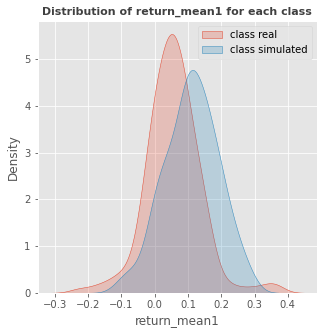

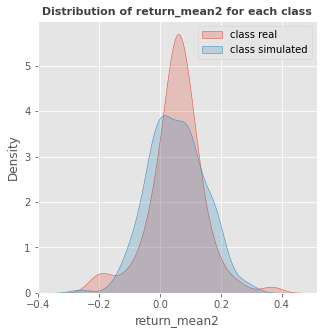

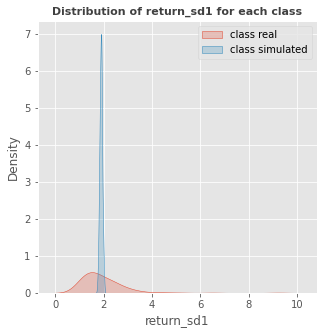

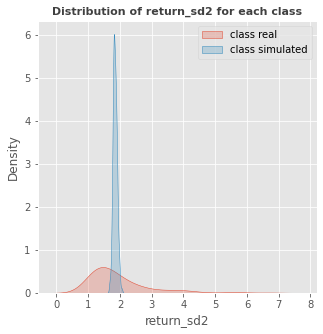

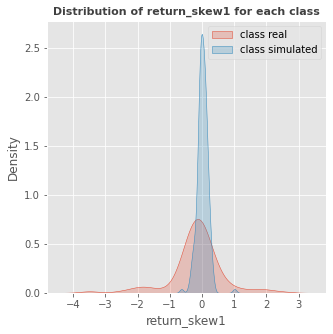

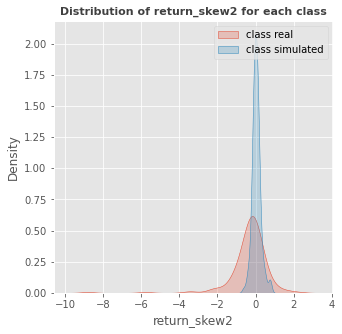

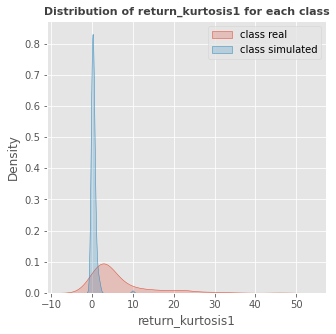

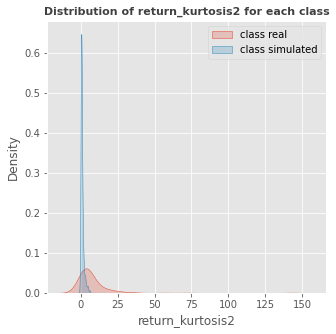

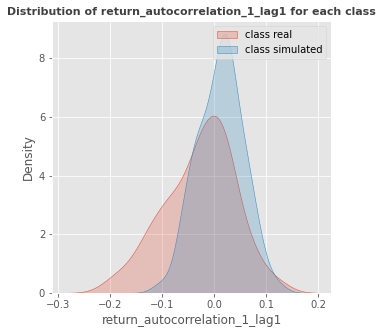

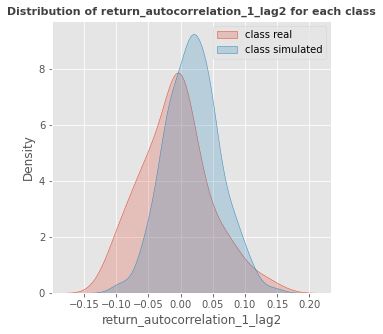

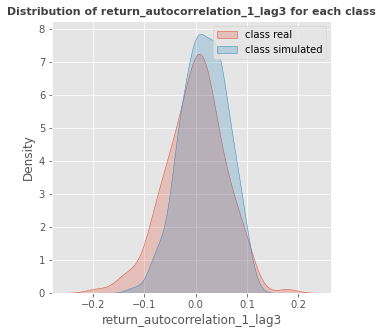

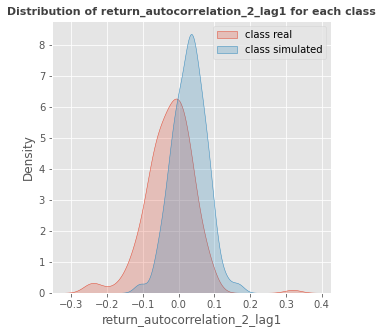

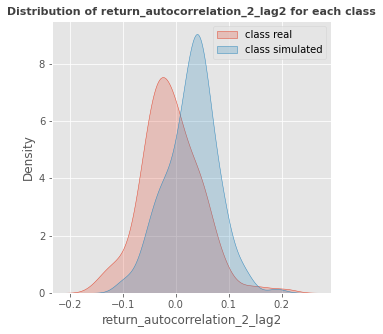

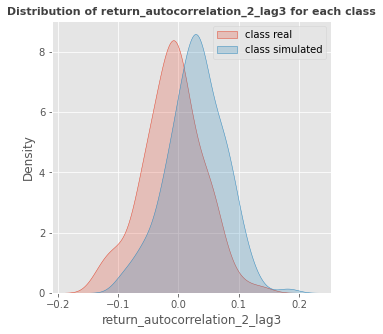

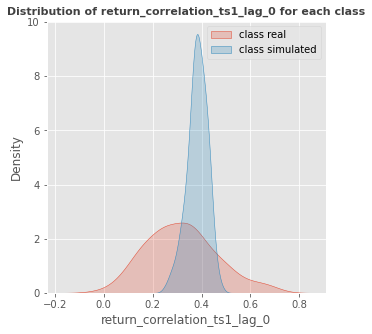

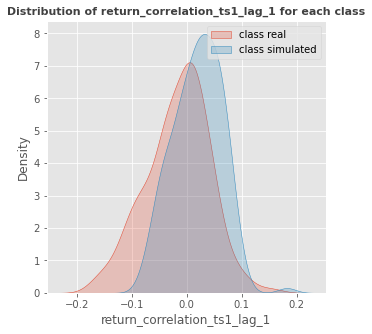

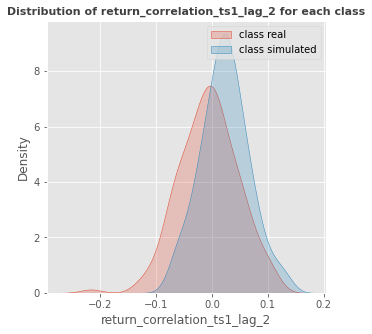

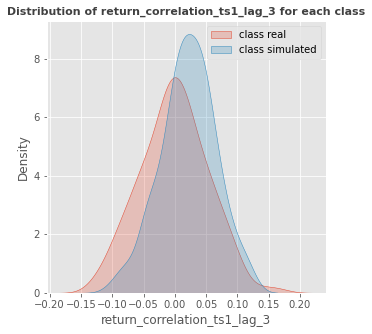

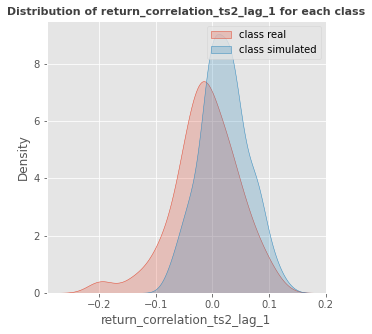

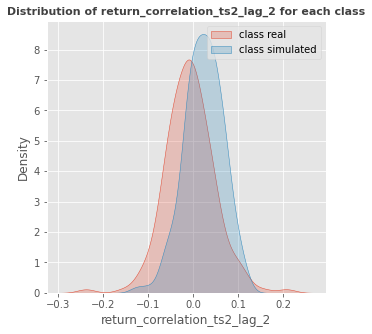

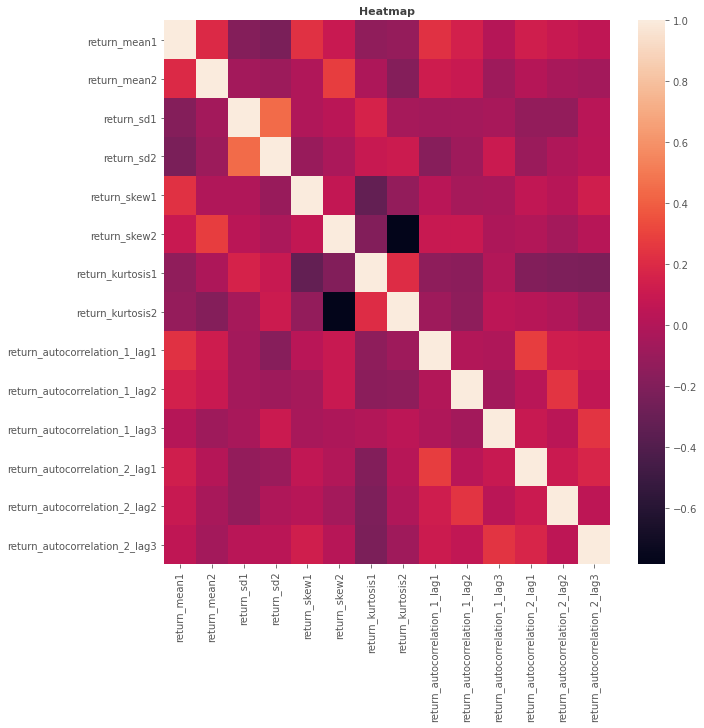

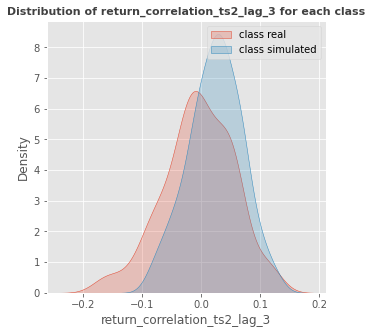

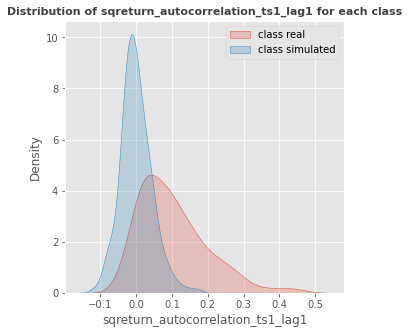

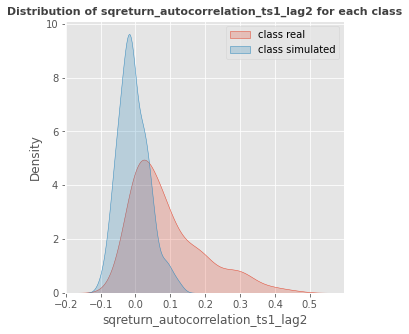

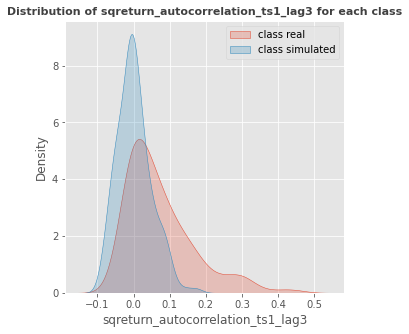

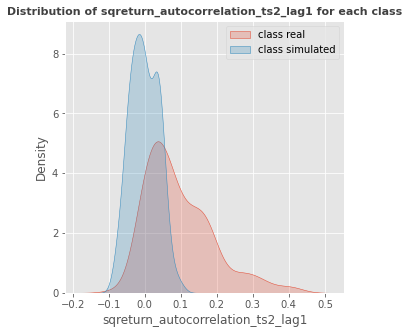

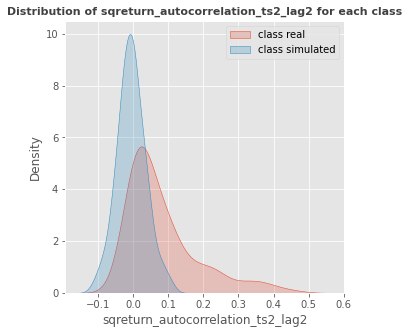

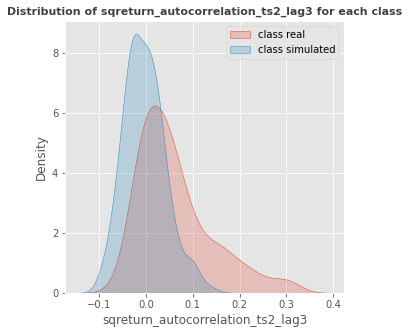

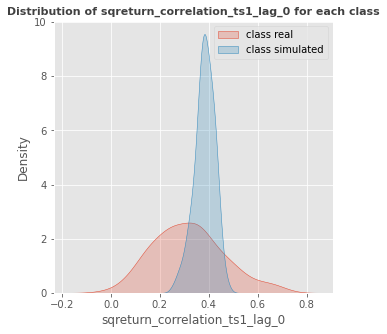

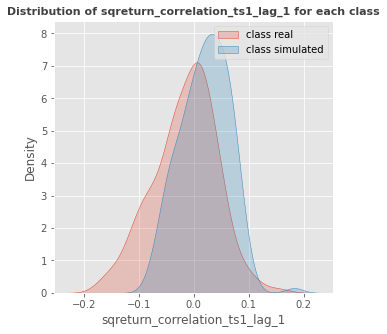

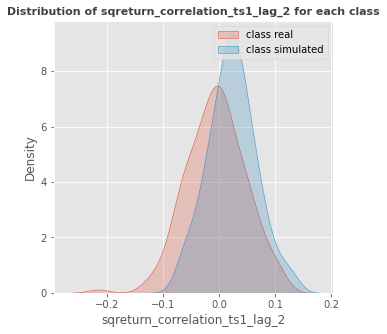

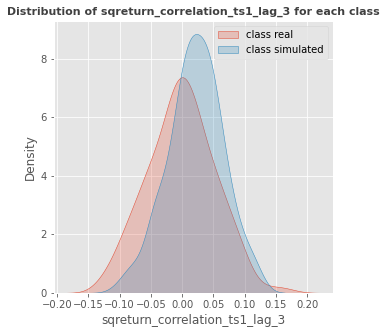

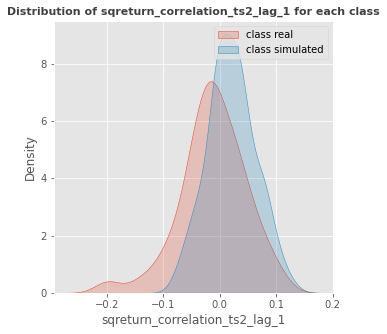

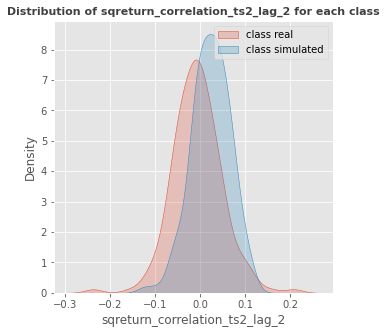

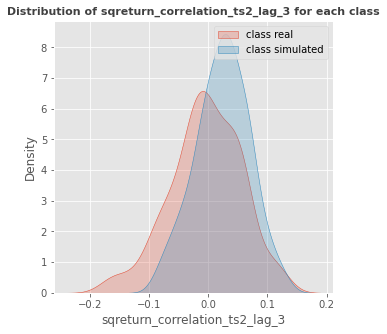

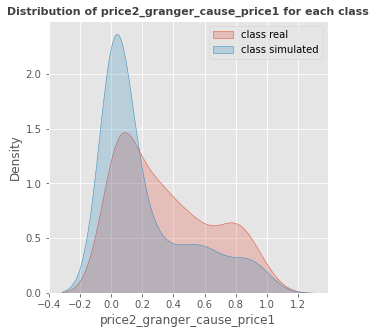

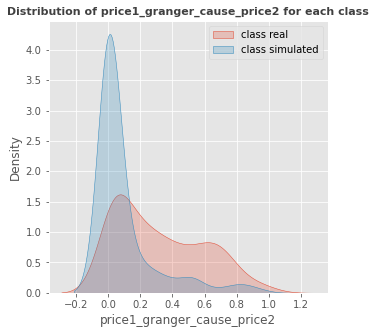

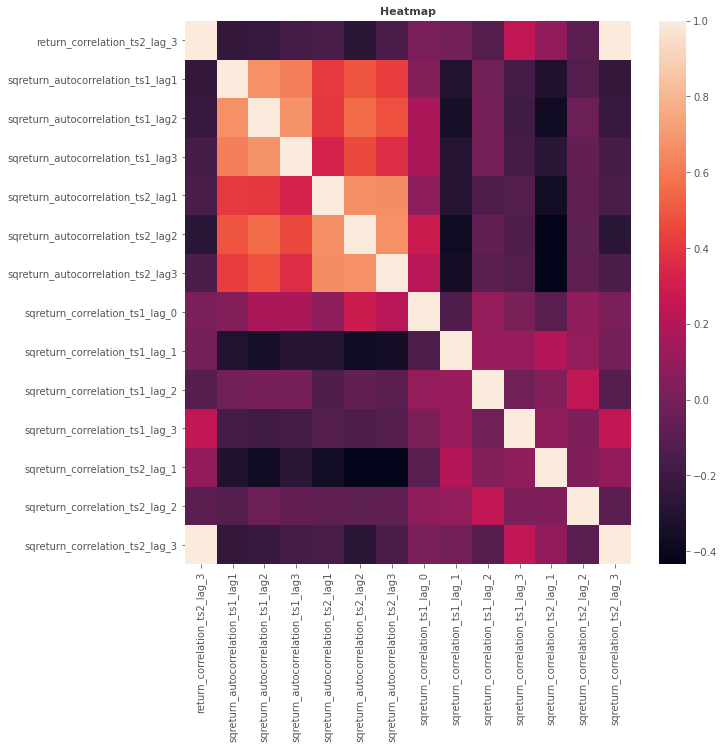

In [14]:
plt.rc('figure', max_open_warning = 0)
EDA.extensive_eda(X_train.iloc[:, 0:20], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_oujump")
EDA.extensive_eda(X_train.iloc[:, 20:36], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_oujump")

In [15]:
random_seed = 9868
real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_returns_classify.csv", 
    price_csv_location=real_data_folder + "pair_prices_classify.csv")

n_sim_jumpou_log_prices = n_jumpou_simulation(
    random_seed=random_seed, num_sim=248,
    mu11=params[0], mu12=params[1], 
    mu21=params[2], mu22=params[3], 
    sigma11=params[4], sigma12=params[5], 
    sigma21=params[6], sigma22=params[7],
    j11=params[8], j12=params[9], 
    j21=params[10], j22=params[11],
    alpha=params[12], 
    beta1=beta1, beta2=beta2, 
    delta0=params[13], 
    mu1=params[14], mu2=params[15], 
    lambda11=params[16], lambda12=lambda12, 
    lambda21=lambda21, lambda22=1/params[16],
    xinit_vec=xinit_vec, T0=T0, T=T, length=length)

n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_prices.csv")
n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_returns.csv")


simulated_statistics = create_statistics(
    label="simulated", 
    rolling_window=20, 
    return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_returns.csv", 
    price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_prices.csv")


dataset = pd.concat([real_statistics, simulated_statistics])
X = dataset.iloc[:, 0:36]
y = dataset.iloc[:, 36]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
automl = AutoML(eval_metric='accuracy')
automl.fit(X_train, y_train)
predictions = automl.predict(X_test)
accuracy_result = accuracy_score(y_test, predictions)

print(f"Accuracy of predictions:  {accuracy_result:.3f}")


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5909  , p=0.2048  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=3.2140  , p=0.2005  , df=2
likelihood ratio test: chi2=3.2037  , p=0.2015  , df=2
parameter F test:         F=1.5909  , p=0.2048  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.5049  , p=0.0016  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=13.1418 , p=0.0014  , df=2
likelihood ratio test: chi2=12.9713 , p=0.0015  , df=2
parameter F test:         F=6.5049  , p=0.0016  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6032  , p=0.4377  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.6068  , p=0.4360  , df=1
likelihood ratio test: chi2=0.6065  , p=0.4361  , df=1
parameter F test:         F=0.6032  , p=0.4377  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.8732 , p=0.0006  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4071  , p=0.2399  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=4.2815  , p=0.2326  , df=3
likelihood ratio test: chi2=4.2632  , p=0.2344  , df=3
parameter F test:         F=1.4071  , p=0.2399  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6382  , p=0.1796  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=4.9850  , p=0.1729  , df=3
likelihood ratio test: chi2=4.9601  , p=0.1747  , df=3
parameter F test:         F=1.6382  , p=0.1796  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7299  , p=0.4825  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.4746  , p=0.4784  , df=2
likelihood ratio test: chi2=1.4724  , p=0.4789  , df=2
parameter F test:         F=0.7299  , p=0.4825  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6513  , p=0.5218  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8855  , p=0.3471  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.8909  , p=0.3452  , df=1
likelihood ratio test: chi2=0.8901  , p=0.3455  , df=1
parameter F test:         F=0.8855  , p=0.3471  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7701  , p=0.3806  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.7748  , p=0.3787  , df=1
likelihood ratio test: chi2=0.7742  , p=0.3789  , df=1
parameter F test:         F=0.7701  , p=0.3806  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3677  , p=0.8317  , df_denom=487, df_num=4
ssr based chi2 test:   chi2=1.4978  , p=0.8270  , df=4
likelihood ratio test: chi2=1.4956  , p=0.8274  , df=4
parameter F test:         F=0.3677  , p=0.8317  , df_denom=487, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8695  , p=0.1146  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5593  , p=0.5720  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.1299  , p=0.5684  , df=2
likelihood ratio test: chi2=1.1286  , p=0.5688  , df=2
parameter F test:         F=0.5593  , p=0.5720  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3638  , p=0.6952  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=0.7349  , p=0.6925  , df=2
likelihood ratio test: chi2=0.7344  , p=0.6927  , df=2
parameter F test:         F=0.3638  , p=0.6952  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0002  , p=0.9886  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0002  , p=0.9885  , df=1
likelihood ratio test: chi2=0.0002  , p=0.9885  , df=1
parameter F test:         F=0.0002  , p=0.9886  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2422  , p=0.6228  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.0699 , p=0.0016  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=10.1308 , p=0.0015  , df=1
likelihood ratio test: chi2=10.0293 , p=0.0015  , df=1
parameter F test:         F=10.0699 , p=0.0016  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1132  , p=0.7366  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.1139  , p=0.7357  , df=1
likelihood ratio test: chi2=0.1139  , p=0.7357  , df=1
parameter F test:         F=0.1132  , p=0.7366  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3763  , p=0.0131  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=8.8414  , p=0.0120  , df=2
likelihood ratio test: chi2=8.7639  , p=0.0125  , df=2
parameter F test:         F=4.3763  , p=0.0131  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6758  , p=0.0260  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3529  , p=0.5527  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.3551  , p=0.5513  , df=1
likelihood ratio test: chi2=0.3549  , p=0.5513  , df=1
parameter F test:         F=0.3529  , p=0.5527  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6498  , p=0.4206  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.6538  , p=0.4188  , df=1
likelihood ratio test: chi2=0.6533  , p=0.4189  , df=1
parameter F test:         F=0.6498  , p=0.4206  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8344  , p=0.0098  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=11.6676 , p=0.0086  , df=3
likelihood ratio test: chi2=11.5328 , p=0.0092  , df=3
parameter F test:         F=3.8344  , p=0.0098  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1800  , p=0.3168  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.3409  , p=0.0137  , df_denom=472, df_num=9
ssr based chi2 test:   chi2=21.9160 , p=0.0091  , df=9
likelihood ratio test: chi2=21.4410 , p=0.0108  , df=9
parameter F test:         F=2.3409  , p=0.0137  , df_denom=472, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.7654  , p=0.6486  , df_denom=472, df_num=9
ssr based chi2 test:   chi2=7.1660  , p=0.6198  , df=9
likelihood ratio test: chi2=7.1142  , p=0.6252  , df=9
parameter F test:         F=0.7654  , p=0.6486  , df_denom=472, df_num=9

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7966  , p=0.4514  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.6094  , p=0.4472  , df=2
likelihood ratio test: chi2=1.6068  , p=0.4478  , df=2
parameter F test:         F=0.7966  , p=0.4514  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0710  , p=0.0176  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5485  , p=0.5782  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.1081  , p=0.5746  , df=2
likelihood ratio test: chi2=1.1068  , p=0.5750  , df=2
parameter F test:         F=0.5485  , p=0.5782  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7103  , p=0.0094  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=9.5161  , p=0.0086  , df=2
likelihood ratio test: chi2=9.4263  , p=0.0090  , df=2
parameter F test:         F=4.7103  , p=0.0094  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6434  , p=0.0269  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=7.3607  , p=0.0252  , df=2
likelihood ratio test: chi2=7.3068  , p=0.0259  , df=2
parameter F test:         F=3.6434  , p=0.0269  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2685  , p=0.0389  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.5360  , p=0.8073  , df_denom=478, df_num=7
ssr based chi2 test:   chi2=3.8699  , p=0.7946  , df=7
likelihood ratio test: chi2=3.8547  , p=0.7963  , df=7
parameter F test:         F=0.5360  , p=0.8073  , df_denom=478, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.2240  , p=0.0312  , df_denom=478, df_num=7
ssr based chi2 test:   chi2=16.0565 , p=0.0246  , df=7
likelihood ratio test: chi2=15.8005 , p=0.0270  , df=7
parameter F test:         F=2.2240  , p=0.0312  , df_denom=478, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7815  , p=0.3771  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.7863  , p=0.3752  , df=1
likelihood ratio test: chi2=0.7856  , p=0.3754  , df=1
parameter F test:         F=0.7815  , p=0.3771  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1180  , p=0.1462  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.7070  , p=0.0943  , df_denom=475, df_num=8
ssr based chi2 test:   chi2=14.1450 , p=0.0781  , df=8
likelihood ratio test: chi2=13.9455 , p=0.0832  , df=8
parameter F test:         F=1.7070  , p=0.0943  , df_denom=475, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.6345  , p=0.1125  , df_denom=475, df_num=8
ssr based chi2 test:   chi2=13.5437 , p=0.0945  , df=8
likelihood ratio test: chi2=13.3606 , p=0.1000  , df=8
parameter F test:         F=1.6345  , p=0.1125  , df_denom=475, df_num=8

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5123  , p=0.5994  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.0350  , p=0.5960  , df=2
likelihood ratio test: chi2=1.0339  , p=0.5963  , df=2
parameter F test:         F=0.5123  , p=0.5994  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1450  , p=0.0164  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8242  , p=0.1774  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.8352  , p=0.1755  , df=1
likelihood ratio test: chi2=1.8318  , p=0.1759  , df=1
parameter F test:         F=1.8242  , p=0.1774  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3090  , p=0.5785  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.3109  , p=0.5771  , df=1
likelihood ratio test: chi2=0.3108  , p=0.5772  , df=1
parameter F test:         F=0.3090  , p=0.5785  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4018  , p=0.2370  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.4103  , p=0.2350  , df=1
likelihood ratio test: chi2=1.4083  , p=0.2353  , df=1
parameter F test:         F=1.4018  , p=0.2370  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7914  , p=0.3741  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6655  , p=0.1975  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.6756  , p=0.1955  , df=1
likelihood ratio test: chi2=1.6728  , p=0.1959  , df=1
parameter F test:         F=1.6655  , p=0.1975  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1818  , p=0.2775  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.1890  , p=0.2755  , df=1
likelihood ratio test: chi2=1.1876  , p=0.2758  , df=1
parameter F test:         F=1.1818  , p=0.2775  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0367  , p=0.0253  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=5.0672  , p=0.0244  , df=1
likelihood ratio test: chi2=5.0416  , p=0.0247  , df=1
parameter F test:         F=5.0367  , p=0.0253  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0169  , p=0.8968  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5113  , p=0.4749  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.5144  , p=0.4732  , df=1
likelihood ratio test: chi2=0.5141  , p=0.4733  , df=1
parameter F test:         F=0.5113  , p=0.4749  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1745  , p=0.6763  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.1756  , p=0.6752  , df=1
likelihood ratio test: chi2=0.1756  , p=0.6752  , df=1
parameter F test:         F=0.1745  , p=0.6763  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8527  , p=0.3562  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.8579  , p=0.3543  , df=1
likelihood ratio test: chi2=0.8571  , p=0.3545  , df=1
parameter F test:         F=0.8527  , p=0.3562  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1165  , p=0.7330  

ssr based F test:         F=0.3113  , p=0.5771  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.3132  , p=0.5757  , df=1
likelihood ratio test: chi2=0.3131  , p=0.5758  , df=1
parameter F test:         F=0.3113  , p=0.5771  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4801  , p=0.2243  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.4891  , p=0.2224  , df=1
likelihood ratio test: chi2=1.4869  , p=0.2227  , df=1
parameter F test:         F=1.4801  , p=0.2243  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3110  , p=0.5773  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.3129  , p=0.5759  , df=1
likelihood ratio test: chi2=0.3128  , p=0.5759  , df=1
parameter F test:         F=0.3110  , p=0.5773  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1090  , p=0.7414  , df_denom=496, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5424  , p=0.1115  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.5578  , p=0.1098  , df=1
likelihood ratio test: chi2=2.5512  , p=0.1102  , df=1
parameter F test:         F=2.5424  , p=0.1115  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1897  , p=0.6634  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.1908  , p=0.6622  , df=1
likelihood ratio test: chi2=0.1908  , p=0.6622  , df=1
parameter F test:         F=0.1897  , p=0.6634  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7344  , p=0.1885  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.7449  , p=0.1865  , df=1
likelihood ratio test: chi2=1.7418  , p=0.1869  , df=1
parameter F test:         F=1.7344  , p=0.1885  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5370  , p=0.4640  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2960  , p=0.2751  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=3.9437  , p=0.2676  , df=3
likelihood ratio test: chi2=3.9281  , p=0.2693  , df=3
parameter F test:         F=1.2960  , p=0.2751  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8269  , p=0.4795  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=2.5160  , p=0.4724  , df=3
likelihood ratio test: chi2=2.5096  , p=0.4736  , df=3
parameter F test:         F=0.8269  , p=0.4795  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.9946  , p=0.4343  , df_denom=478, df_num=7
ssr based chi2 test:   chi2=7.1806  , p=0.4103  , df=7
likelihood ratio test: chi2=7.1288  , p=0.4156  , df=7
parameter F test:         F=0.9946  , p=0.4343  , df_denom=478, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.0907  , p=0.3679  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6220  , p=0.1834  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=4.9355  , p=0.1766  , df=3
likelihood ratio test: chi2=4.9111  , p=0.1784  , df=3
parameter F test:         F=1.6220  , p=0.1834  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8312  , p=0.0379  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=8.6149  , p=0.0349  , df=3
likelihood ratio test: chi2=8.5411  , p=0.0361  , df=3
parameter F test:         F=2.8312  , p=0.0379  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0912  , p=0.2967  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.0978  , p=0.2947  , df=1
likelihood ratio test: chi2=1.0966  , p=0.2950  , df=1
parameter F test:         F=1.0912  , p=0.2967  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6270  , p=0.1057  

likelihood ratio test: chi2=5.7506  , p=0.0564  , df=2
parameter F test:         F=2.8630  , p=0.0580  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.3806  , p=0.0096  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=13.7719 , p=0.0081  , df=4
likelihood ratio test: chi2=13.5846 , p=0.0087  , df=4
parameter F test:         F=3.3806  , p=0.0096  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3756  , p=0.8261  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=1.5301  , p=0.8213  , df=4
likelihood ratio test: chi2=1.5277  , p=0.8217  , df=4
parameter F test:         F=0.3756  , p=0.8261  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6354  , p=0.0727  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.3242  , p=0.0698  , df=2
likelihood ratio test: chi2=5.2960  , p=0.0708  , df=2
parameter F test:         F=2.6354  , p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.0768 , p=0.0009  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.1436 , p=0.0008  , df=1
likelihood ratio test: chi2=11.0213 , p=0.0009  , df=1
parameter F test:         F=11.0768 , p=0.0009  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2433  , p=0.6220  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2448  , p=0.6208  , df=1
likelihood ratio test: chi2=0.2447  , p=0.6208  , df=1
parameter F test:         F=0.2433  , p=0.6220  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6710  , p=0.6123  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=2.7337  , p=0.6033  , df=4
likelihood ratio test: chi2=2.7262  , p=0.6046  , df=4
parameter F test:         F=0.6710  , p=0.6123  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0805  , p=0.0822  

likelihood ratio test: chi2=26.3683 , p=0.0009  , df=8
parameter F test:         F=3.2690  , p=0.0012  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.5159  , p=0.0000  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=37.4175 , p=0.0000  , df=8
likelihood ratio test: chi2=36.0655 , p=0.0000  , df=8
parameter F test:         F=4.5159  , p=0.0000  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1868  , p=0.8296  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.3775  , p=0.8280  , df=2
likelihood ratio test: chi2=0.3773  , p=0.8281  , df=2
parameter F test:         F=0.1868  , p=0.8296  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9657  , p=0.0196  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.0116  , p=0.0182  , df=2
likelihood ratio test: chi2=7.9480  , p=0.0188  , df=2
parameter F test:         F=3.9657  , p


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1608  , p=0.0004  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=18.7460 , p=0.0003  , df=3
likelihood ratio test: chi2=18.4018 , p=0.0004  , df=3
parameter F test:         F=6.1608  , p=0.0004  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=12.5206 , p=0.0000  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=38.0972 , p=0.0000  , df=3
likelihood ratio test: chi2=36.7103 , p=0.0000  , df=3
parameter F test:         F=12.5206 , p=0.0000  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5959  , p=0.0105  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.6358  , p=0.0100  , df=1
likelihood ratio test: chi2=6.5921  , p=0.0102  , df=1
parameter F test:         F=6.5959  , p=0.0105  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6367  , p=0.4253  

ssr based F test:         F=2.6965  , p=0.1012  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7128  , p=0.0995  , df=1
likelihood ratio test: chi2=2.7055  , p=0.1000  , df=1
parameter F test:         F=2.6965  , p=0.1012  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.9379 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=14.0221 , p=0.0002  , df=1
likelihood ratio test: chi2=13.8290 , p=0.0002  , df=1
parameter F test:         F=13.9379 , p=0.0002  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0002  , p=0.9876  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0002  , p=0.9875  , df=1
likelihood ratio test: chi2=0.0002  , p=0.9875  , df=1
parameter F test:         F=0.0002  , p=0.9876  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.1767  , p=0.3195  , df_denom=485, df_num=5
ssr based chi2 test: 

parameter F test:         F=5.9896  , p=0.0000  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1613  , p=0.6881  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1623  , p=0.6871  , df=1
likelihood ratio test: chi2=0.1623  , p=0.6871  , df=1
parameter F test:         F=0.1613  , p=0.6881  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2353  , p=0.0043  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.2850  , p=0.0040  , df=1
likelihood ratio test: chi2=8.2171  , p=0.0041  , df=1
parameter F test:         F=8.2353  , p=0.0043  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.5598  , p=0.7309  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=2.8624  , p=0.7212  , df=5
likelihood ratio test: chi2=2.8542  , p=0.7225  , df=5
parameter F test:         F=0.5598  , p=0.7309  , df_denom=485, df_num=5

Granger Causality
nu


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2657  , p=0.2829  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.5571  , p=0.2784  , df=2
likelihood ratio test: chi2=2.5505  , p=0.2794  , df=2
parameter F test:         F=1.2657  , p=0.2829  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.7127  , p=0.0001  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=19.6220 , p=0.0001  , df=2
likelihood ratio test: chi2=19.2460 , p=0.0001  , df=2
parameter F test:         F=9.7127  , p=0.0001  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8852  , p=0.3472  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8905  , p=0.3453  , df=1
likelihood ratio test: chi2=0.8897  , p=0.3455  , df=1
parameter F test:         F=0.8852  , p=0.3472  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.8237 , p=0.0001  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.0992 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=16.1964 , p=0.0001  , df=1
likelihood ratio test: chi2=15.9396 , p=0.0001  , df=1
parameter F test:         F=16.0992 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3411  , p=0.5595  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3431  , p=0.5580  , df=1
likelihood ratio test: chi2=0.3430  , p=0.5581  , df=1
parameter F test:         F=0.3411  , p=0.5595  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7315  , p=0.1781  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.4980  , p=0.1739  , df=2
likelihood ratio test: chi2=3.4858  , p=0.1750  , df=2
parameter F test:         F=1.7315  , p=0.1781  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1444  , p=0.3193  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.0776  , p=0.3718  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=5.5104  , p=0.3568  , df=5
likelihood ratio test: chi2=5.4800  , p=0.3601  , df=5
parameter F test:         F=1.0776  , p=0.3718  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.8190  , p=0.0021  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=19.5278 , p=0.0015  , df=5
likelihood ratio test: chi2=19.1532 , p=0.0018  , df=5
parameter F test:         F=3.8190  , p=0.0021  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2543  , p=0.2633  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2619  , p=0.2613  , df=1
likelihood ratio test: chi2=1.2603  , p=0.2616  , df=1
parameter F test:         F=1.2543  , p=0.2633  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.3496 , p=0.0000  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.5514  , p=0.0005  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=29.4257 , p=0.0003  , df=8
likelihood ratio test: chi2=28.5810 , p=0.0004  , df=8
parameter F test:         F=3.5514  , p=0.0005  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.2553  , p=0.0001  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=35.2581 , p=0.0000  , df=8
likelihood ratio test: chi2=34.0544 , p=0.0000  , df=8
parameter F test:         F=4.2553  , p=0.0001  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.3849  , p=0.0210  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=17.2174 , p=0.0160  , df=7
likelihood ratio test: chi2=16.9242 , p=0.0179  , df=7
parameter F test:         F=2.3849  , p=0.0210  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.2920  , p=0.0264  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1103  , p=0.7399  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1110  , p=0.7390  , df=1
likelihood ratio test: chi2=0.1110  , p=0.7390  , df=1
parameter F test:         F=0.1103  , p=0.7399  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.2545 , p=0.0005  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.3285 , p=0.0004  , df=1
likelihood ratio test: chi2=12.1790 , p=0.0005  , df=1
parameter F test:         F=12.2545 , p=0.0005  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.6662  , p=0.0032  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=14.1981 , p=0.0026  , df=3
likelihood ratio test: chi2=13.9995 , p=0.0029  , df=3
parameter F test:         F=4.6662  , p=0.0032  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.3601  , p=0.0001  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5307  , p=0.6614  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.6147  , p=0.6561  , df=3
likelihood ratio test: chi2=1.6121  , p=0.6567  , df=3
parameter F test:         F=0.5307  , p=0.6614  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.0281  , p=0.0019  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=15.2994 , p=0.0016  , df=3
likelihood ratio test: chi2=15.0691 , p=0.0018  , df=3
parameter F test:         F=5.0281  , p=0.0019  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.1531  , p=0.0241  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=20.1561 , p=0.0170  , df=9
likelihood ratio test: chi2=19.7542 , p=0.0195  , df=9
parameter F test:         F=2.1531  , p=0.0241  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.1472  , p=0.0011  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1646  , p=0.6851  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1656  , p=0.6840  , df=1
likelihood ratio test: chi2=0.1656  , p=0.6841  , df=1
parameter F test:         F=0.1646  , p=0.6851  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8224  , p=0.1776  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8334  , p=0.1757  , df=1
likelihood ratio test: chi2=1.8300  , p=0.1761  , df=1
parameter F test:         F=1.8224  , p=0.1776  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=10.7846 , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=43.9339 , p=0.0000  , df=4
likelihood ratio test: chi2=42.0994 , p=0.0000  , df=4
parameter F test:         F=10.7846 , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.0962  , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3289  , p=0.0041  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.3792  , p=0.0038  , df=1
likelihood ratio test: chi2=8.3097  , p=0.0039  , df=1
parameter F test:         F=8.3289  , p=0.0041  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4061  , p=0.5242  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4086  , p=0.5227  , df=1
likelihood ratio test: chi2=0.4084  , p=0.5228  , df=1
parameter F test:         F=0.4061  , p=0.5242  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1457  , p=0.7028  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1466  , p=0.7018  , df=1
likelihood ratio test: chi2=0.1466  , p=0.7018  , df=1
parameter F test:         F=0.1457  , p=0.7028  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=21.9840 , p=0.0000  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5659  , p=0.2099  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.1634  , p=0.2056  , df=2
likelihood ratio test: chi2=3.1534  , p=0.2067  , df=2
parameter F test:         F=1.5659  , p=0.2099  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.4295  , p=0.0003  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=17.0297 , p=0.0002  , df=2
likelihood ratio test: chi2=16.7455 , p=0.0002  , df=2
parameter F test:         F=8.4295  , p=0.0003  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.4725  , p=0.0038  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.5237  , p=0.0035  , df=1
likelihood ratio test: chi2=8.4518  , p=0.0036  , df=1
parameter F test:         F=8.4725  , p=0.0038  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5335  , p=0.0063  

AutoML directory: AutoML_62
The task is binary_classification with evaluation metric accuracy
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 34.89 seconds
2_DecisionTree accuracy 0.931034 trained in 10.84 seconds
3_Linear accuracy 0.977011 trained in 3.09 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 3.41 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 1.59 seconds
6_Default_RandomForest accuracy 0.988506 trained in 6.54 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.17 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 70.57 seconds
AutoML best model: 4_Default_Xgboost
Accuracy of predictions:  0.919


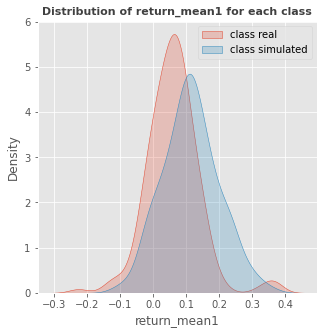

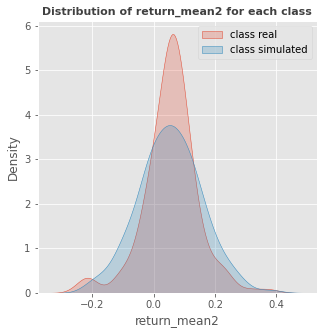

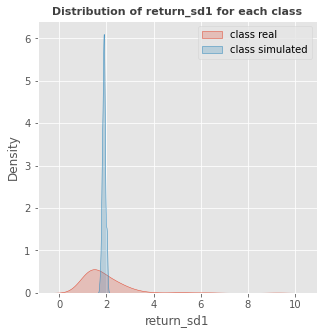

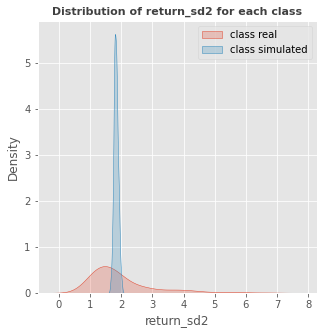

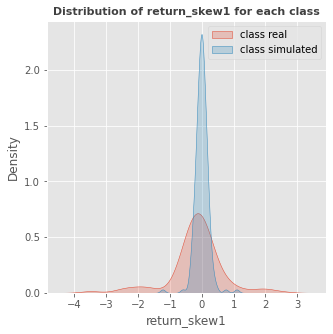

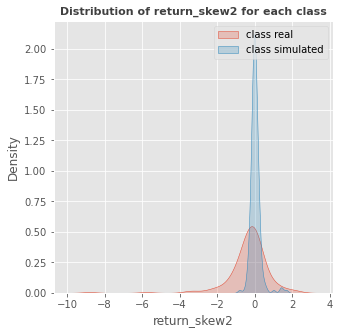

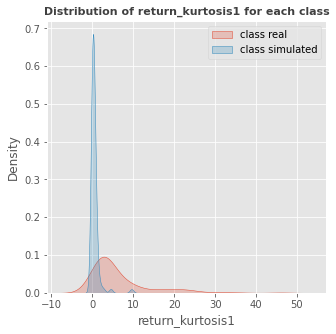

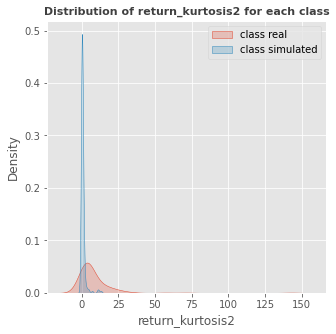

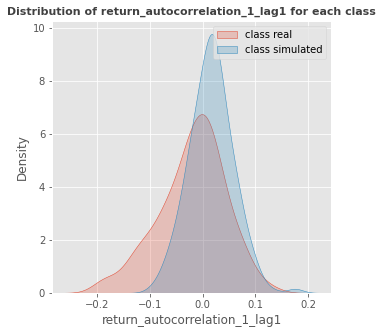

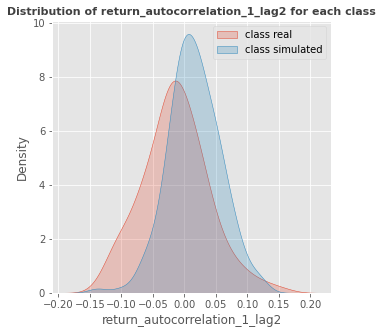

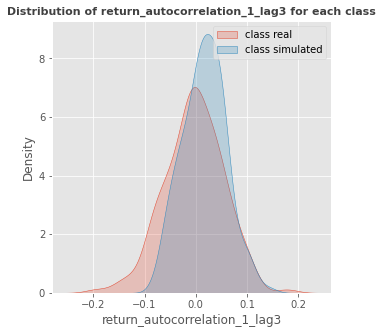

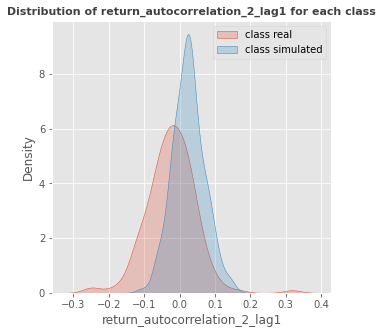

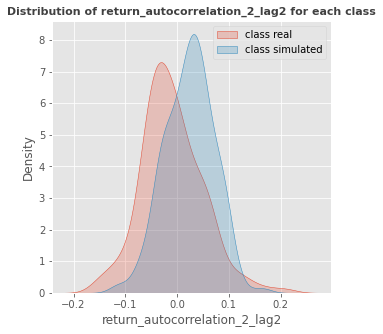

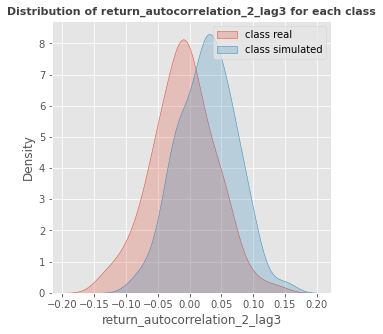

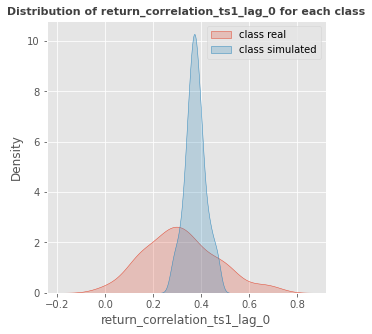

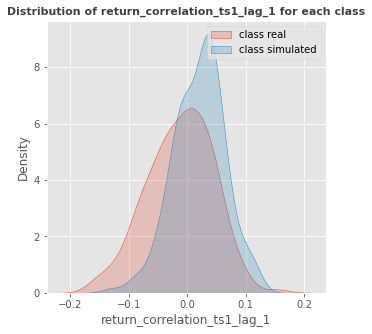

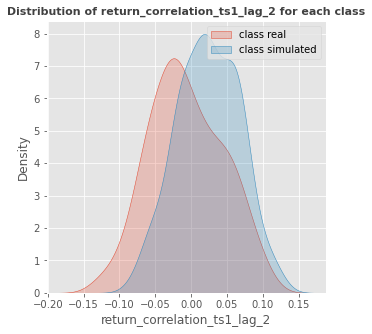

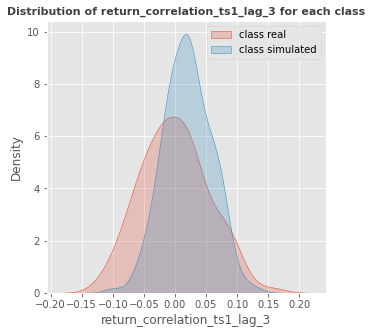

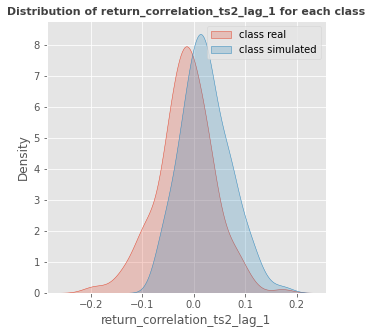

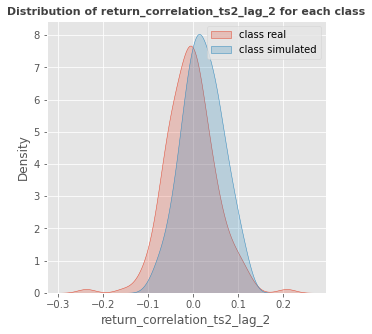

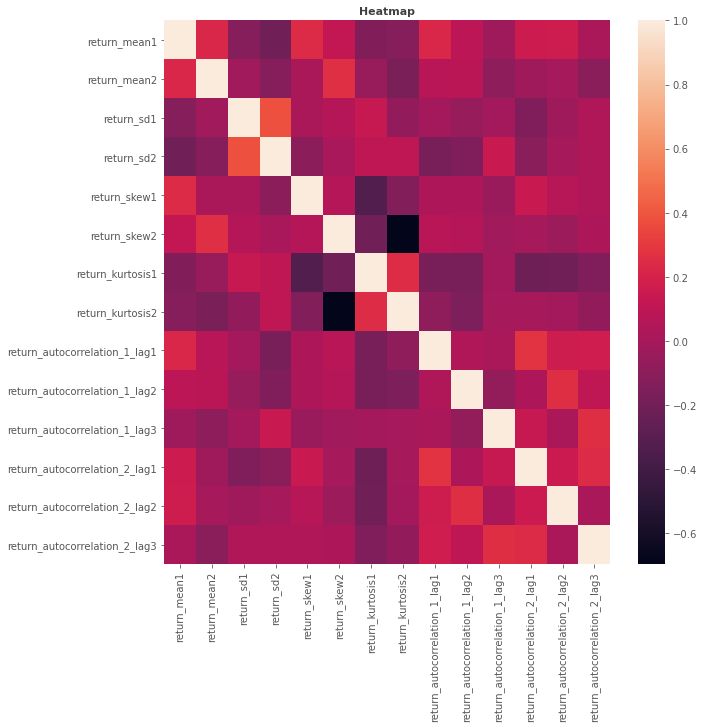

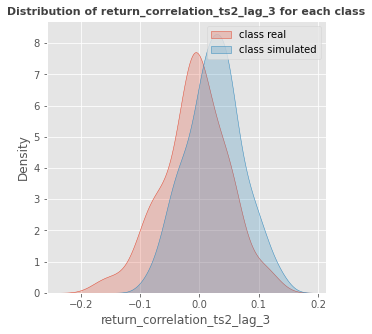

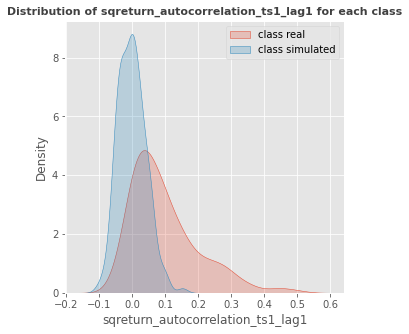

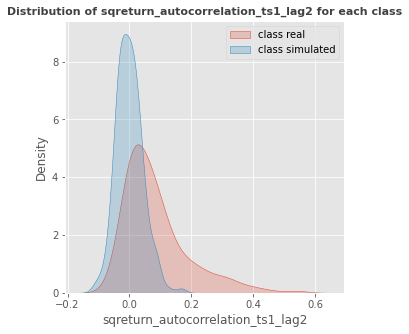

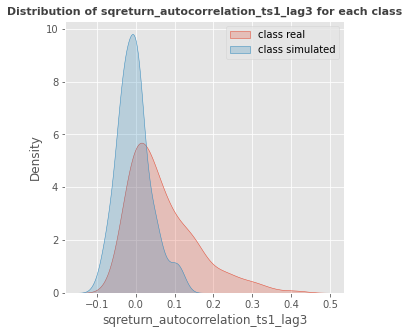

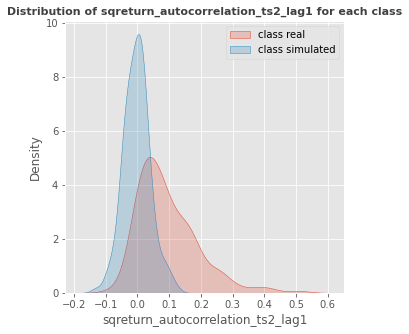

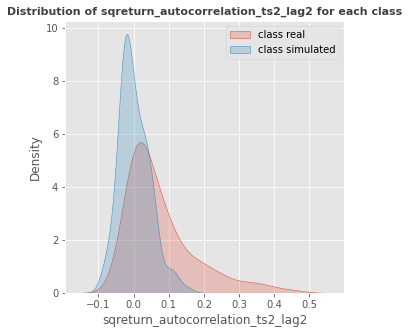

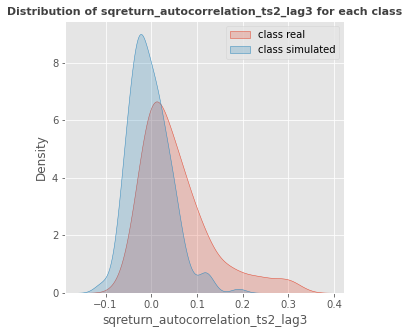

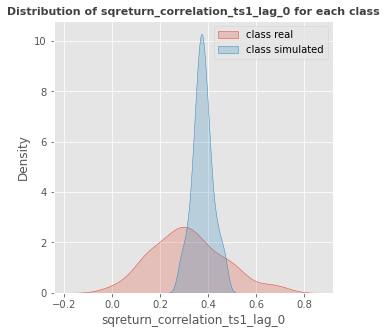

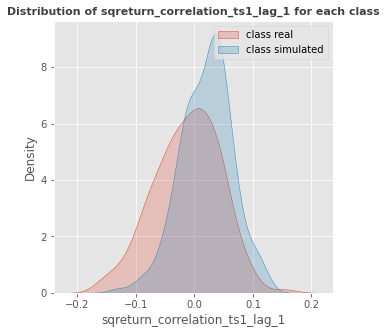

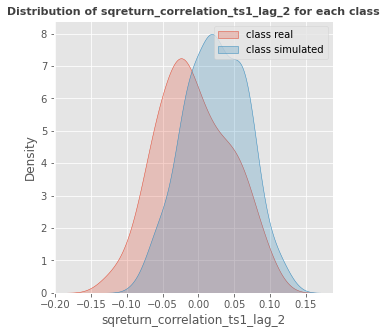

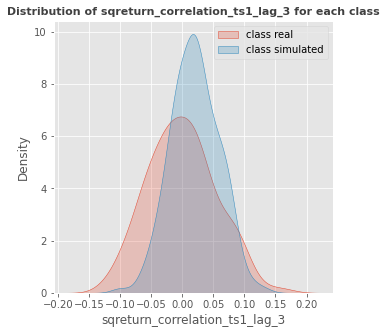

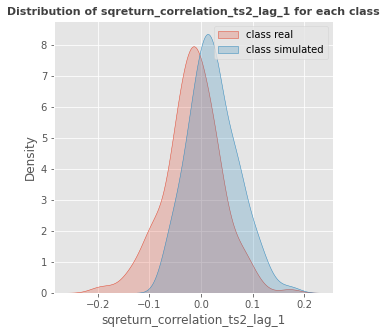

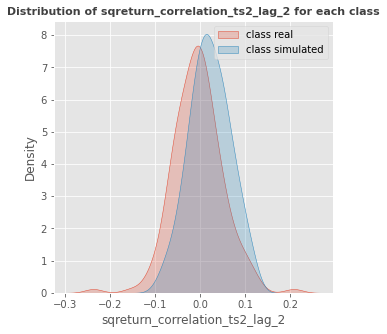

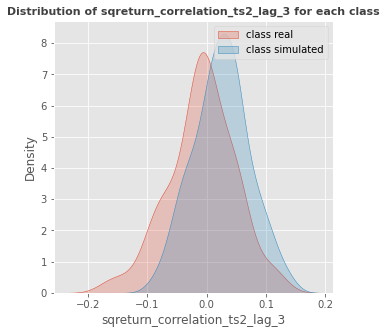

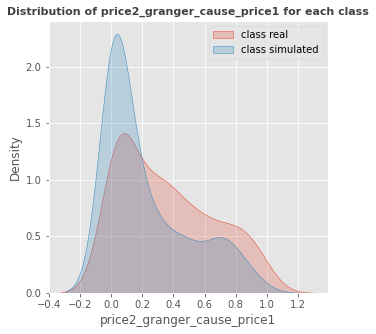

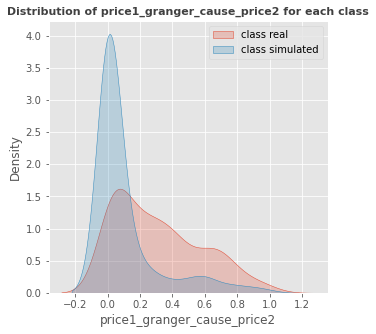

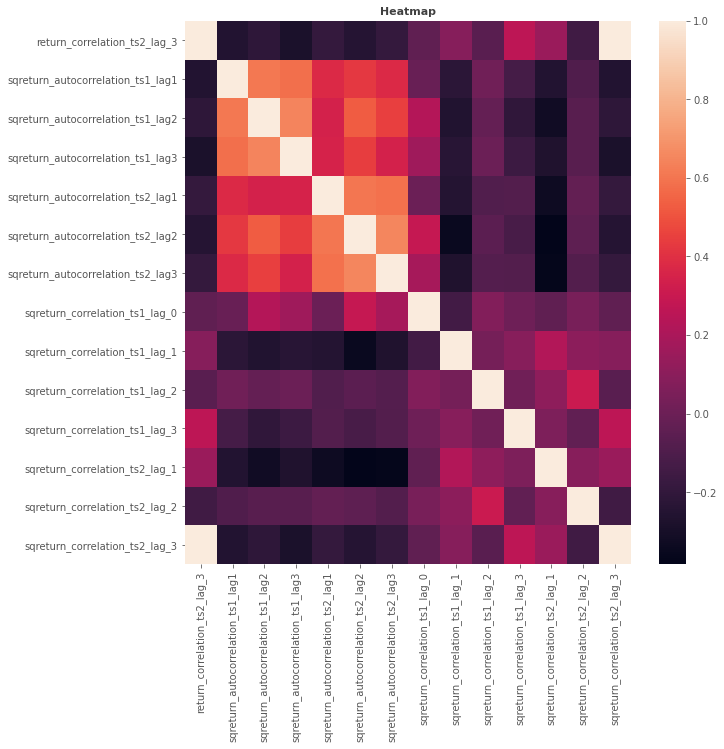

In [16]:
plt.rc('figure', max_open_warning = 0)
EDA.extensive_eda(X_train.iloc[:, 0:20], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_oujump_2")
EDA.extensive_eda(X_train.iloc[:, 20:36], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_oujump_2")